**Install Libraries**

In [1]:
!pip install torch-geometric

In [2]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric==2.4.0

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [4]:
!pip install lightgbm xgboost shap imbalanced-learn eli5
!pip install catboost
!pip install tensorflow

**Import Libraries**

In [5]:
# ======================================================
# Step 1: Import Libraries
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, log_loss
)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import roc_curve, auc


**Load Data**

In [6]:
# Load Dataset

df = pd.read_csv("/content/drive/MyDrive/Cybersecurity_Dataset/CTDAPD Dataset.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (54768, 30)


Date    Source_IP Destination_IP  Source_Port  \
0  2018-01-01 00:00:00  192.168.1.1        8.8.8.8        57708   
1  2018-01-01 01:00:00   172.16.0.1        4.4.4.4        29980   
2  2018-01-01 02:00:00     10.0.0.1        8.8.8.8        31923   
3  2018-01-01 03:00:00  192.168.1.1        8.8.8.8        10525   
4  2018-01-01 04:00:00  192.168.1.1        1.1.1.1        31755   

   Destination_Port Protocol_Type  Flow_Duration  Packet_Size  \
0               443           TCP             15          500   
1              8080           TCP            390          472   
2               443           TCP            120          129   
3                80           TCP              3          500   
4                80           UDP              7          458   

   Flow_Bytes_per_s  Flow_Packets_per_s  ...  Attack_Vector  Attack_Severity  \
0          6.375467            5.414037  ...            NaN              Low   
1          6.694334            2.497333  ...            NaN              Low   
2          7.948582            3.607725  ...            NaN           Medium   
3          7.326526            4.144272  ...            NaN              Low   
4          7.080846            2.667007  ...            NaN           Medium   

   Botnet_Family  Malware_Type  CPU_Utilization  Memory_Utilization  \
0            NaN           NaN        16.375491           60.918547   
1            NaN           NaN        31.986167            7.718833   
2            NaN           NaN         1.919325           51.726672   
3            NaN           NaN        21.078560           20.463289   
4            NaN           NaN        24.940597           43.652572   

   System_Patch_Status   Label  Normalized_Packet_Flow  Anomaly_Severity_Index  
0             Outdated  Normal                2.000000               73.168788  
1             Outdated  Attack                0.102564               16.059524  
2           Up-to-date  Normal                0.233333               99.333361  
3           Up-to-date  Normal                9.666667               46.645165  
4           Up-to-date  Normal                3.571429               31.648643  

[5 rows x 30 columns]

In [7]:
# Column names
df.columns.tolist()

['Date',
 'Source_IP',
 'Destination_IP',
 'Source_Port',
 'Destination_Port',
 'Protocol_Type',
 'Flow_Duration',
 'Packet_Size',
 'Flow_Bytes_per_s',
 'Flow_Packets_per_s',
 'Total_Forward_Packets',
 'Total_Backward_Packets',
 'Packet_Length_Mean_Forward',
 'Packet_Length_Mean_Backward',
 'IAT_Forward',
 'IAT_Backward',
 'Active_Duration',
 'Idle_Duration',
 'IDS_Alert_Count',
 'Anomaly_Score',
 'Attack_Vector',
 'Attack_Severity',
 'Botnet_Family',
 'Malware_Type',
 'CPU_Utilization',
 'Memory_Utilization',
 'System_Patch_Status',
 'Label',
 'Normalized_Packet_Flow',
 'Anomaly_Severity_Index']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54768 entries, 0 to 54767
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         54768 non-null  object 
 1   Source_IP                    54768 non-null  object 
 2   Destination_IP               54768 non-null  object 
 3   Source_Port                  54768 non-null  int64  
 4   Destination_Port             54768 non-null  int64  
 5   Protocol_Type                54768 non-null  object 
 6   Flow_Duration                54768 non-null  int64  
 7   Packet_Size                  54768 non-null  int64  
 8   Flow_Bytes_per_s             54768 non-null  float64
 9   Flow_Packets_per_s           54768 non-null  float64
 10  Total_Forward_Packets        54768 non-null  int64  
 11  Total_Backward_Packets       54768 non-null  int64  
 12  Packet_Length_Mean_Forward   54768 non-null  float64
 13  Packet_Length_Me

In [9]:
# Numerical columns
df.describe()

Source_Port  Destination_Port  Flow_Duration   Packet_Size  \
count  54768.000000      54768.000000   54768.000000  54768.000000   
mean   33277.551234        997.429886      99.992623    499.514151   
std    18608.977077       2389.963476     100.912556    149.585819   
min     1024.000000         22.000000       0.000000    -98.000000   
25%    17290.250000         80.000000      28.000000    399.000000   
50%    33268.000000         80.000000      69.000000    500.000000   
75%    49341.000000        443.000000     138.000000    600.000000   
max    65534.000000       8080.000000    1419.000000   1178.000000   

       Flow_Bytes_per_s  Flow_Packets_per_s  Total_Forward_Packets  \
count      54768.000000        54768.000000           54768.000000   
mean           8.385202            2.841539              20.031734   
std            4.450689            0.876234               4.492229   
min            0.785446            0.696836               5.000000   
25%            5.278162            2.216043              17.000000   
50%            7.402368            2.712611              20.000000   
75%           10.383595            3.331197              23.000000   
max           59.947983           10.436757              48.000000   

       Total_Backward_Packets  Packet_Length_Mean_Forward  \
count            54768.000000                54768.000000   
mean                15.020304                   50.019608   
std                  3.871626                    9.978183   
min                  2.000000                    2.137672   
25%                 12.000000                   43.287130   
50%                 15.000000                   50.008395   
75%                 18.000000                   56.744094   
max                 34.000000                   95.173960   

       Packet_Length_Mean_Backward   IAT_Forward  IAT_Backward  \
count                 54768.000000  54768.000000  54768.000000   
mean                     40.026906      9.979196      7.883737   
std                       8.018607     10.001600      7.917302   
min                       7.817328      0.000071      0.000064   
25%                      34.623878      2.908740      2.269830   
50%                      40.018224      6.876905      5.451427   
75%                      45.446017     13.799840     10.909540   
max                      72.889331    104.783597     96.706669   

       Active_Duration  Idle_Duration  IDS_Alert_Count  Anomaly_Score  \
count     54768.000000   54768.000000     54768.000000   54768.000000   
mean         29.984512     100.087122         1.001589      28.430072   
std           5.005694      20.096888         1.002752      15.988671   
min           8.479500      12.844591         0.000000       0.106772   
25%          26.637521      86.555954         0.000000      15.924299   
50%          30.011307     100.226255         1.000000      26.163885   
75%          33.321548     113.587690         2.000000      38.682566   
max          52.910048     179.376967         8.000000      93.563504   

       CPU_Utilization  Memory_Utilization  Normalized_Packet_Flow  \
count     54768.000000        54768.000000            5.476800e+04   
mean         28.698147           28.689594                     inf   
std          16.011281           16.084016                     NaN   
min           0.114827            0.161760            2.184637e-02   
25%          16.229912           16.166430            2.481752e-01   
50%          26.614780           26.577709            5.000000e-01   
75%          38.940186           39.149822            1.240000e+00   
max          91.857852           93.755891                     inf   

       Anomaly_Severity_Index  
count            54768.000000  
mean                31.913856  
std                 22.995449  
min                  0.076044  
25%                 14.887616  
50%                 26.428824  
75%                 43.012364  
max                248.275324

In [10]:
# Categorical columns
df.describe(include='object')

Date    Source_IP Destination_IP Protocol_Type  \
count                 54768        54768          54768         54768   
unique                54768            3              3             3   
top     2024-03-31 07:00:00  192.168.1.1        8.8.8.8           TCP   
freq                      1        38482          32854         38275   

       Attack_Vector Attack_Severity Botnet_Family Malware_Type  \
count          10933           54768          5545         3217   
unique             3               3             2            2   
top             DDoS             Low         Mirai      Spyware   
freq            5481           33015          2779         1625   

       System_Patch_Status   Label  
count                54768   54768  
unique                   2       2  
top             Up-to-date  Normal  
freq                 43707   46589

**Missing Value**

In [11]:
# Total missing values
df.isnull().sum()

Date                               0
Source_IP                          0
Destination_IP                     0
Source_Port                        0
Destination_Port                   0
Protocol_Type                      0
Flow_Duration                      0
Packet_Size                        0
Flow_Bytes_per_s                   0
Flow_Packets_per_s                 0
Total_Forward_Packets              0
Total_Backward_Packets             0
Packet_Length_Mean_Forward         0
Packet_Length_Mean_Backward        0
IAT_Forward                        0
IAT_Backward                       0
Active_Duration                    0
Idle_Duration                      0
IDS_Alert_Count                    0
Anomaly_Score                      0
Attack_Vector                  43835
Attack_Severity                    0
Botnet_Family                  49223
Malware_Type                   51551
CPU_Utilization                    0
Memory_Utilization                 0
System_Patch_Status                0
Label                              0
Normalized_Packet_Flow             0
Anomaly_Severity_Index             0
dtype: int64

In [12]:
# Percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
print("Missing value percentage:\n", missing_percent[missing_percent > 0])

Missing value percentage:
 Attack_Vector    80.037613
Botnet_Family    89.875475
Malware_Type     94.126132
dtype: float64


**Data Visualization**

**Outlier Detection: Effect of Numerical Features on Label Column**

/tmp/ipython-input-704583058.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, ax=axes[i], palette="Set2")
/tmp/ipython-input-704583058.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, ax=axes[i], palette="Set2")
/tmp/ipython-input-704583058.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, ax=axes[i], palette="Set2")
/tmp/ipython-input-704583058.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

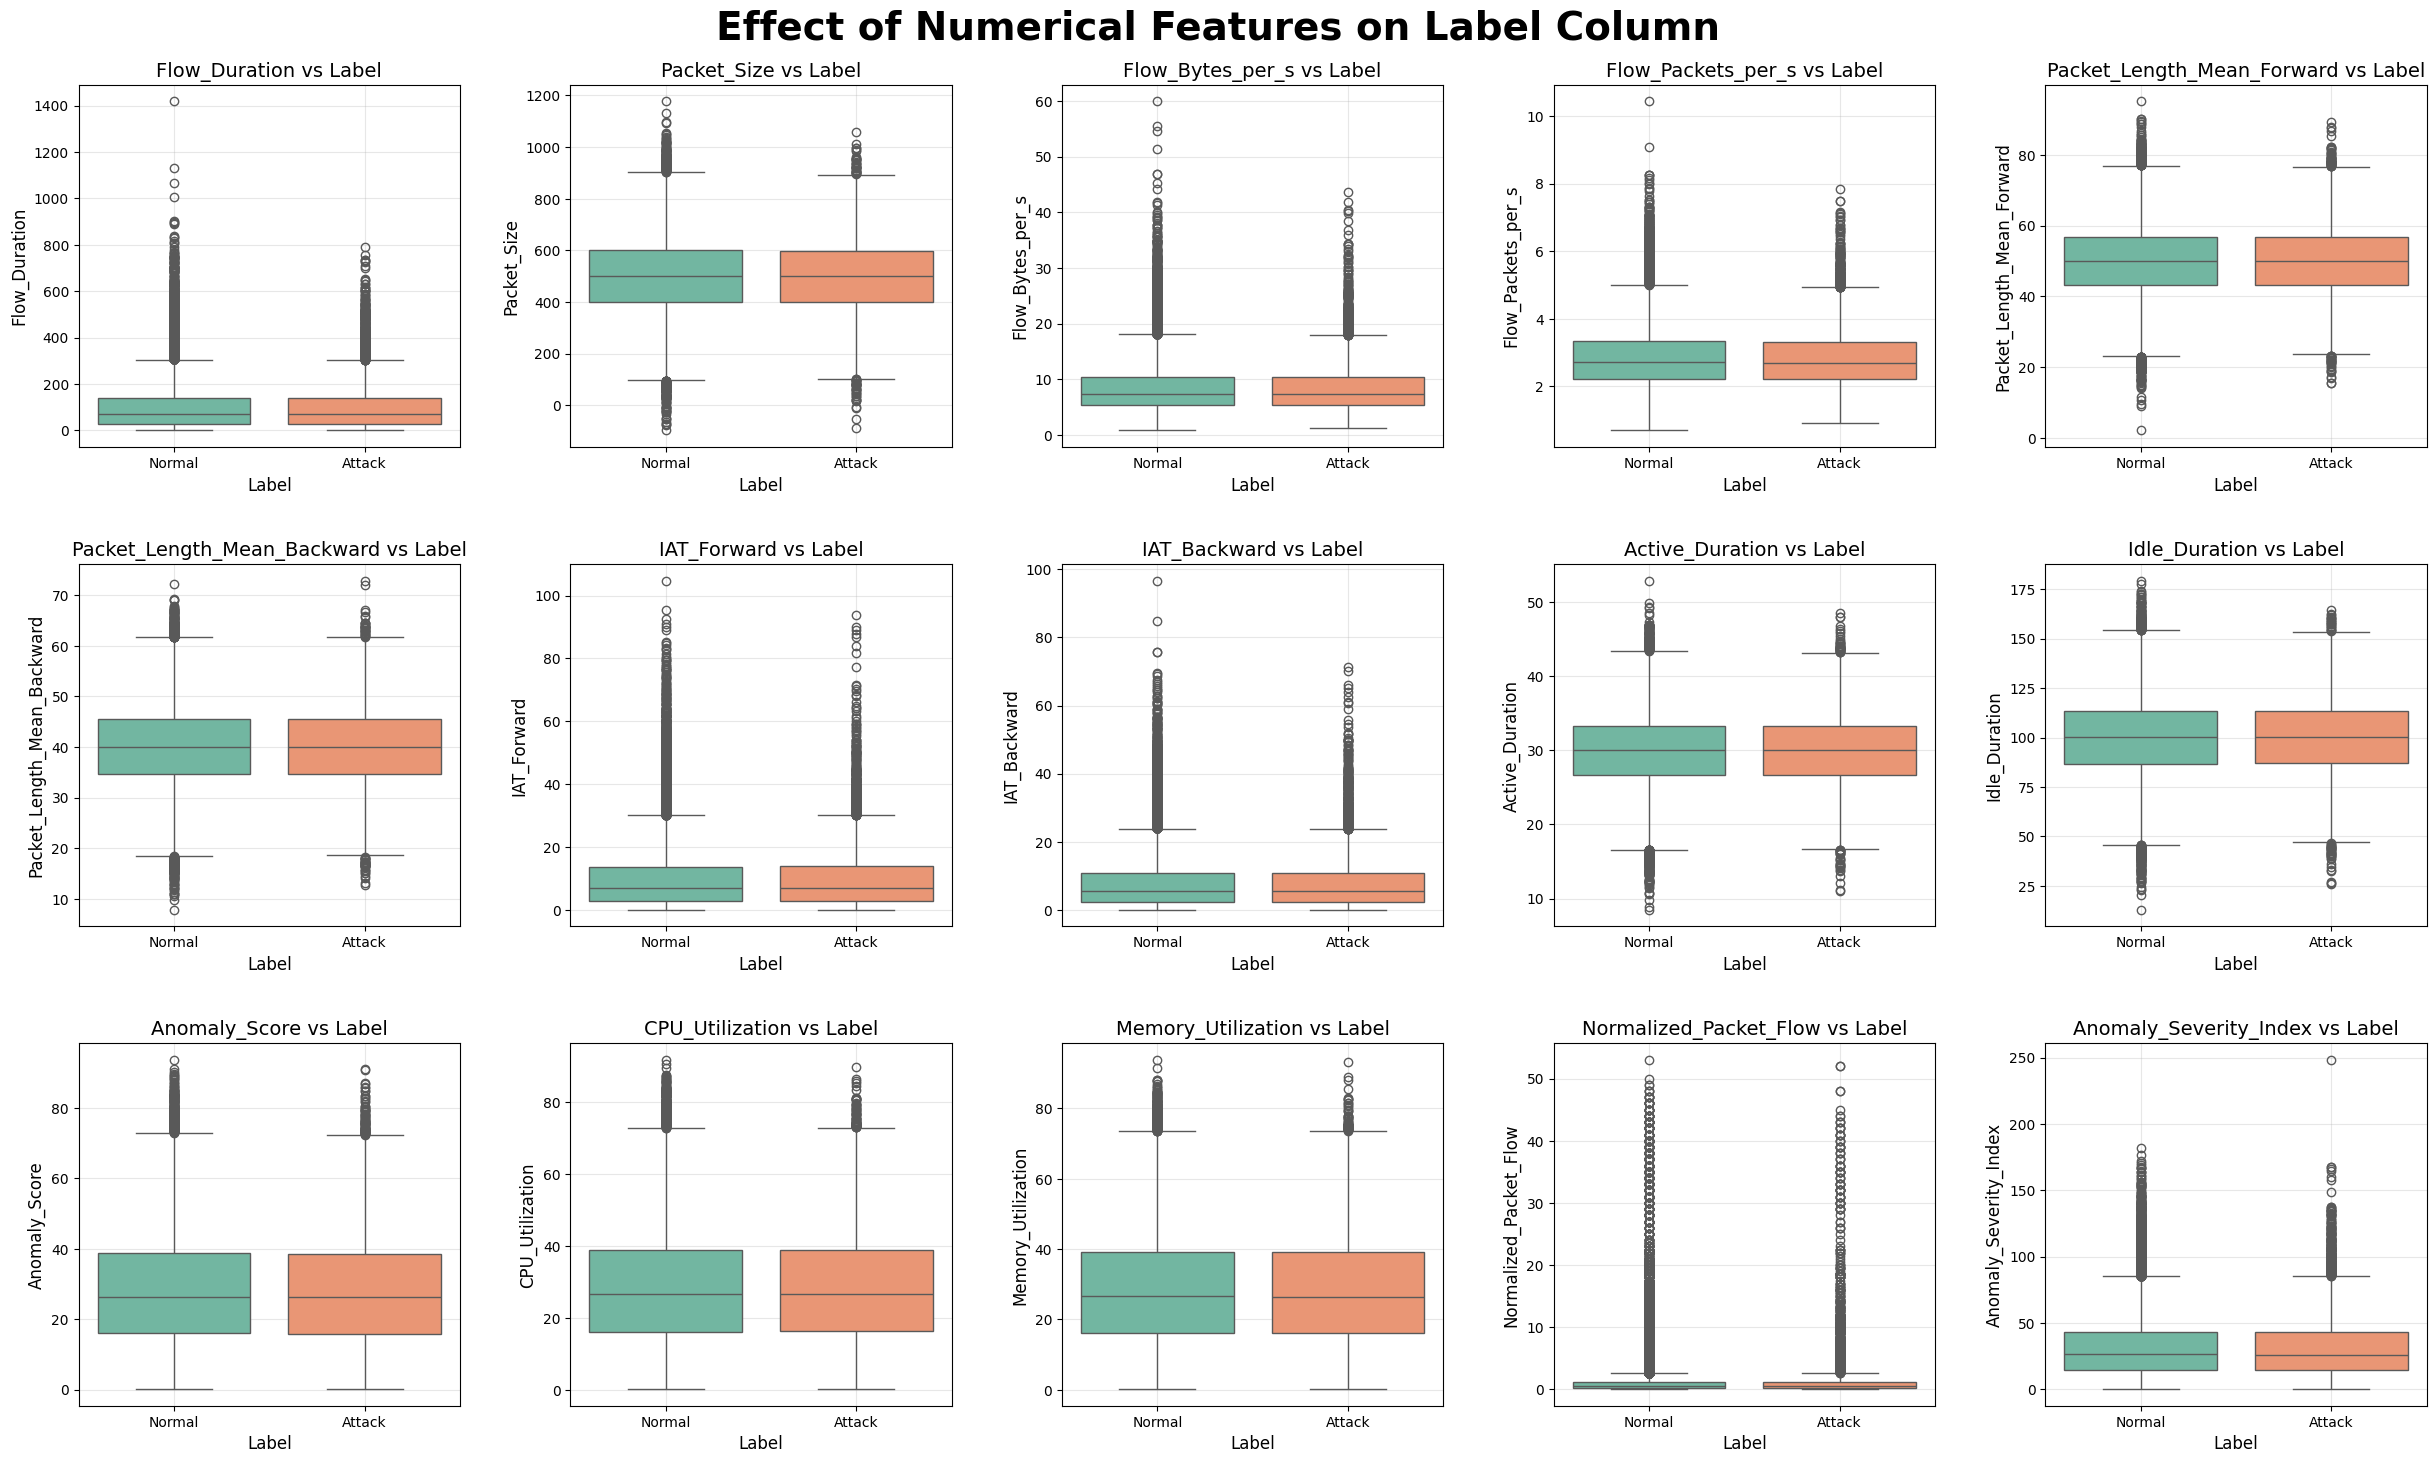

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Features to process
numerical_features = [
    'Flow_Duration', 'Packet_Size', 'Flow_Bytes_per_s', 'Flow_Packets_per_s',
    'Packet_Length_Mean_Forward','Packet_Length_Mean_Backward', 'IAT_Forward',
    'IAT_Backward', 'Active_Duration', 'Idle_Duration', 'Anomaly_Score',
    'CPU_Utilization', 'Memory_Utilization','Normalized_Packet_Flow', 'Anomaly_Severity_Index'
]

# Set number of columns per row
n_cols = 5
n_rows = int(np.ceil(len(numerical_features) / n_cols))  # Auto calculate number of rows

# Create figure and axes with wider figsize
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
plt.suptitle('Effect of Numerical Features on Label Column',
             fontsize=28, y=0.99, weight='bold')

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each boxplot
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Label', y=feature, data=df, ax=axes[i], palette="Set2")
    axes[i].set_title(f'{feature} vs Label', fontsize=14)
    axes[i].set_xlabel('Label', fontsize=12)
    axes[i].set_ylabel(feature, fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.94)
plt.show()


/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


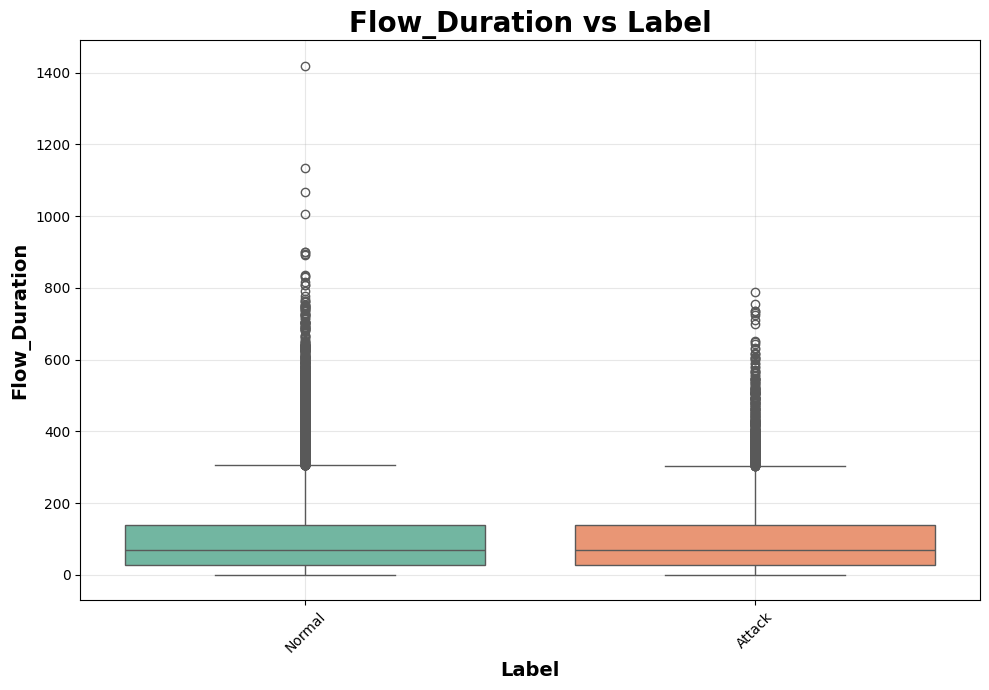

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


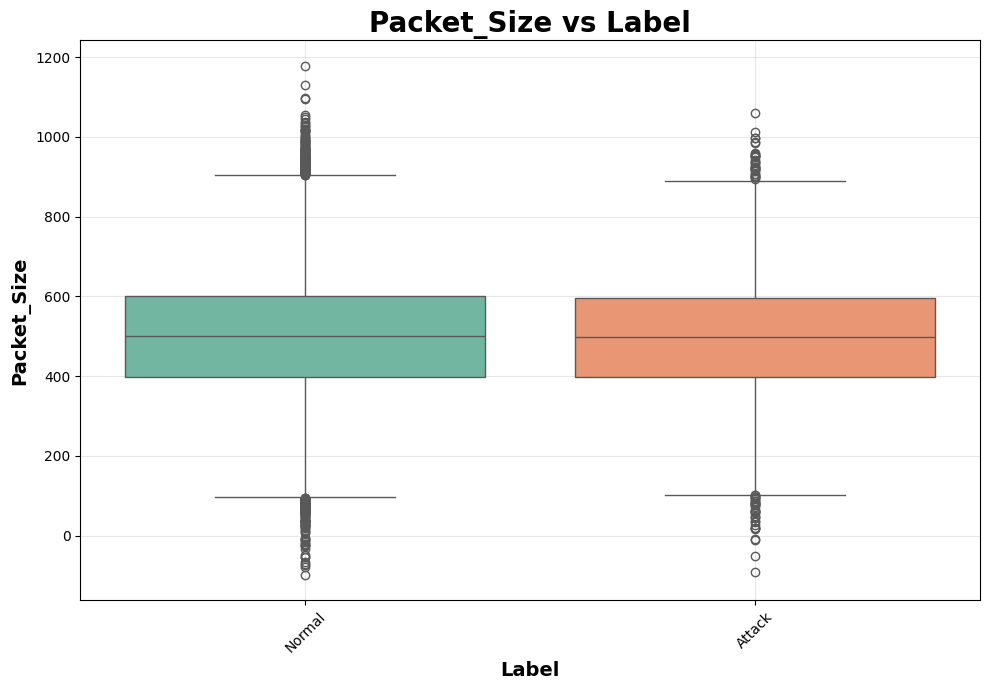

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


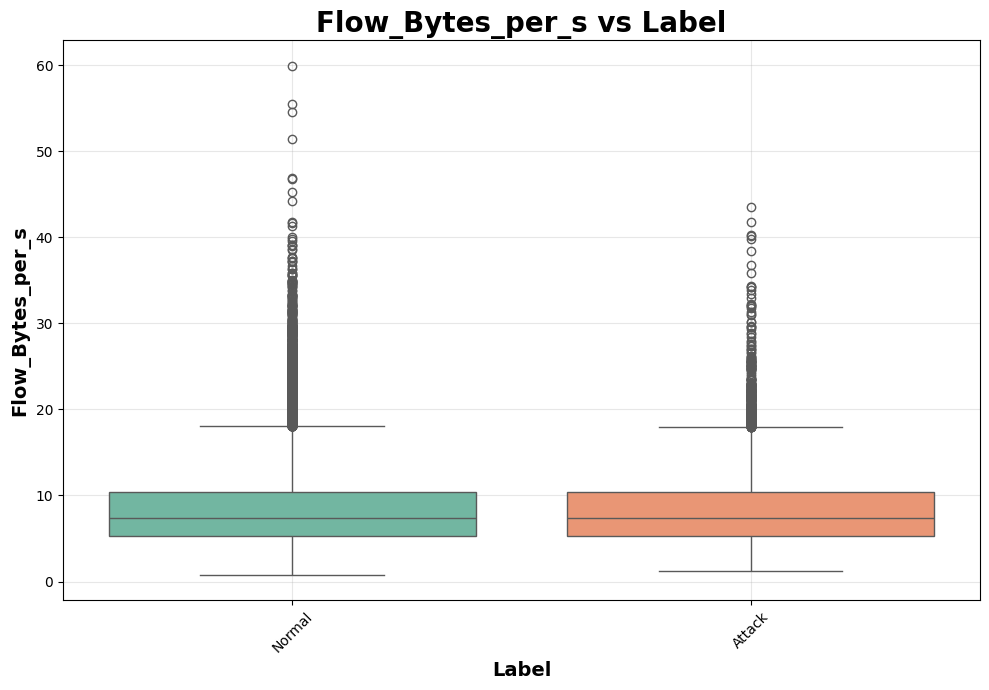

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


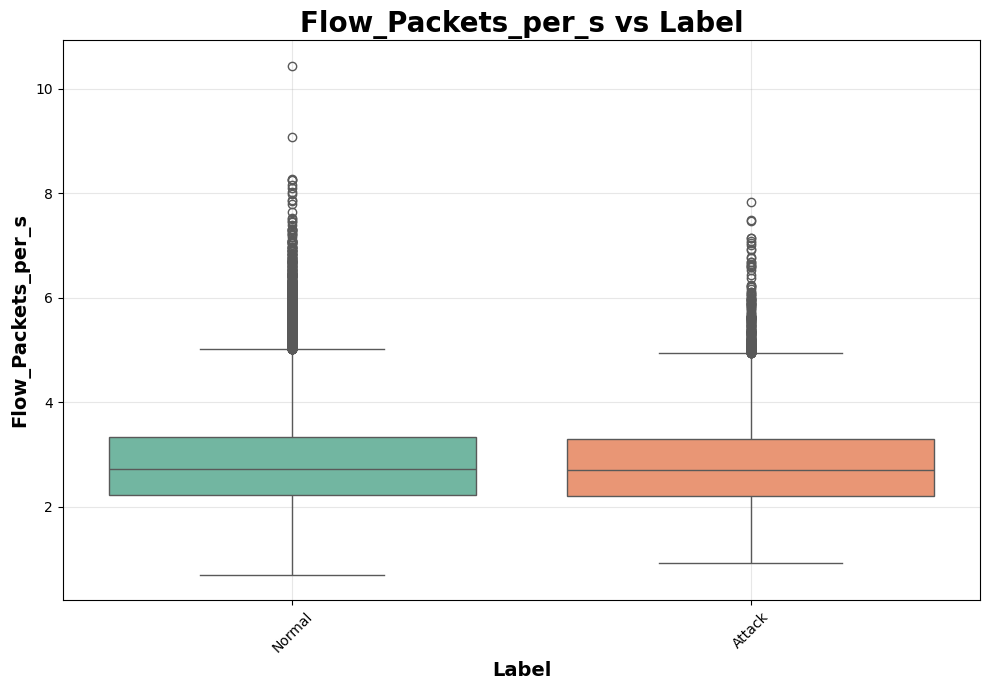

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


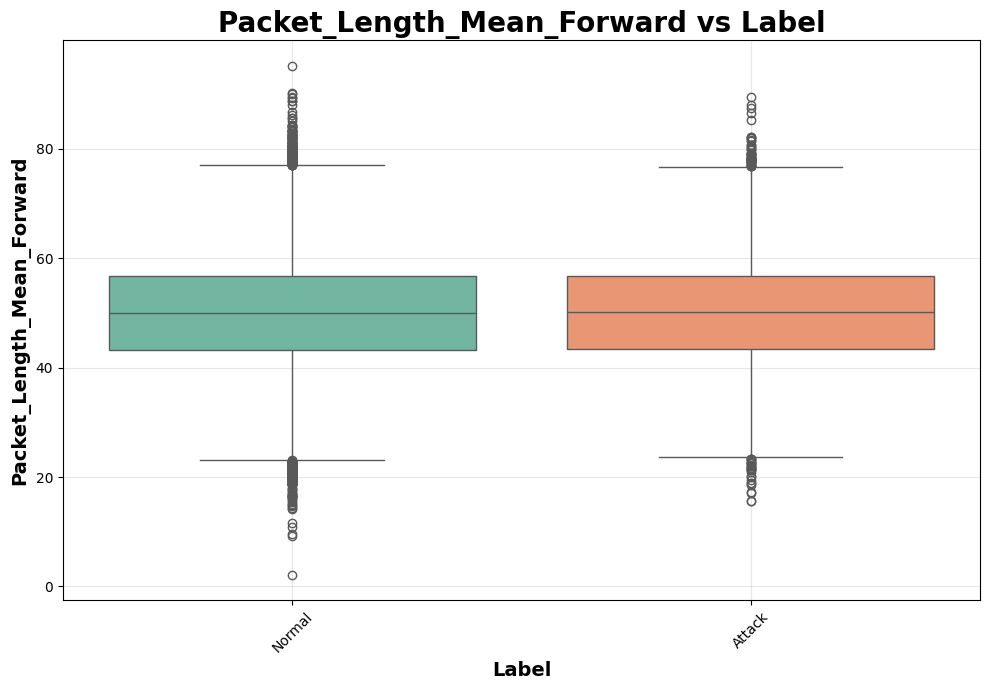

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


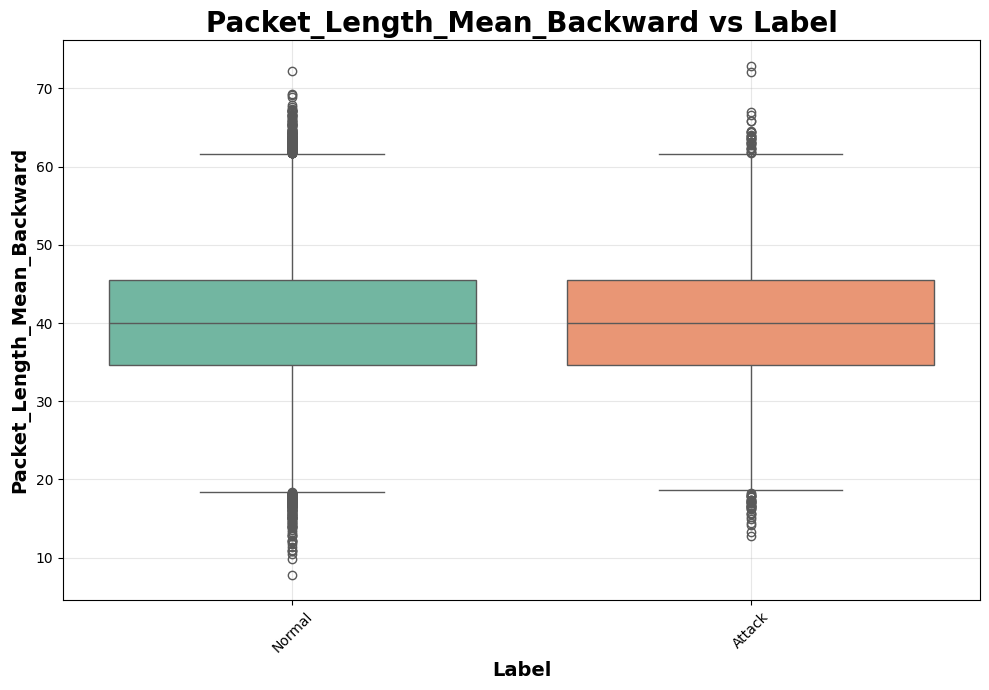

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


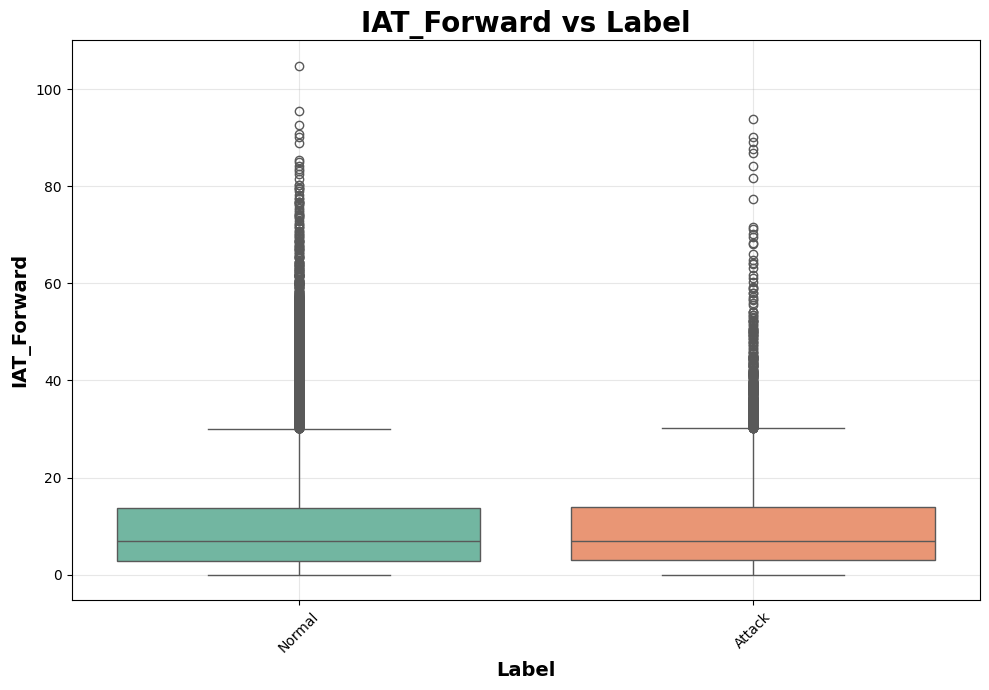

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


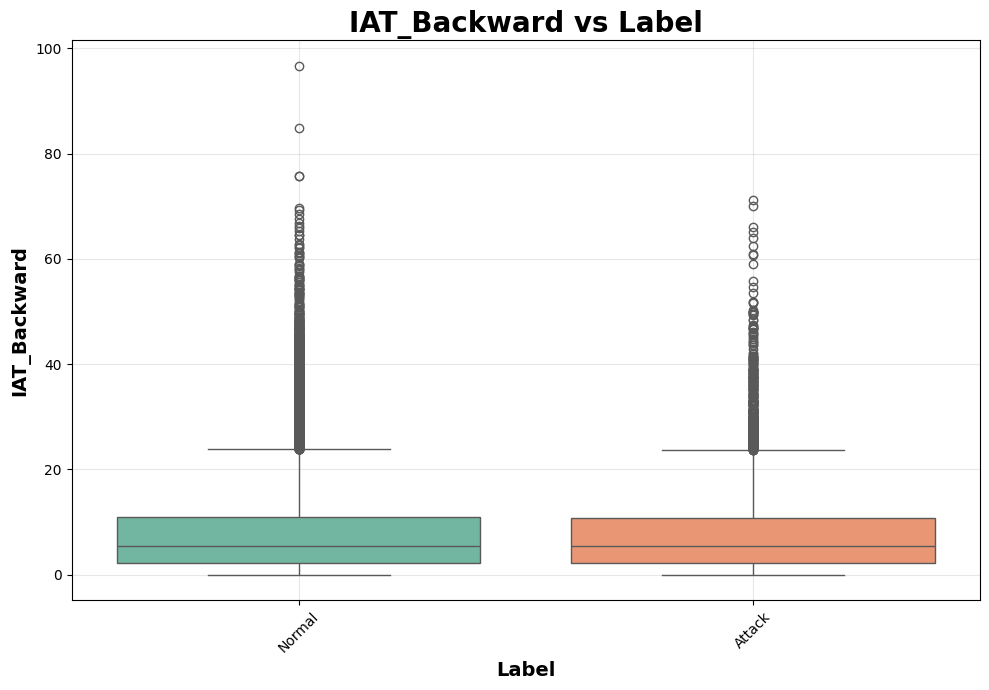

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


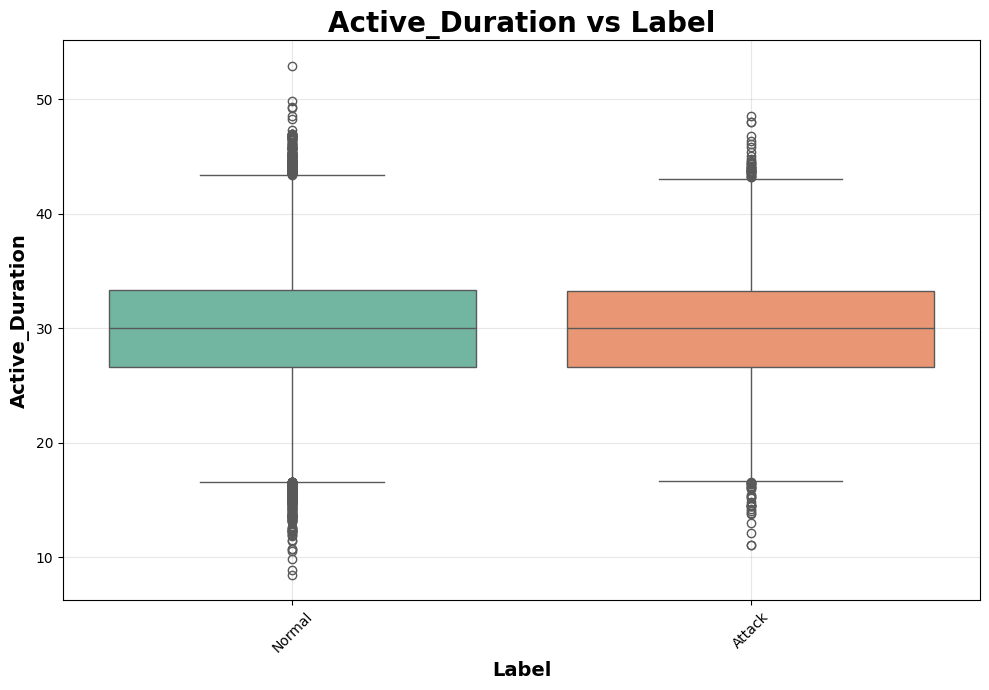

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


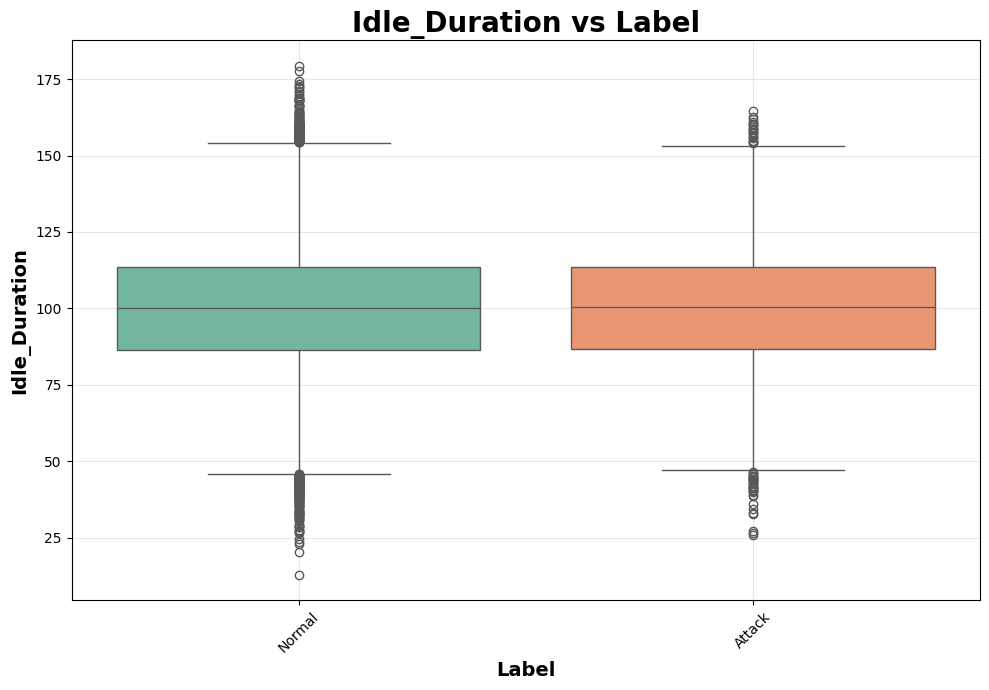

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


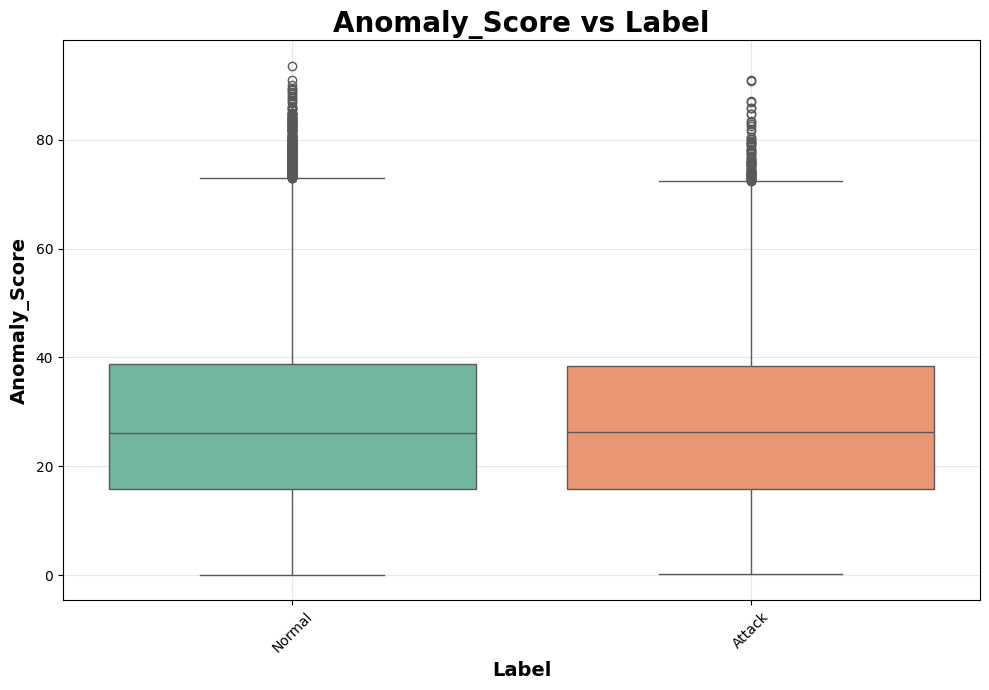

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


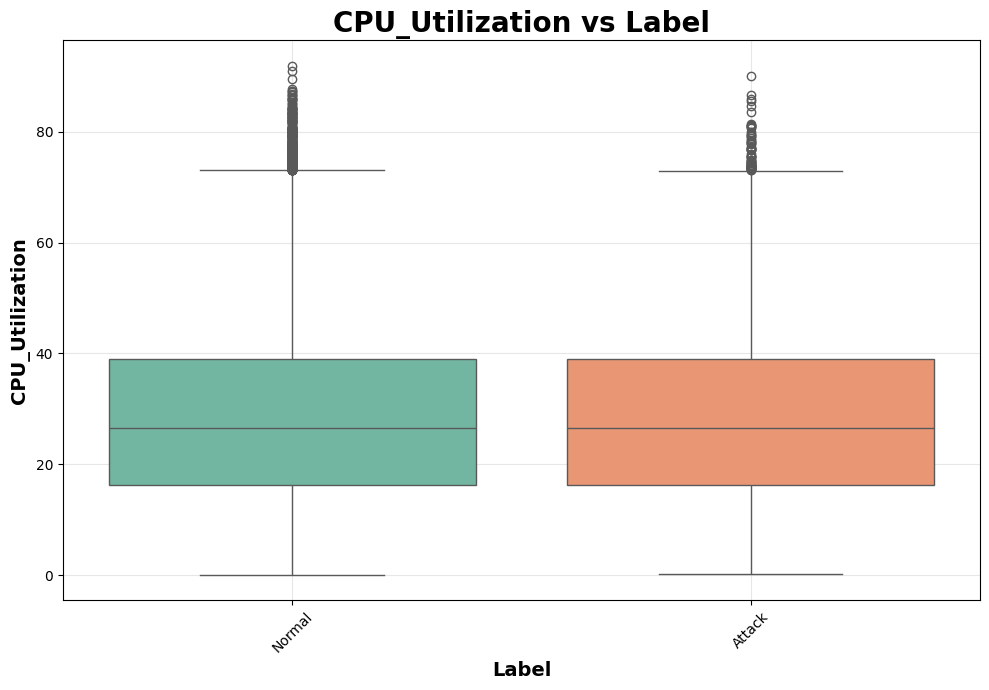

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


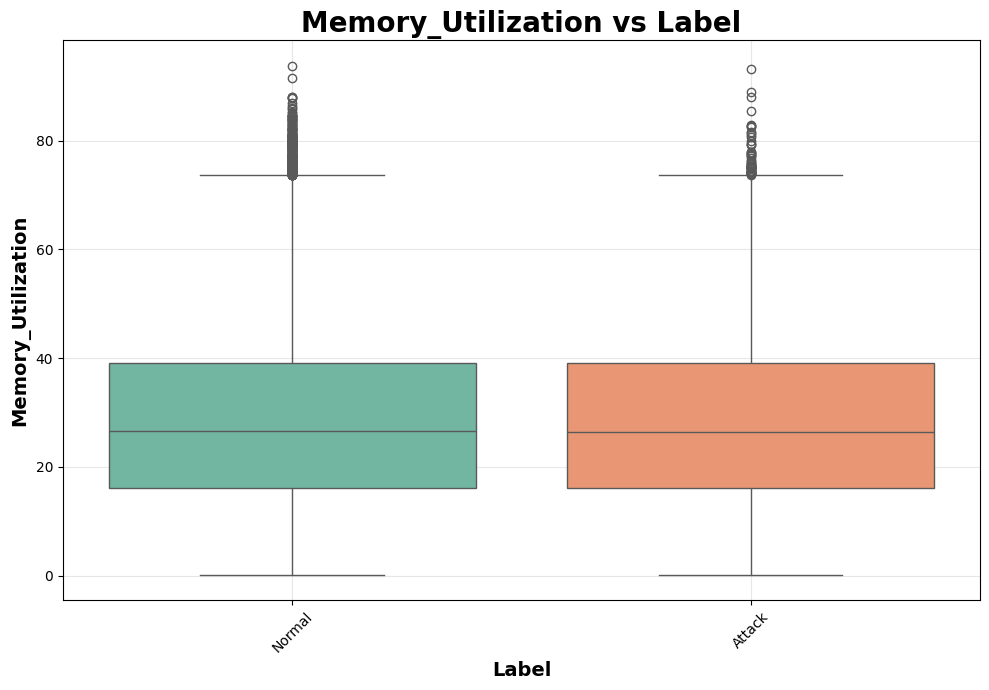

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


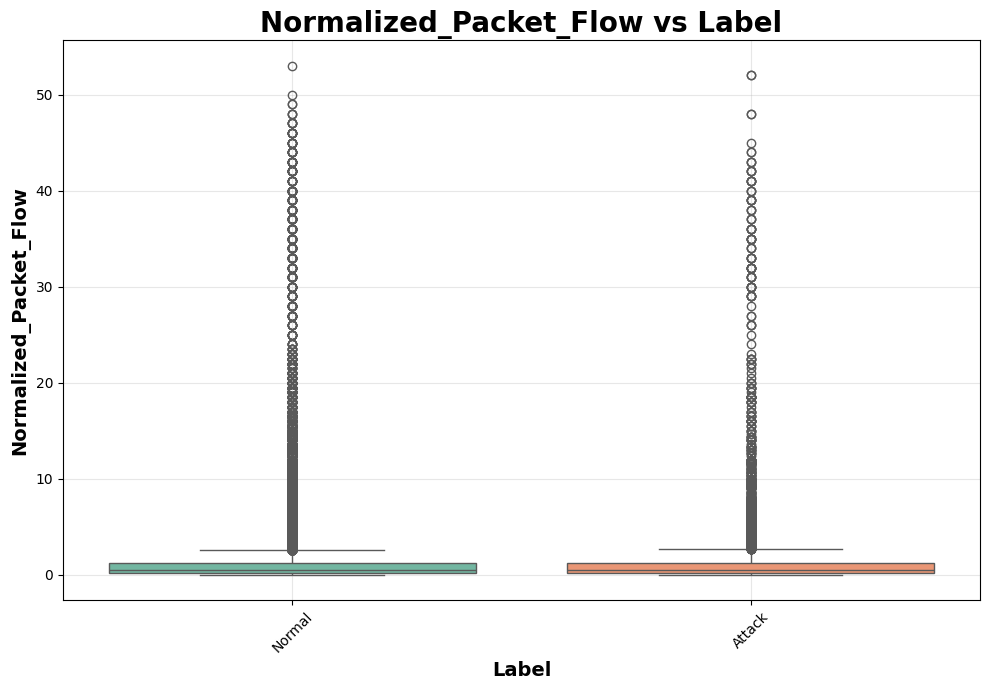

/tmp/ipython-input-2031814131.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y=feature, data=df, palette="Set2")


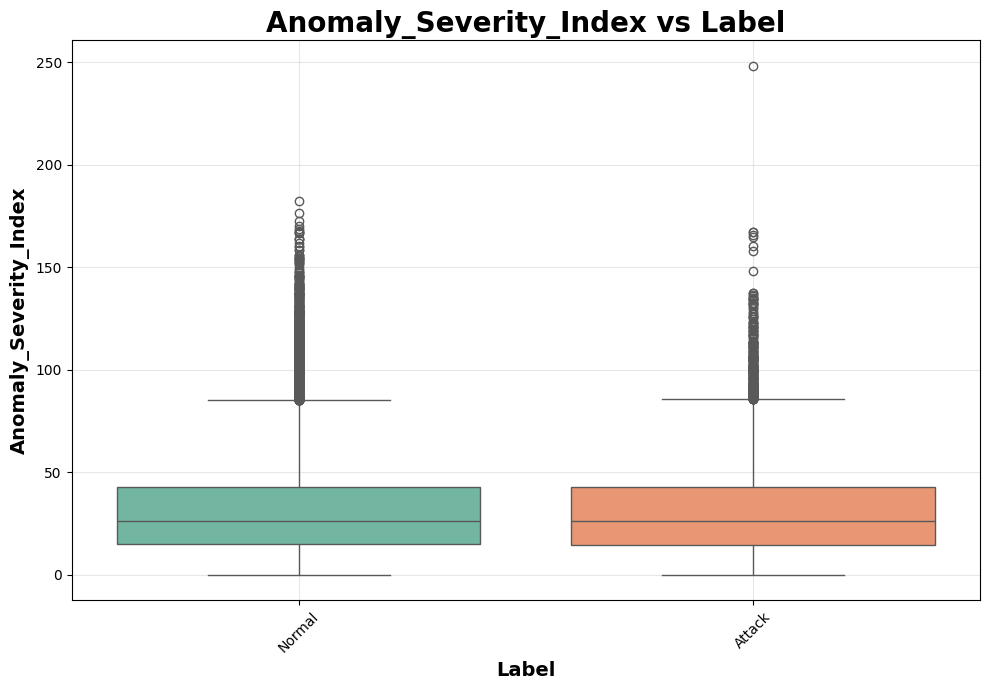

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Features to process
numerical_features = [
    'Flow_Duration', 'Packet_Size', 'Flow_Bytes_per_s', 'Flow_Packets_per_s',
    'Packet_Length_Mean_Forward','Packet_Length_Mean_Backward', 'IAT_Forward',
    'IAT_Backward', 'Active_Duration', 'Idle_Duration', 'Anomaly_Score',
    'CPU_Utilization', 'Memory_Utilization','Normalized_Packet_Flow', 'Anomaly_Severity_Index'
]

for feature in numerical_features:
    plt.figure(figsize=(10, 7))
    sns.boxplot(x='Label', y=feature, data=df, palette="Set2")
    plt.title(f'{feature} vs Label', fontsize=20, weight='bold')
    plt.xlabel('Label', fontsize=14, weight='bold')
    plt.ylabel(feature, fontsize=14, weight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


**Distribution of All Numerical Features by Label**

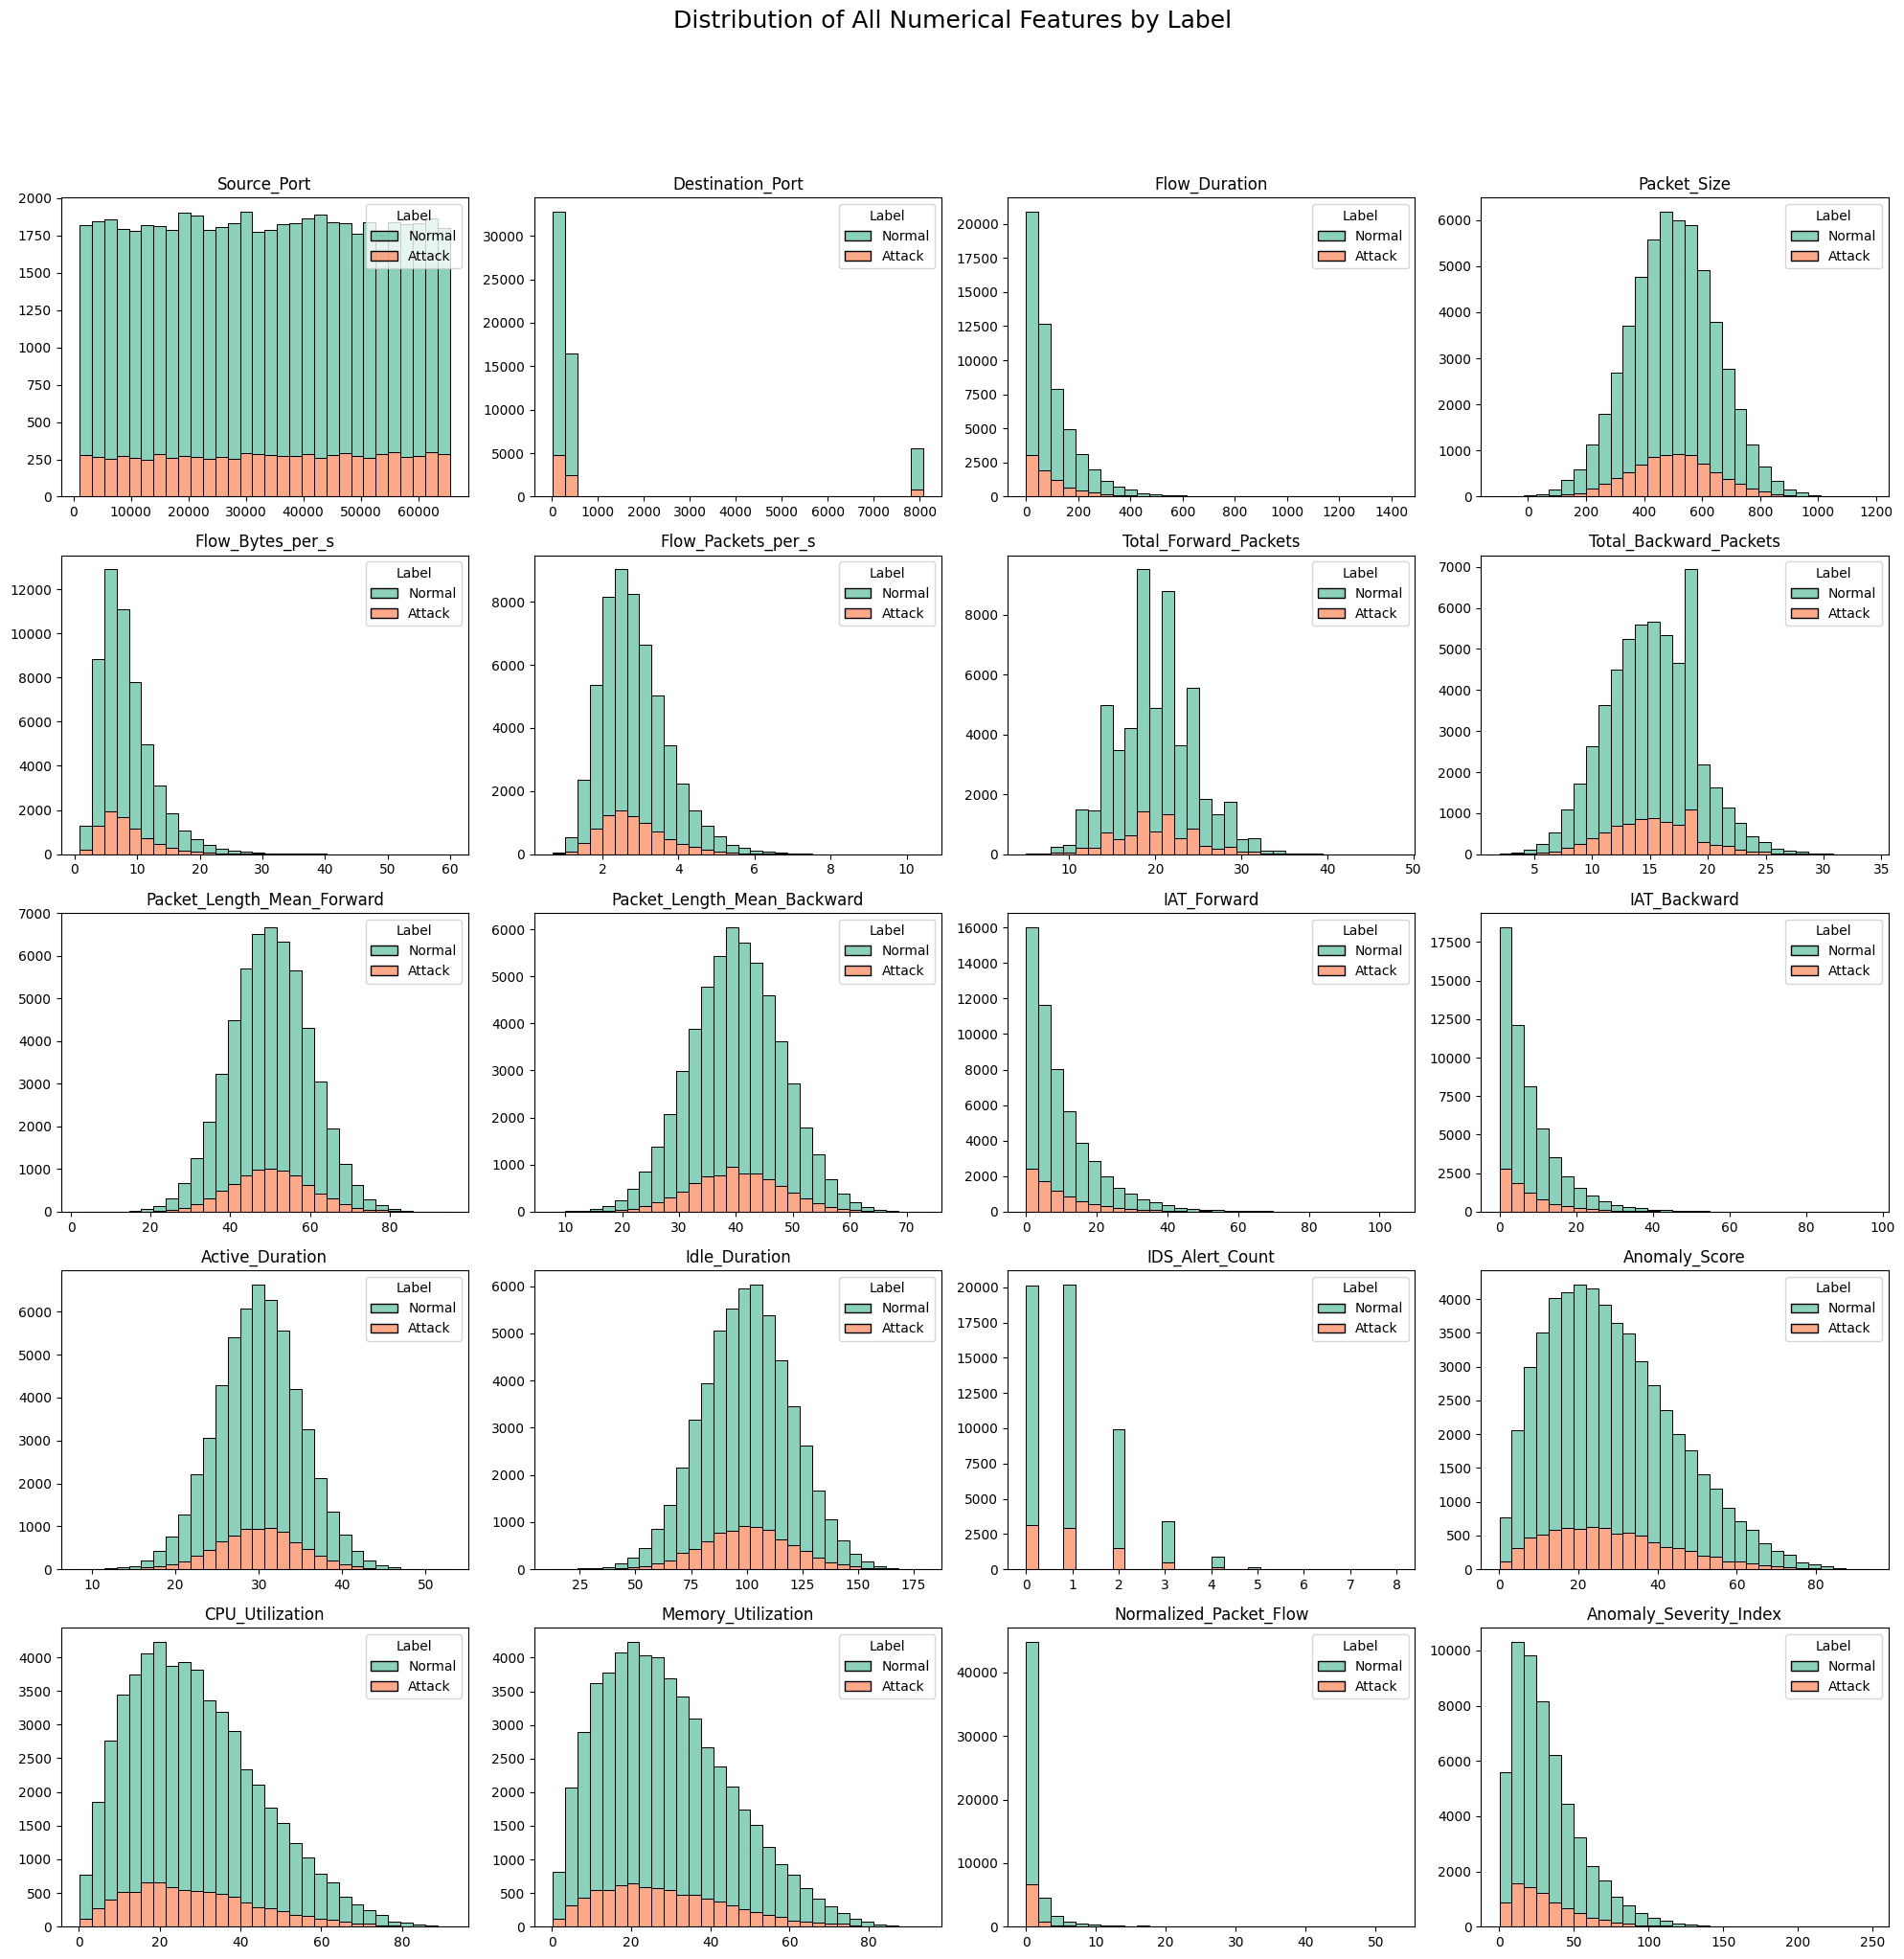

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select all numeric features (excluding the target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Label' in numeric_cols:
    numeric_cols.remove('Label')  # Exclude target if it's numeric

# Grid size setup
num_cols = 4
num_rows = -(-len(numeric_cols) // num_cols)  # Ceiling division

# Create plots
plt.figure(figsize=(20, 4 * num_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data=df, x=col, hue="Label", multiple="stack", bins=30, palette="Set2", kde=False)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")

# Final layout
plt.suptitle("Distribution of All Numerical Features by Label", fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


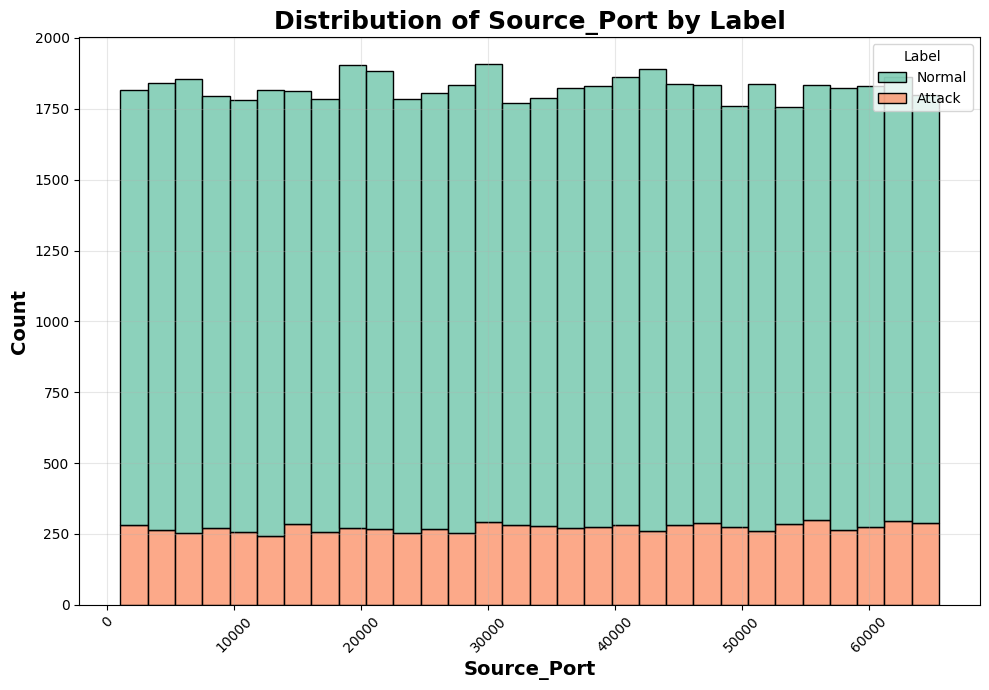

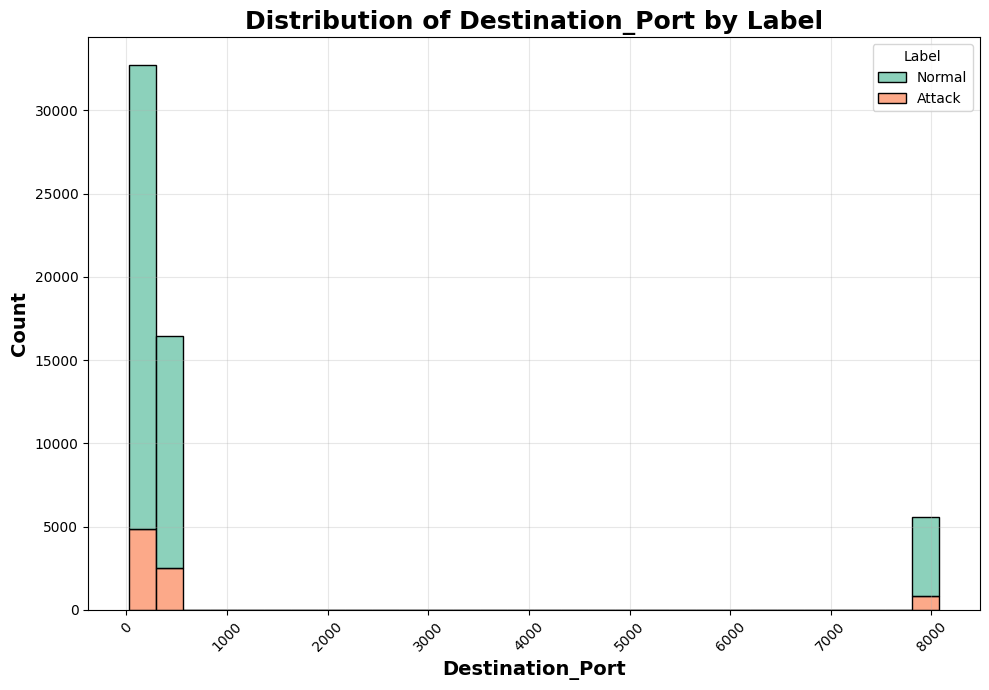

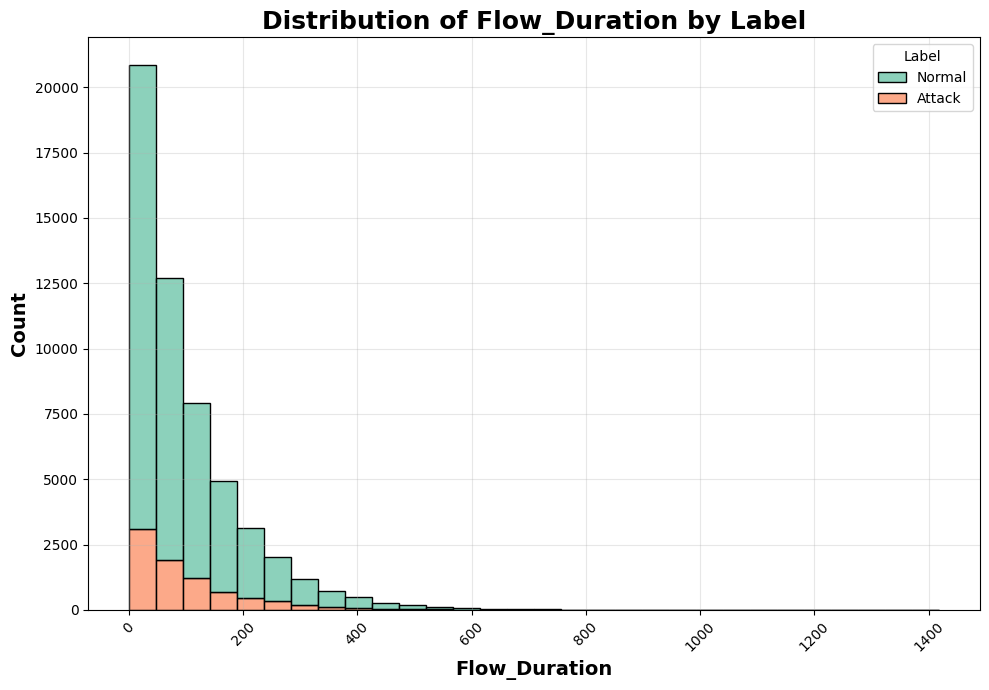

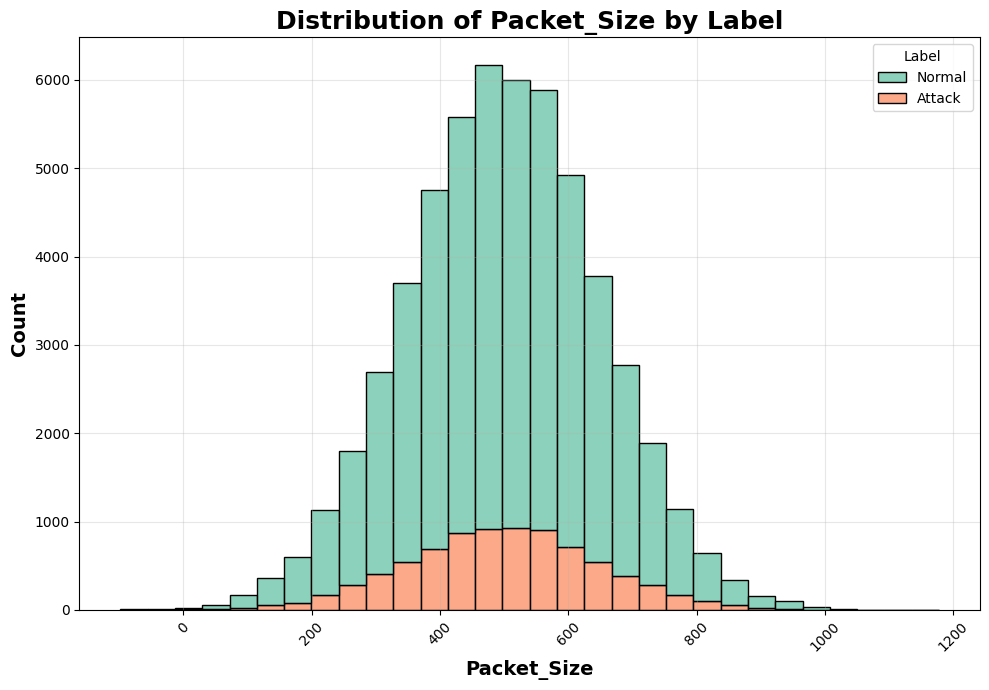

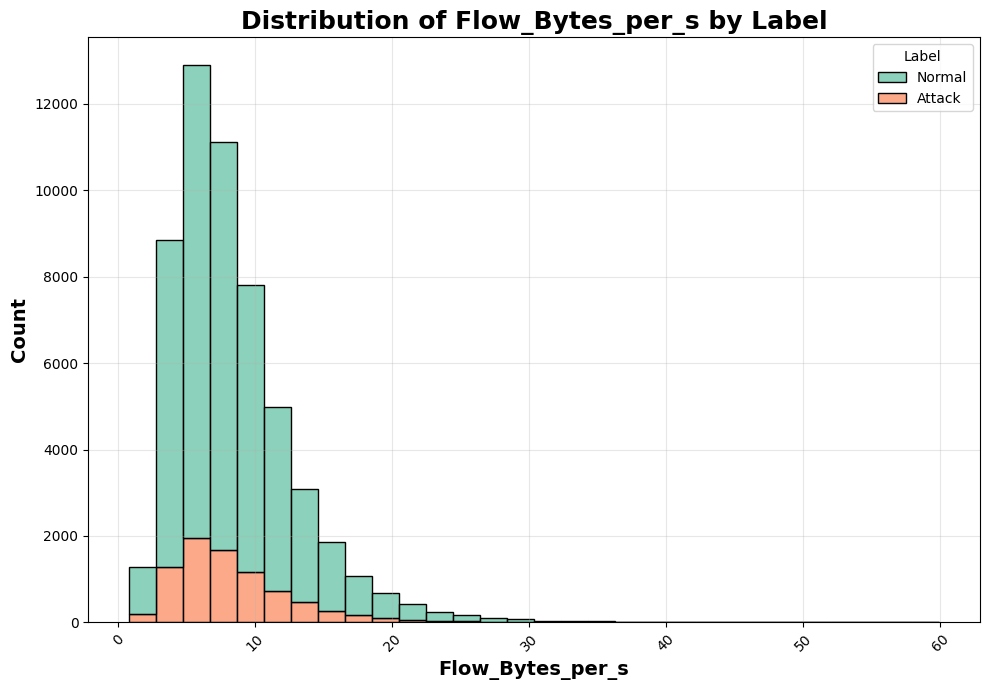

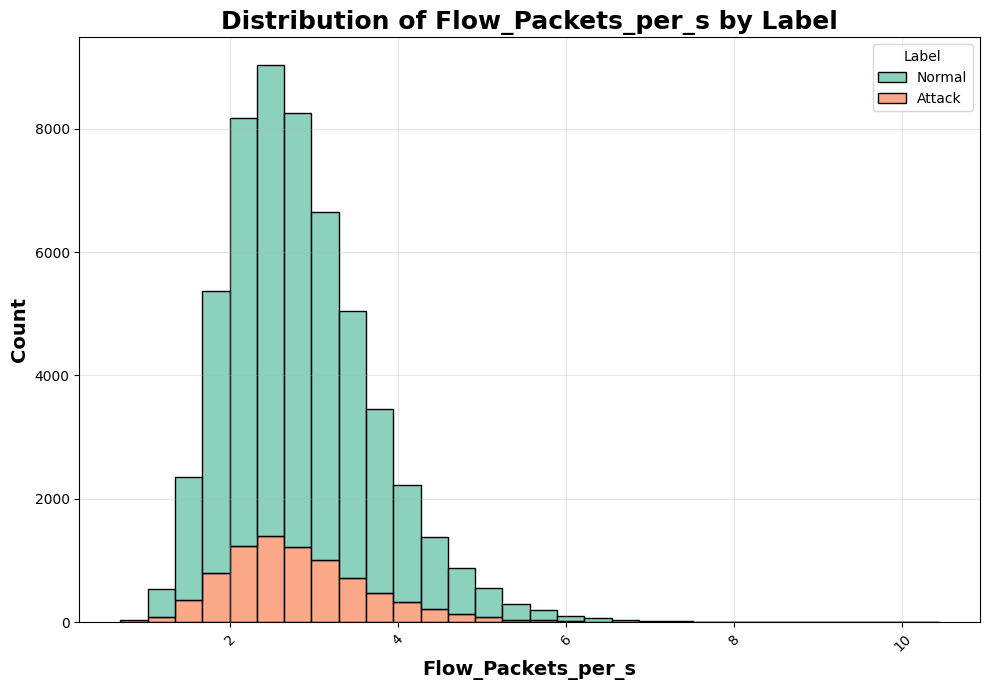

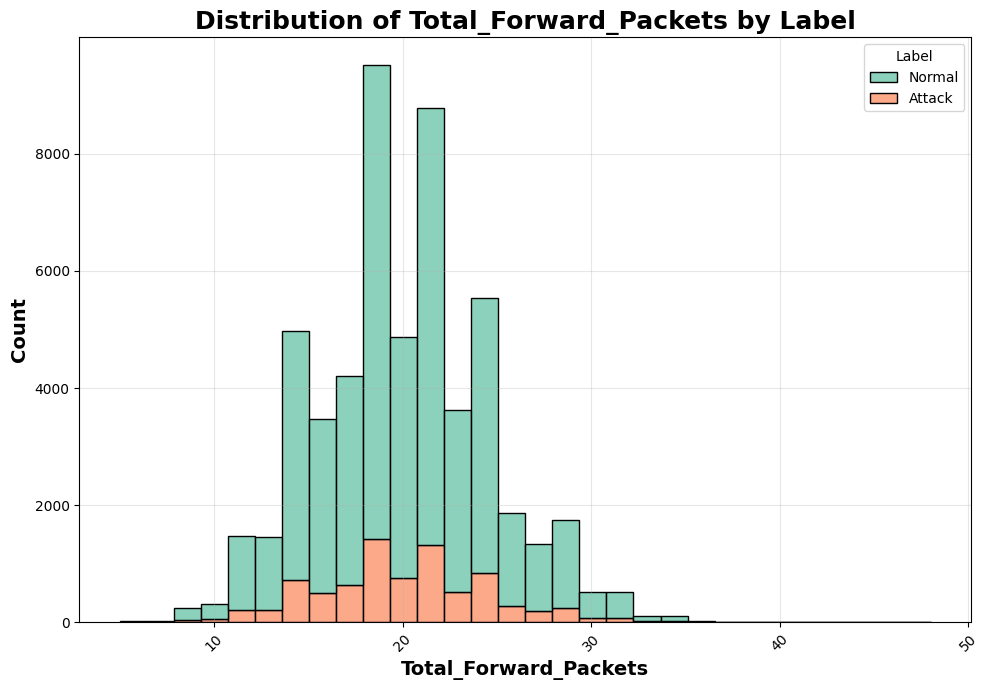

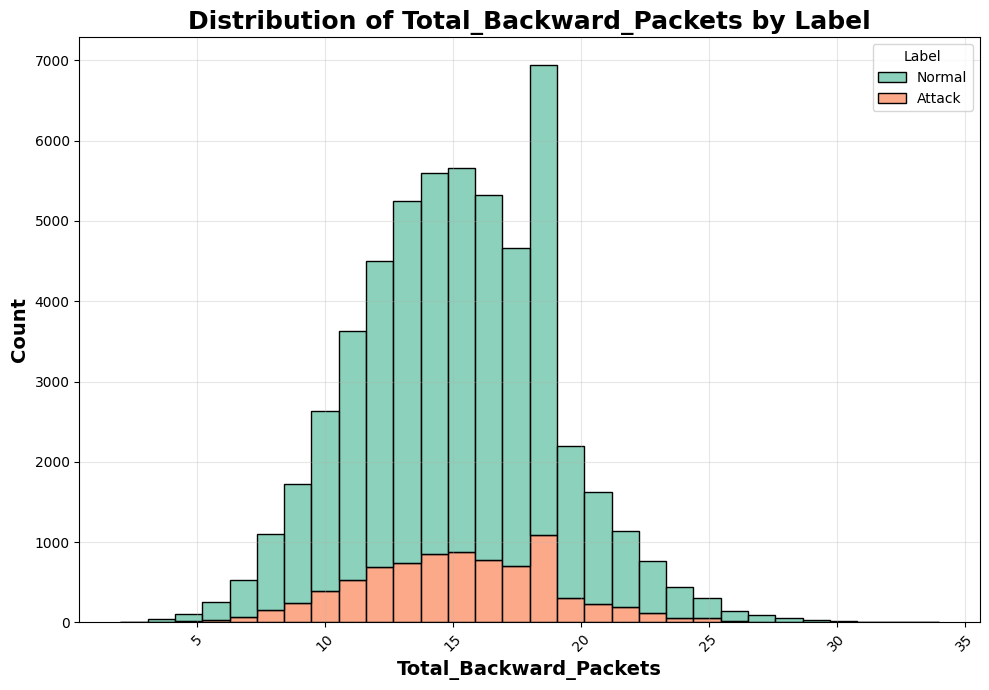

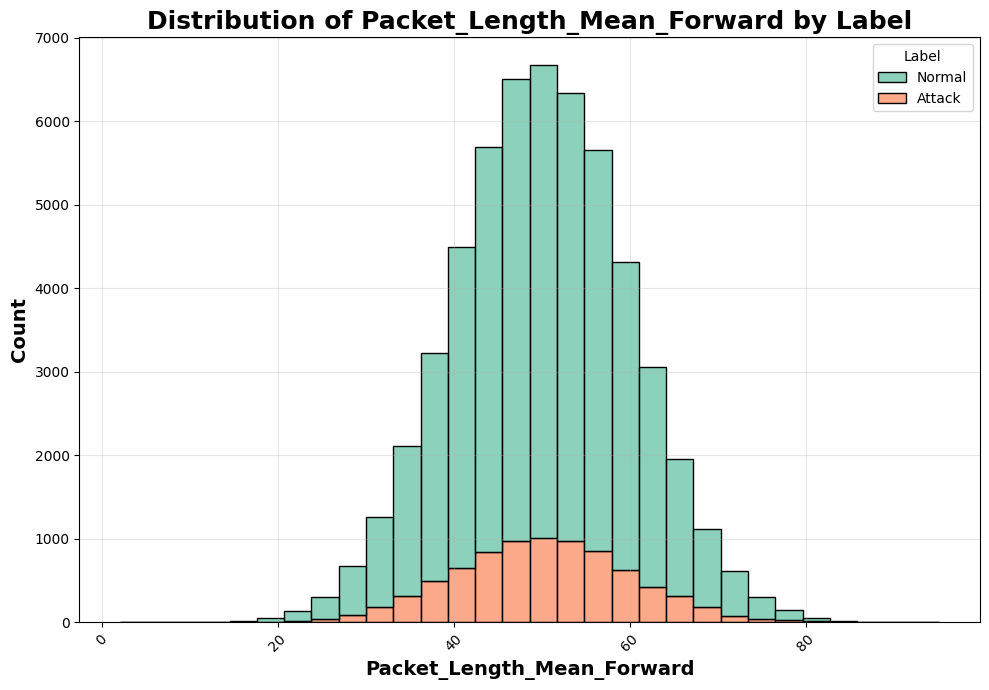

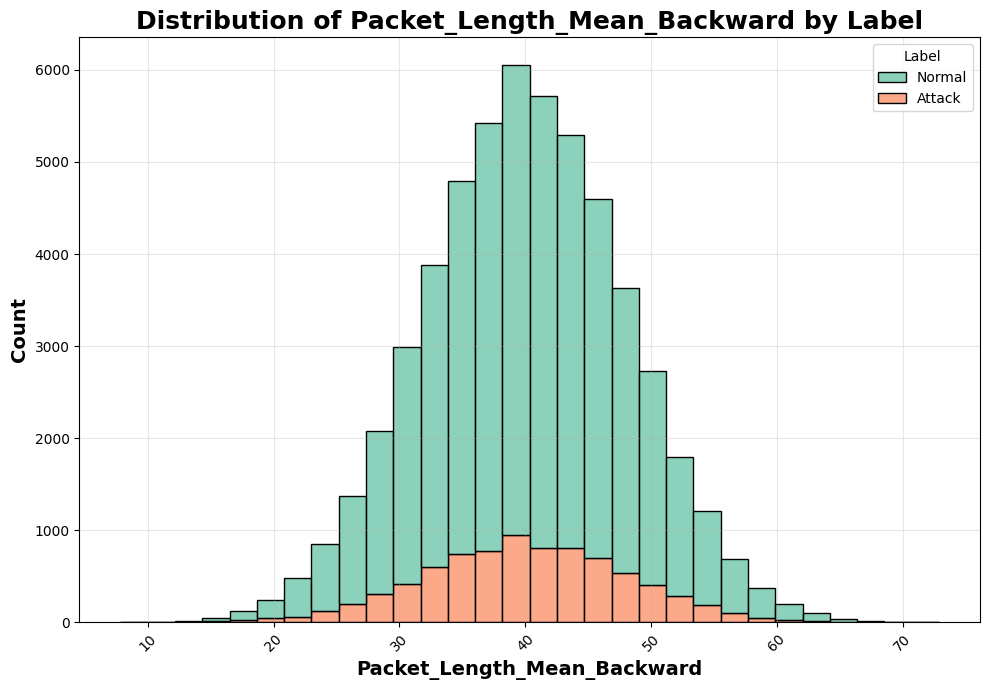

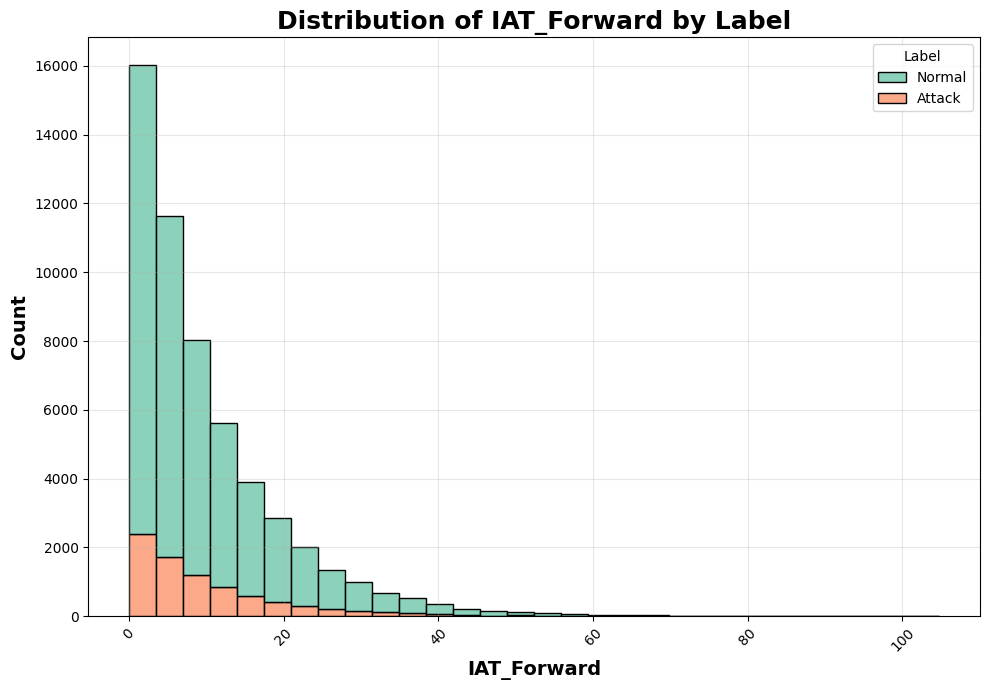

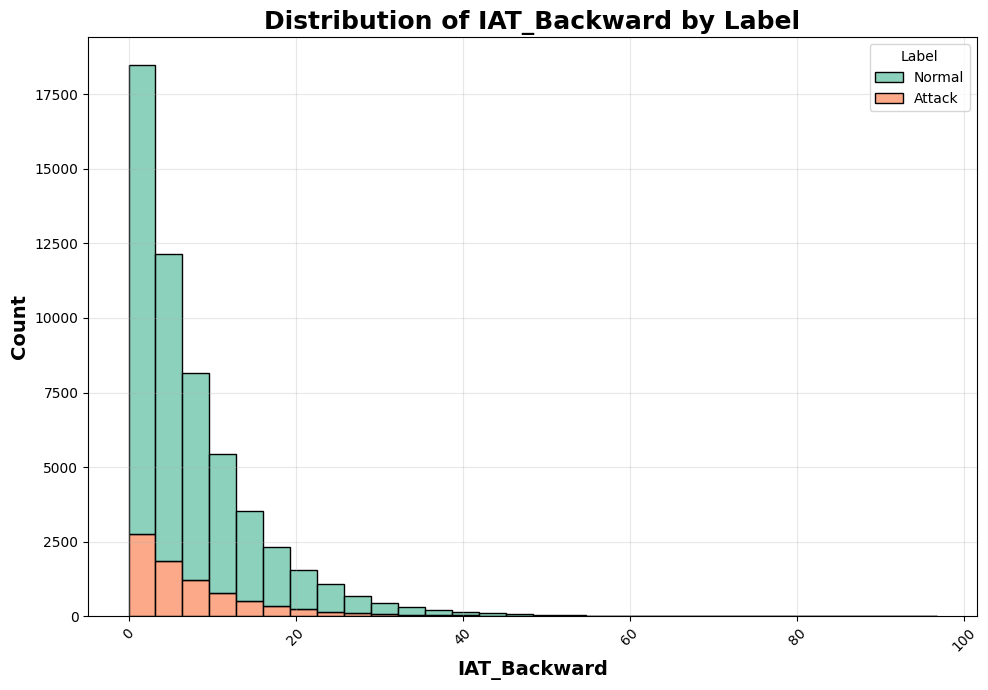

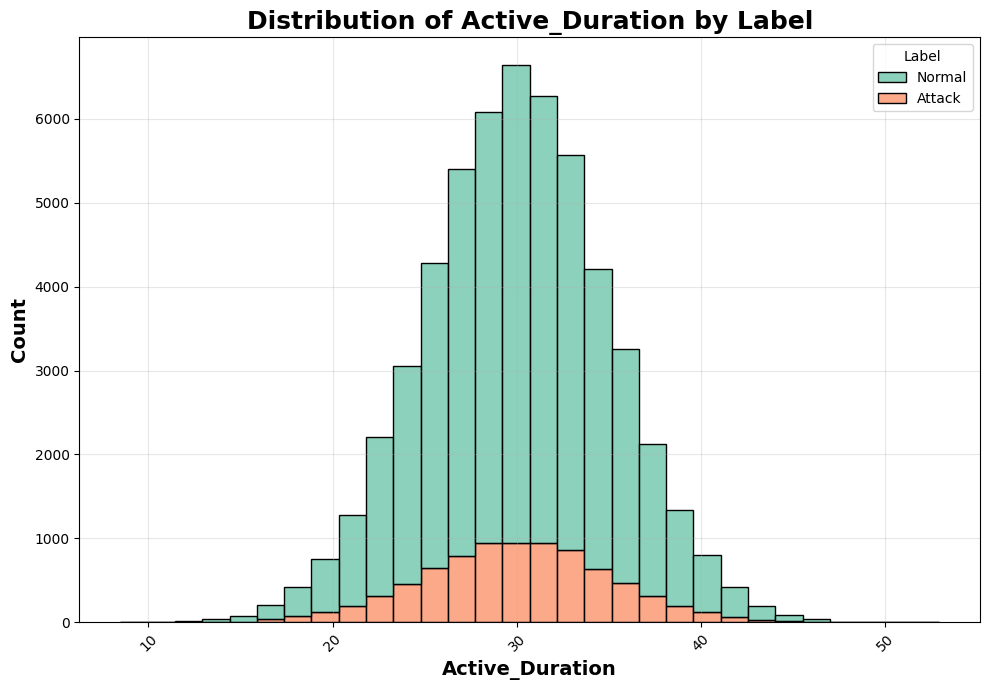

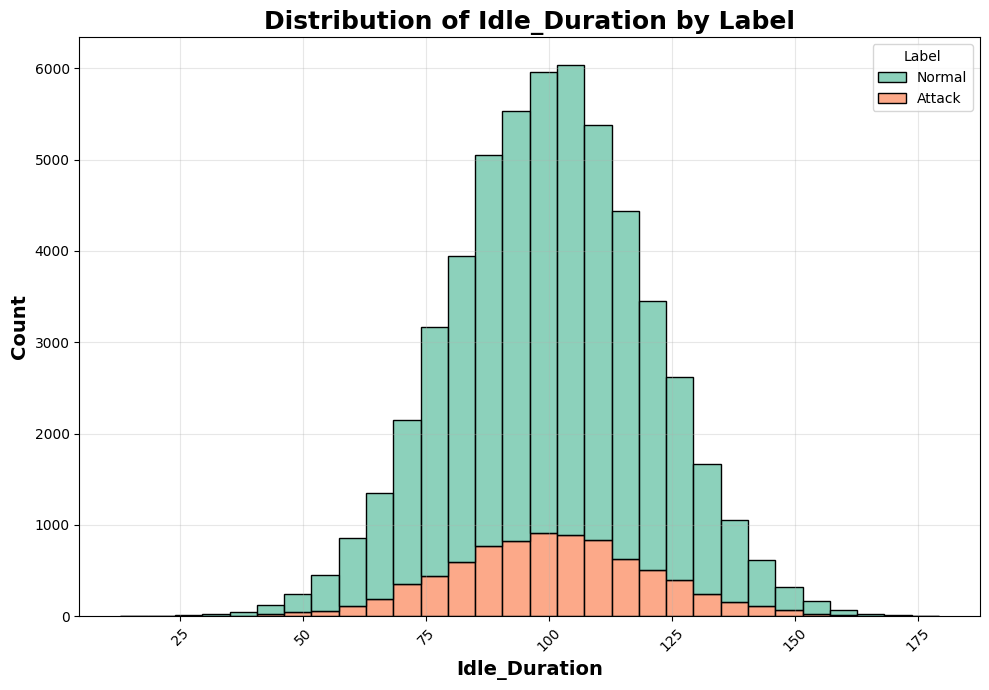

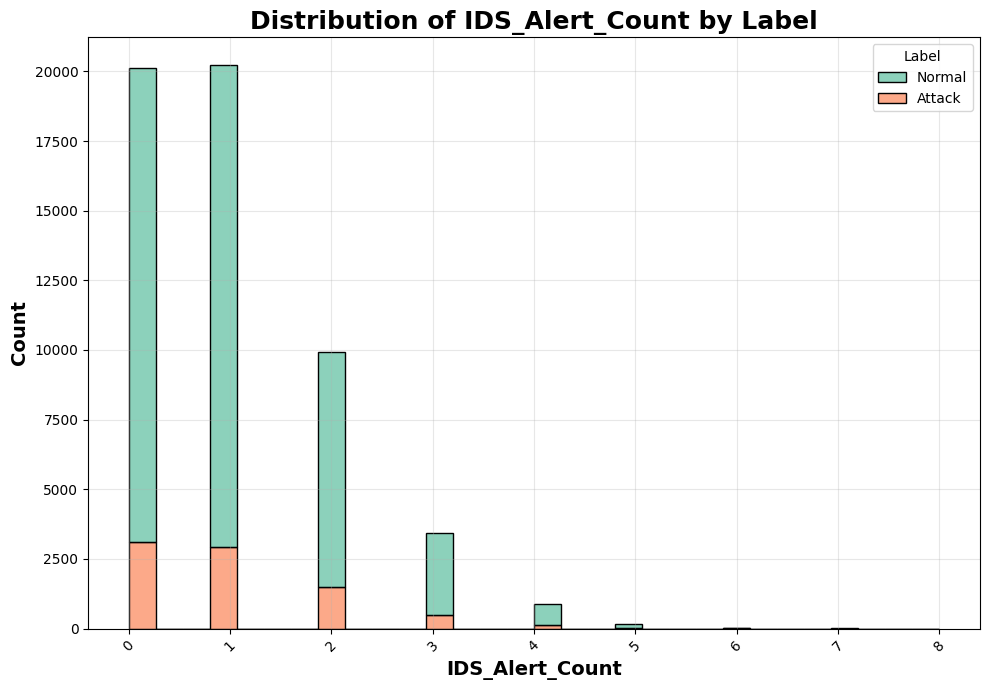

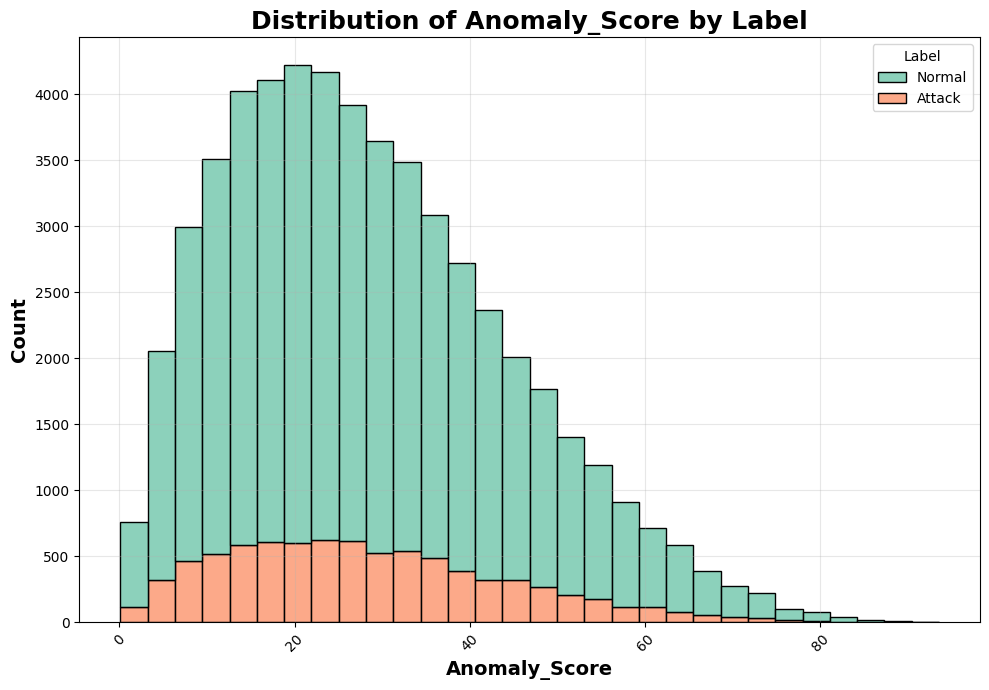

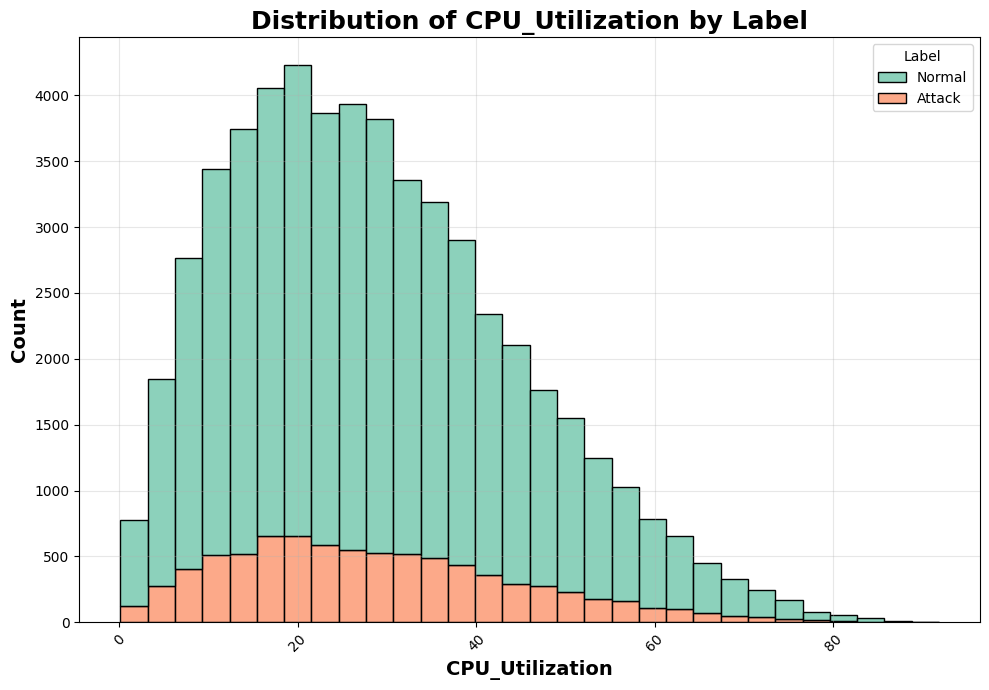

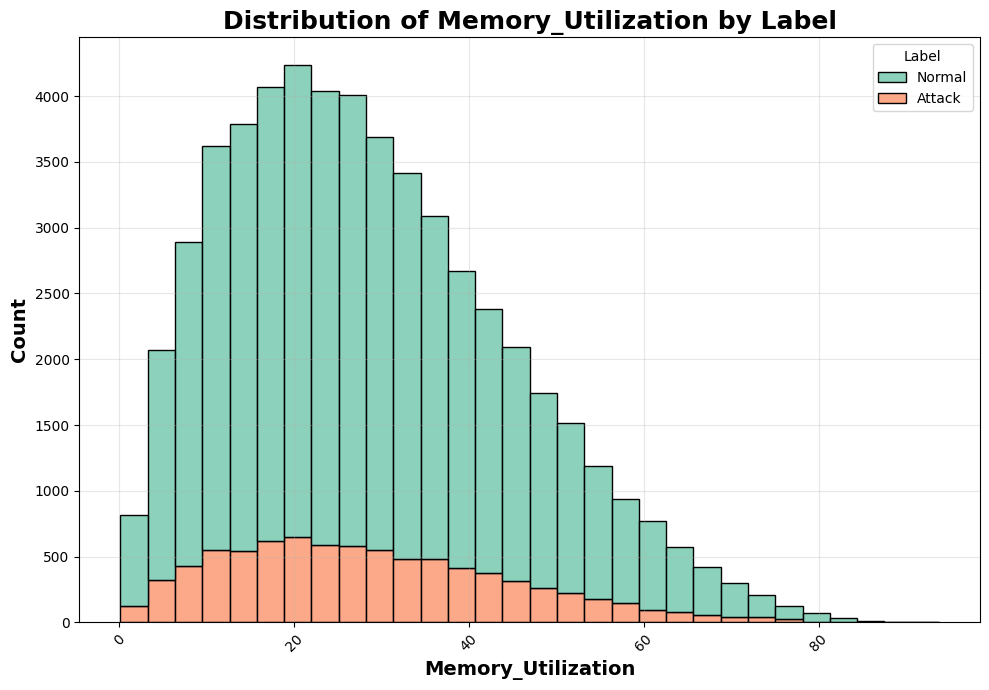

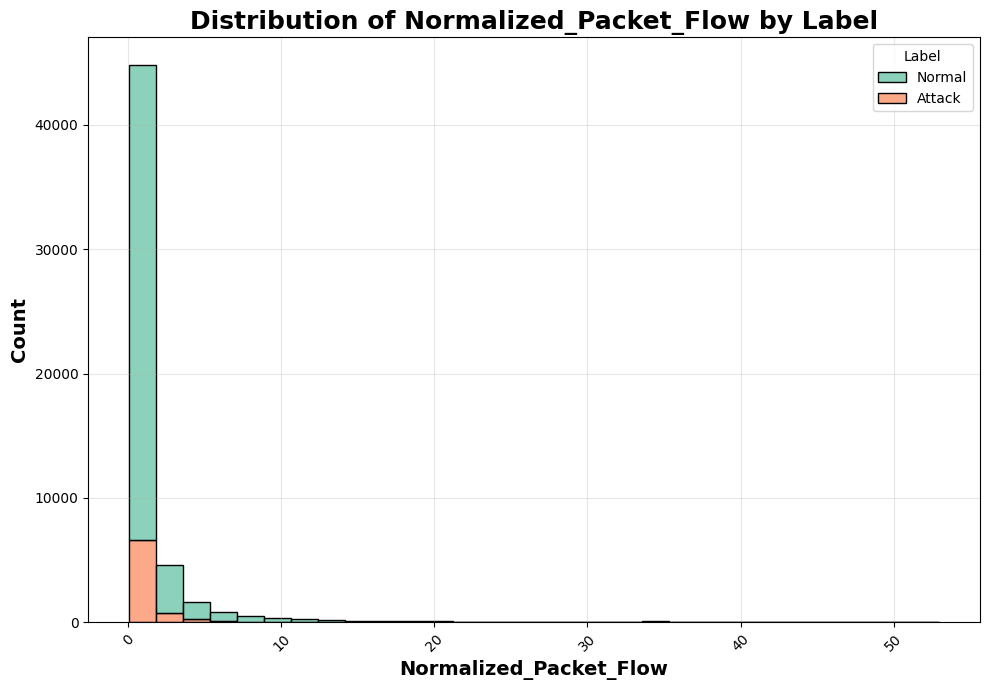

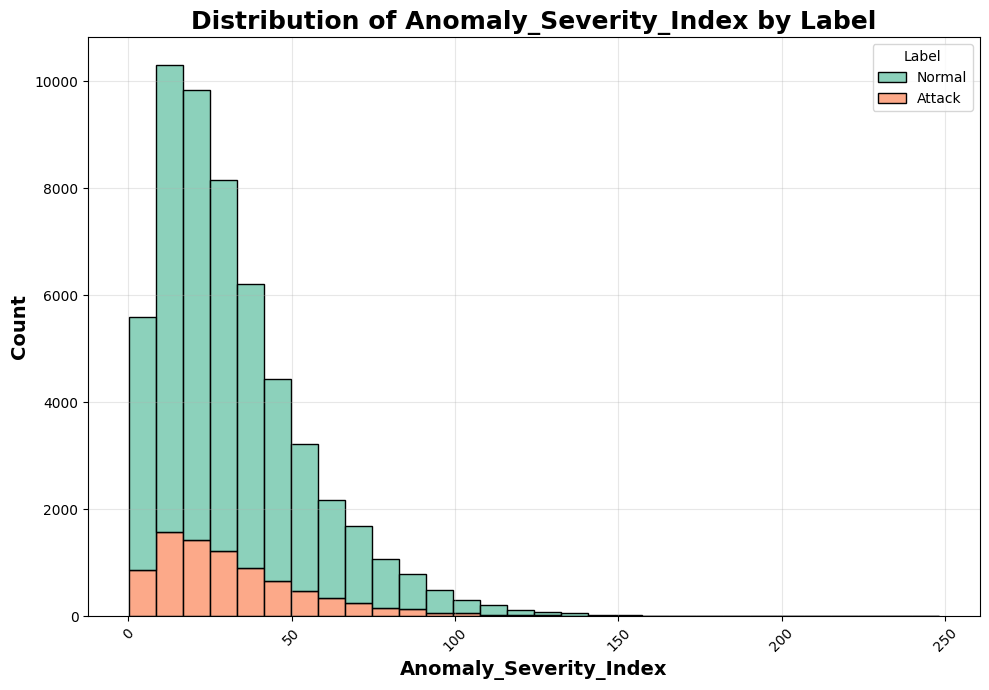

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select all numeric features (excluding the target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Label' in numeric_cols:
    numeric_cols.remove('Label')  # Exclude target if it's numeric

# Create separate plots
for col in numeric_cols:
    plt.figure(figsize=(10, 7))  # Big figure for report clarity
    sns.histplot(data=df, x=col, hue="Label", multiple="stack", bins=30, palette="Set2", kde=False)
    plt.title(f'Distribution of {col} by Label', fontsize=18, weight='bold')
    plt.xlabel(col, fontsize=14, weight='bold')
    plt.ylabel('Count', fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Correlation Heatmap of Numeric Features**

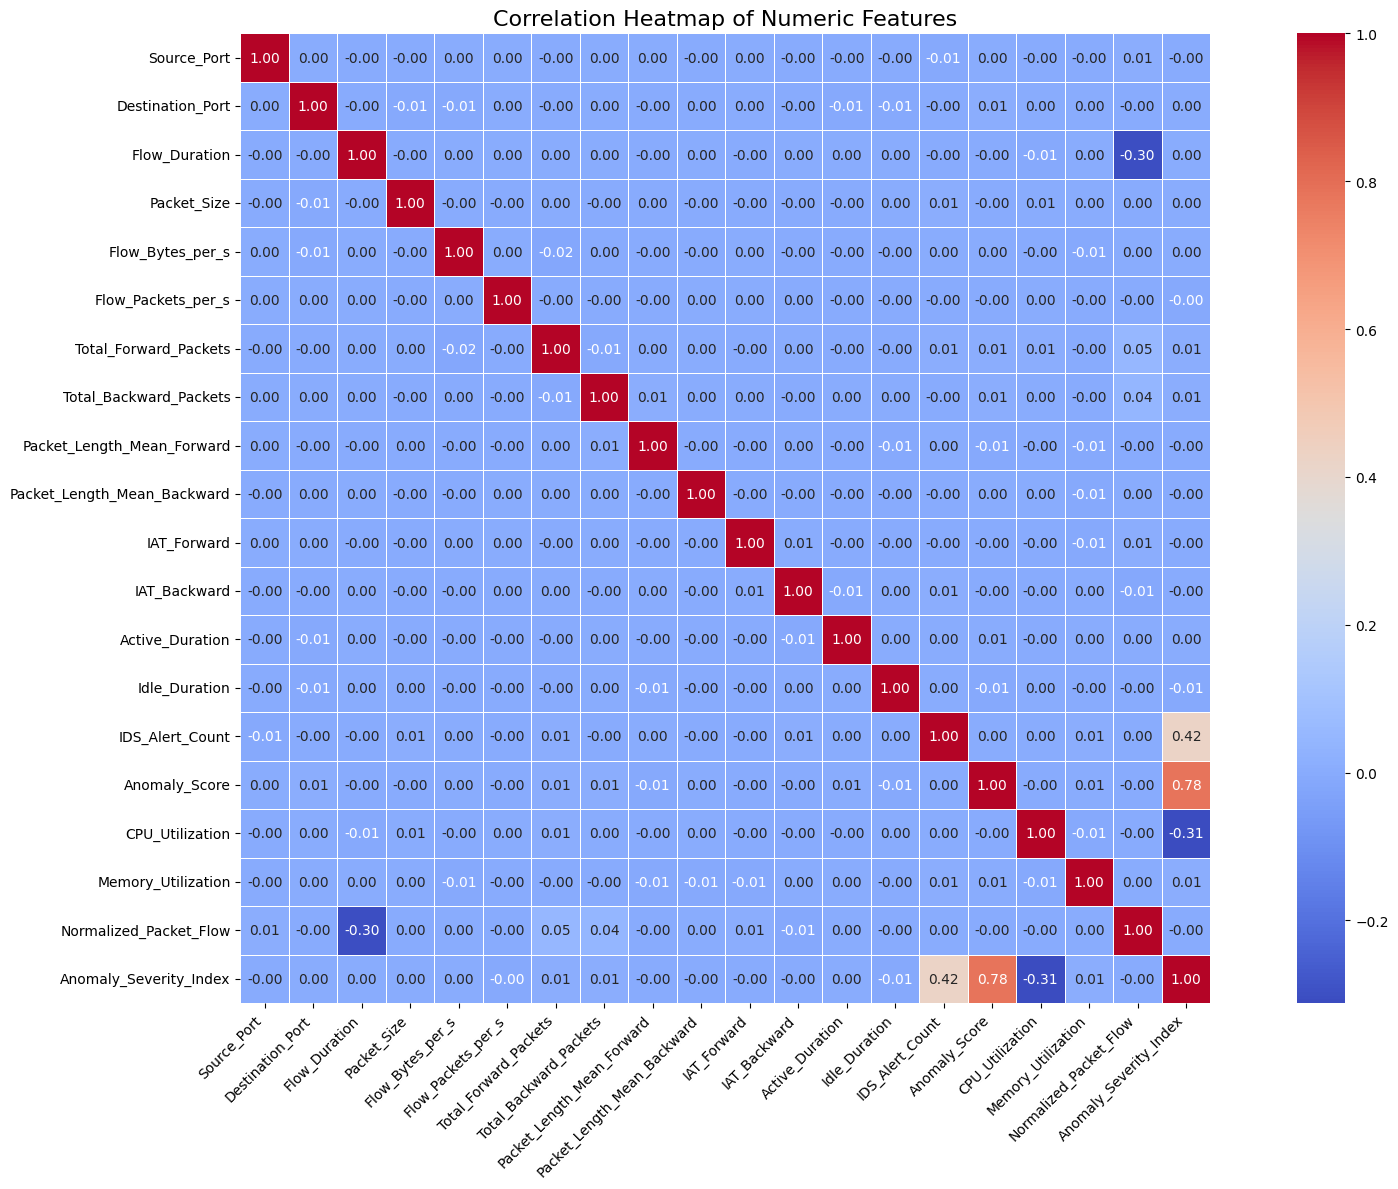

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = [
    'Source_Port',
    'Destination_Port',
    'Flow_Duration',
    'Packet_Size',
    'Flow_Bytes_per_s',
    'Flow_Packets_per_s',
    'Total_Forward_Packets',
    'Total_Backward_Packets',
    'Packet_Length_Mean_Forward',
    'Packet_Length_Mean_Backward',
    'IAT_Forward',
    'IAT_Backward',
    'Active_Duration',
    'Idle_Duration',
    'IDS_Alert_Count',
    'Anomaly_Score',
    'CPU_Utilization',
    'Memory_Utilization',
    'Normalized_Packet_Flow',
    'Anomaly_Severity_Index'
]

# Subset only numeric data
numeric_df = df[numeric_columns]

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Target Class Distribution Before Smote**

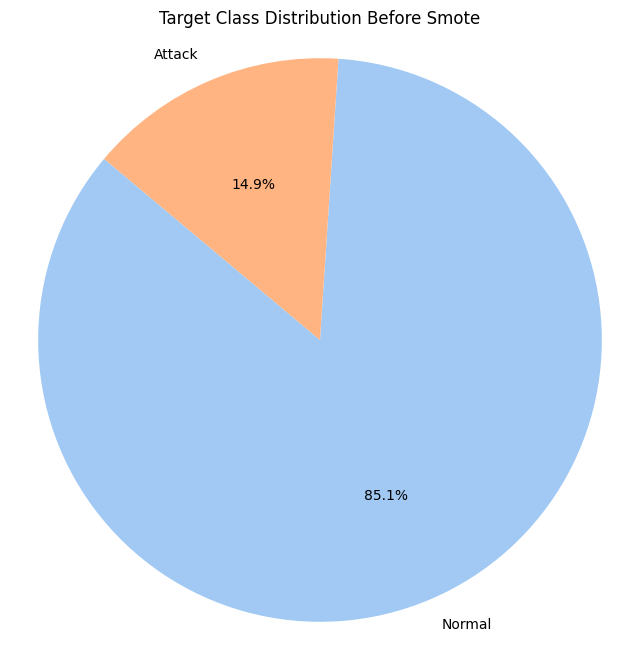

Label
Normal    46589
Attack     8179
Name: count, dtype: int64


In [18]:
# Assuming your target is 'Label'
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the value counts for the 'Label' column
label_counts = df['Label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8)) # Set the figure size
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Target Class Distribution Before Smote")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Also print the value counts as requested
print(df['Label'].value_counts())

**Data Preprocessing(Using Label encoding, missing value handling and balanced the dataset by smote)**

In [19]:

#  Step 4: Preprocessing + Label encoding + SMOTE

X = df.drop(columns=["Label"])
y = df["Label"]

# Label Encoding for categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# Handle missing values: Replace None/NaN values with mean (for numerical columns)
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
X.fillna(X.mean(numeric_only=True), inplace=True)  # Impute numerical columns with the mean

# Handle missing values for categorical columns
for col in categorical_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)  # Impute categorical columns with the mode (most frequent value)

# Label Encoding for target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=["Label"])], axis=1)
print("\nBalanced shape:", df_balanced.shape)
print("\nBalanced Label distribution:\n", df_balanced["Label"].value_counts())

/tmp/ipython-input-197638956.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mode()[0], inplace=True)  # Impute categorical columns with the mode (most frequent value)
/tmp/ipython-input-197638956.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex


Balanced shape: (93178, 30)

Balanced Label distribution:
 Label
1    46589
0    46589
Name: count, dtype: int64


In [20]:
# saved the balanced dataset

df_balanced.to_csv("/content/drive/MyDrive/Cybersecurity_Dataset/CTDAPD_Balanced_Dataset.csv", index=False)
print("\nBalanced dataset saved successfully.")


Balanced dataset saved successfully.


In [21]:
# Total missing values
df_balanced.isnull().sum()

Date                           0
Source_IP                      0
Destination_IP                 0
Source_Port                    0
Destination_Port               0
Protocol_Type                  0
Flow_Duration                  0
Packet_Size                    0
Flow_Bytes_per_s               0
Flow_Packets_per_s             0
Total_Forward_Packets          0
Total_Backward_Packets         0
Packet_Length_Mean_Forward     0
Packet_Length_Mean_Backward    0
IAT_Forward                    0
IAT_Backward                   0
Active_Duration                0
Idle_Duration                  0
IDS_Alert_Count                0
Anomaly_Score                  0
Attack_Vector                  0
Attack_Severity                0
Botnet_Family                  0
Malware_Type                   0
CPU_Utilization                0
Memory_Utilization             0
System_Patch_Status            0
Normalized_Packet_Flow         0
Anomaly_Severity_Index         0
Label                          0
dtype: int64

**Correlation Heatmap after the preprocessing**

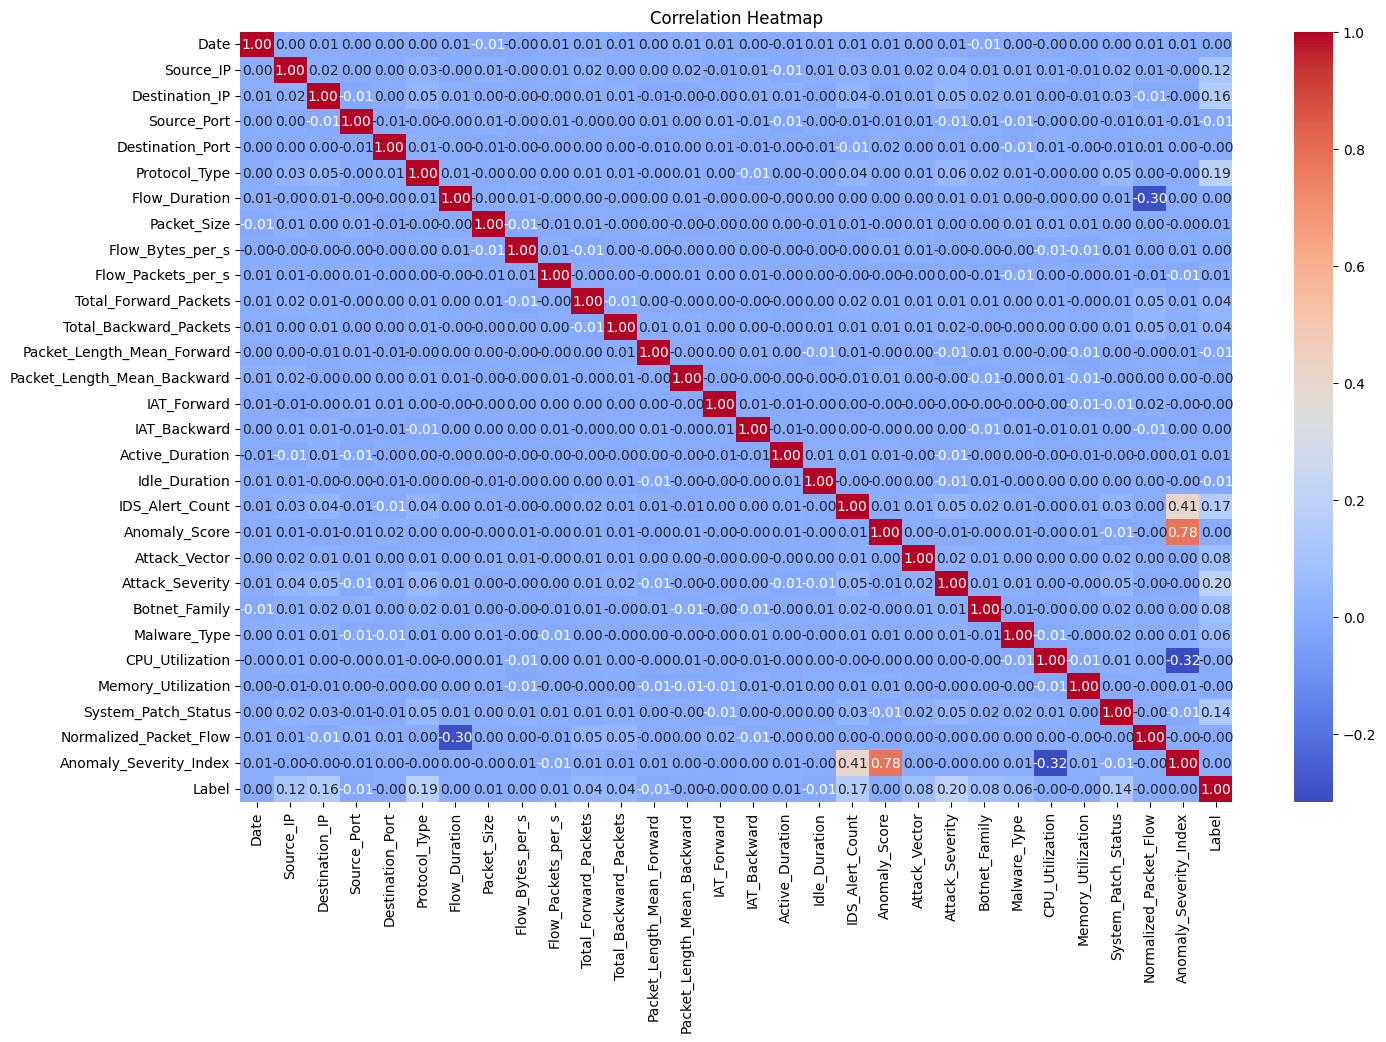

In [22]:
# Step 5: Correlation heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(df_balanced.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Correlation Heatmap of Top 15 Features with Label**

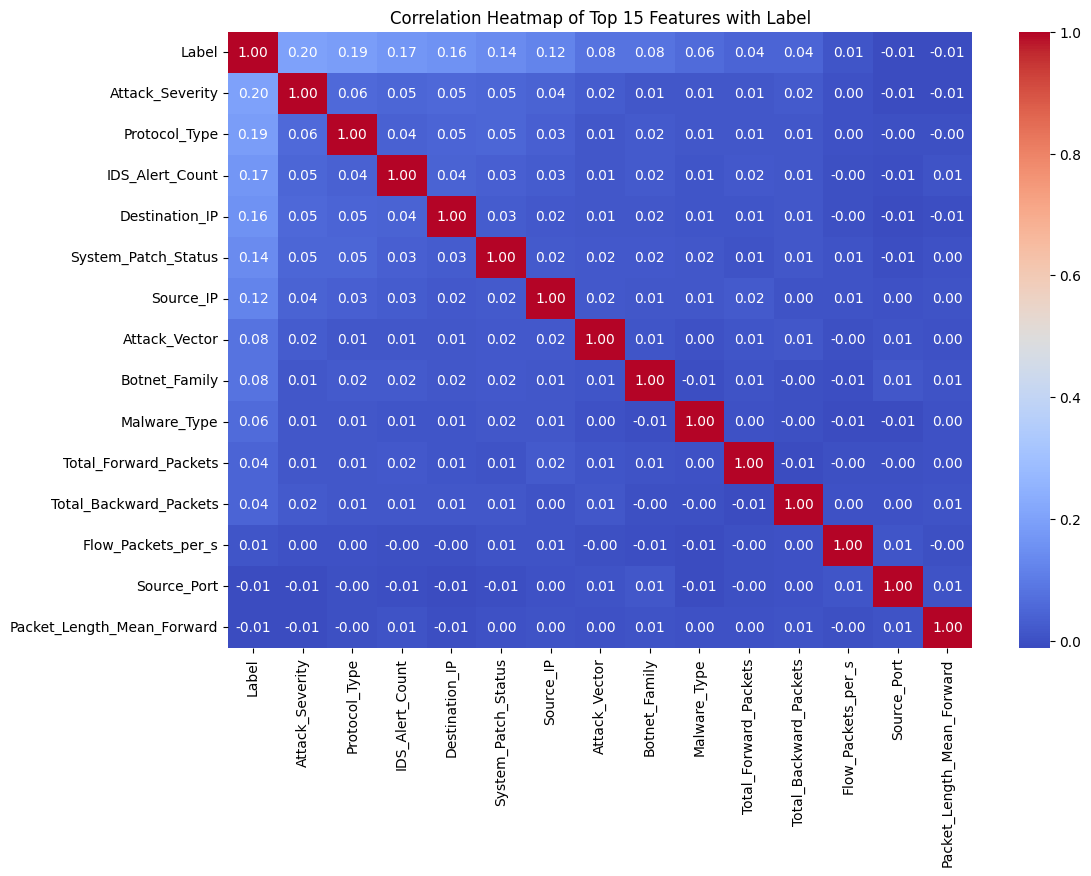

In [23]:
# the correlation heatmap with top 15 features

import matplotlib.pyplot as plt
# Calculate correlation matrix
correlation_matrix = df_balanced.corr()

# Get absolute correlations with the target variable 'Label'
target_correlation = correlation_matrix['Label'].abs().sort_values(ascending=False)

# Select top 15 features (including the target itself)
top_features = target_correlation.head(15).index.tolist()

# Filter the correlation matrix for the top features
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Top 15 Features with Label")
plt.show()

**Top 10 Positively and Negatively Correlated Features with Label**

/tmp/ipython-input-2769383294.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pos_corr.values, y=top_pos_corr.index, palette='crest')
/tmp/ipython-input-2769383294.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neg_corr.values, y=top_neg_corr.index, palette='flare')


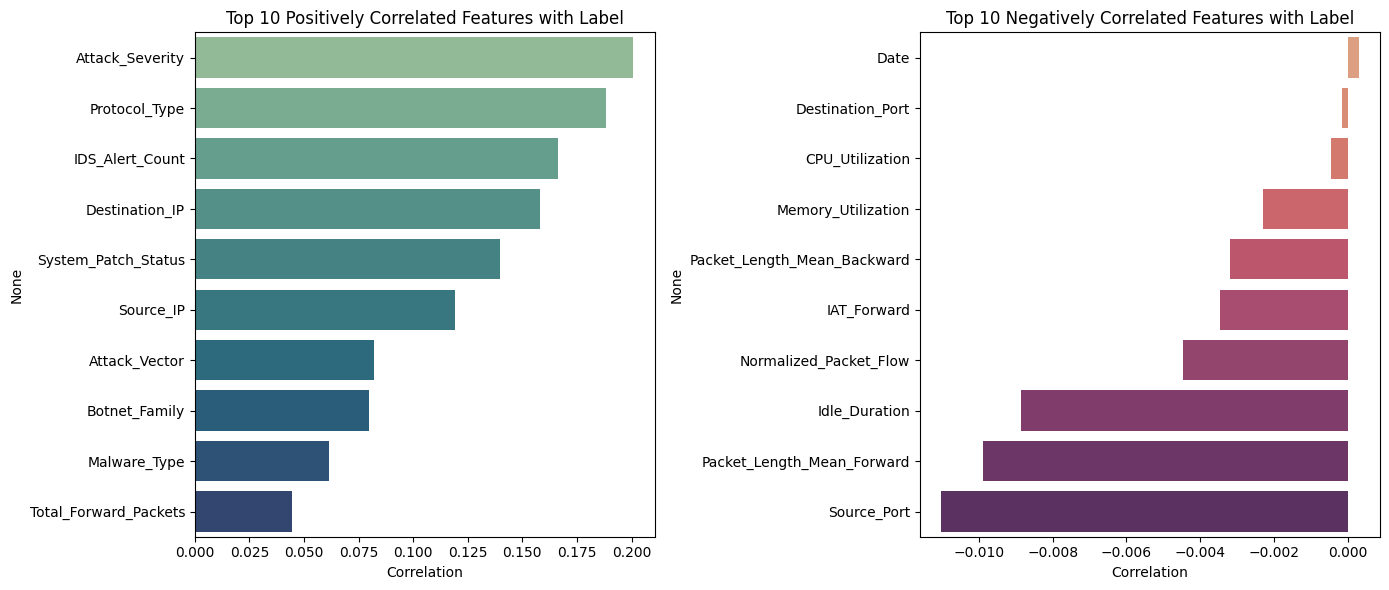

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation with 'Label' and sort
correlation_matrix = df_balanced.corr()
label_corr_sorted = correlation_matrix['Label'].drop('Label').sort_values(ascending=False)

# Select top 10 positive and top 10 negative correlated features
top_pos_corr = label_corr_sorted.head(10)
top_neg_corr = label_corr_sorted.tail(10)

# Plot the results
plt.figure(figsize=(14, 6))

# Positive correlations
plt.subplot(1, 2, 1)
sns.barplot(x=top_pos_corr.values, y=top_pos_corr.index, palette='crest')
plt.title("Top 10 Positively Correlated Features with Label")
plt.xlabel("Correlation")

# Negative correlations
plt.subplot(1, 2, 2)
sns.barplot(x=top_neg_corr.values, y=top_neg_corr.index, palette='flare')
plt.title("Top 10 Negatively Correlated Features with Label")
plt.xlabel("Correlation")

plt.tight_layout()
plt.show()


**Target Class Distribution After Smote**

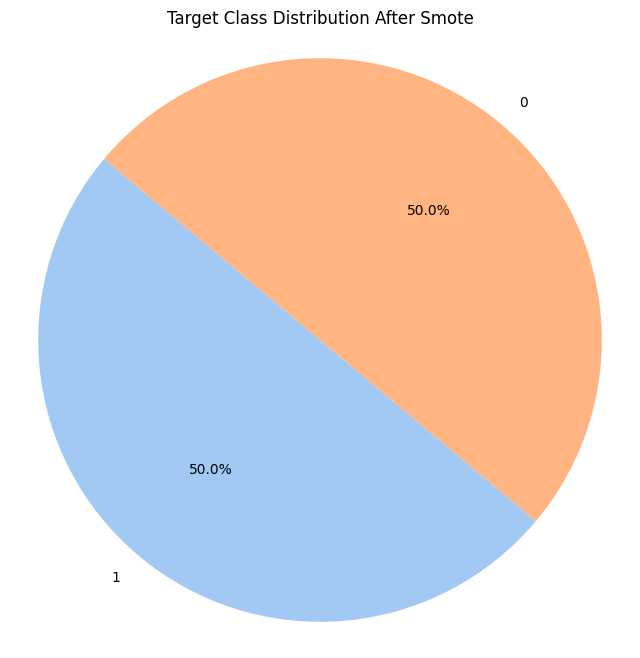

Label
1    46589
0    46589
Name: count, dtype: int64


In [25]:
# Assuming your target is 'Label'
import matplotlib.pyplot as plt
import seaborn as sns # Although not strictly needed for the pie chart itself, keep for context

# Calculate the value counts for the 'Label' column
label_counts = df_balanced['Label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8)) # Set the figure size
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Target Class Distribution After Smote")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Also print the value counts as requested
print(df_balanced['Label'].value_counts())

**Split the balanced dataset**

In [26]:

# Separate features and target from the balanced DataFrame
X = df_balanced.drop(columns=["Label"])
y = df_balanced["Label"]


# Stratified train-test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check the class distribution
print("Train set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())


Train set class distribution:
 Label
1    37271
0    37271
Name: count, dtype: int64
Test set class distribution:
 Label
1    9318
0    9318
Name: count, dtype: int64


**Scaling the dataset **

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Select all features for ml models**

In [28]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k='all')
selector.fit(X_train_scaled, y_train)


SelectKBest(k='all')

**ML Model Applying**


Naive Bayes - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.7010, Std = 0.0030
Train Accuracy: 0.7008
Log Loss: 0.6815
ROC AUC: 0.7609
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      9318
           1       0.72      0.66      0.69      9318

    accuracy                           0.70     18636
   macro avg       0.70      0.70      0.70     18636
weighted avg       0.70      0.70      0.70     18636



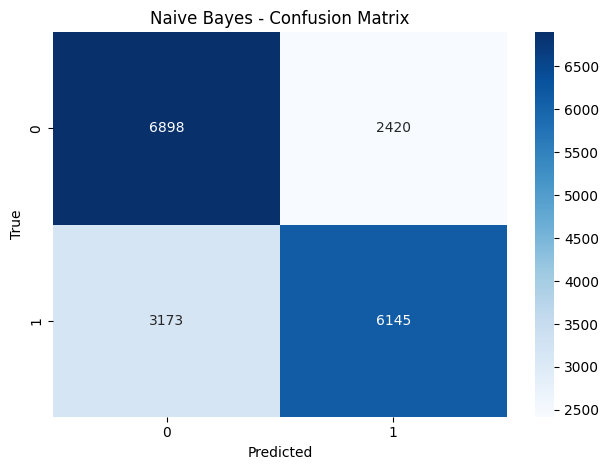


Decision Tree - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.7483, Std = 0.0016
Train Accuracy: 1.0000
Log Loss: 8.8368
ROC AUC: 0.7548
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      9318
           1       0.77      0.73      0.75      9318

    accuracy                           0.75     18636
   macro avg       0.76      0.75      0.75     18636
weighted avg       0.76      0.75      0.75     18636



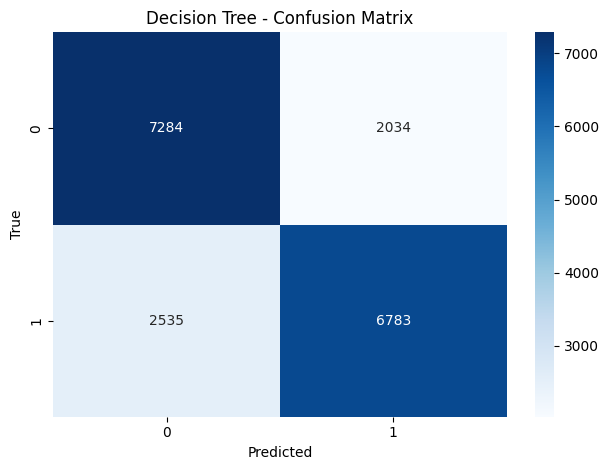


Random Forest - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8521, Std = 0.0030
Train Accuracy: 1.0000
Log Loss: 0.3958
ROC AUC: 0.9172
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      9318
           1       0.83      0.91      0.87      9318

    accuracy                           0.86     18636
   macro avg       0.86      0.86      0.86     18636
weighted avg       0.86      0.86      0.86     18636



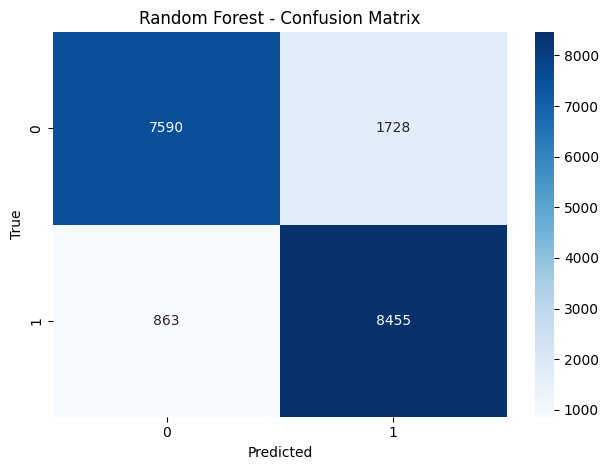

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:46:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:46:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:46:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:46:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:46:54] WARNING: /w


XGBoost - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8566, Std = 0.0019
Train Accuracy: 0.9051
Log Loss: 0.3394
ROC AUC: 0.9110
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      9318
           1       0.82      0.93      0.87      9318

    accuracy                           0.86     18636
   macro avg       0.87      0.86      0.86     18636
weighted avg       0.87      0.86      0.86     18636



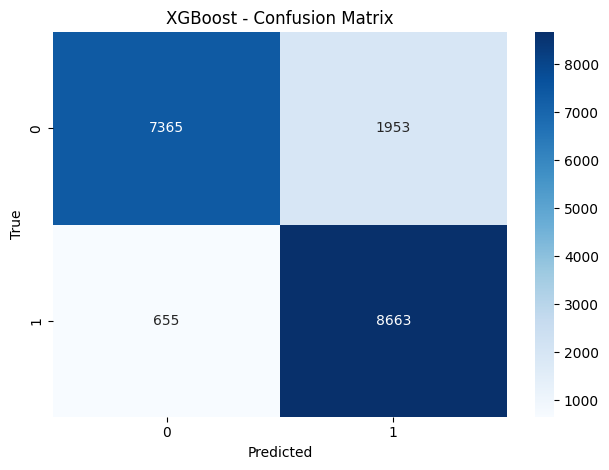


CatBoost - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8631, Std = 0.0017
Train Accuracy: 0.8940
Log Loss: 0.3395
ROC AUC: 0.9113
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      9318
           1       0.82      0.95      0.88      9318

    accuracy                           0.87     18636
   macro avg       0.88      0.87      0.87     18636
weighted avg       0.88      0.87      0.87     18636



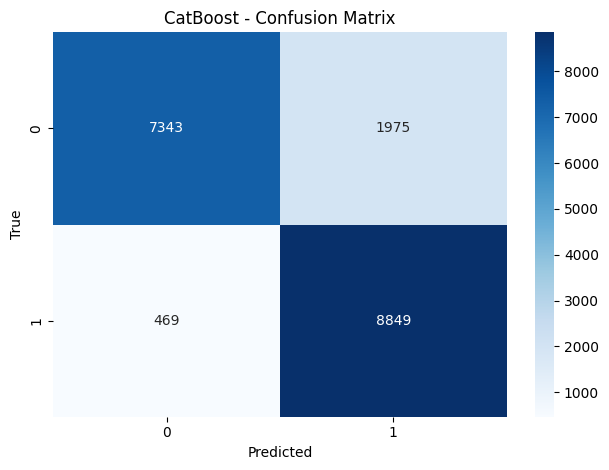

[LightGBM] [Info] Number of positive: 29816, number of negative: 29817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4669
[LightGBM] [Info] Number of data points in the train set: 59633, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 29817, number of negative: 29816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4668
[LightGBM] [Info] Number of data points in the train set: 59633, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 29817, number of negative: 29817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4668
[LightGBM] [Info] Number of data points in the train set: 59634, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 29817, number of negative: 29817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4669
[LightGBM] [Info] Number of data points in the train set: 59634, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 29817, number of negative: 29817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4669
[LightGBM] [Info] Number of data points in the train set: 59634, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 37271, number of negative: 37271
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4671
[LightGBM] [Info] Number of data points in the train set: 74542, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8464, Std = 0.0027
Train Accuracy: 0.8609
Log Loss: 0.3708
ROC AUC: 0.8951
              precision    recall  f1-score   support

           0       0.92      0.76      0.84      9318
           1       0.80      0.94      0.86      9318

    accuracy                           0.85     18636
   macro avg       0.86      0.85      0.85     18636
weighted avg       0.86      0.85      0.85     18636



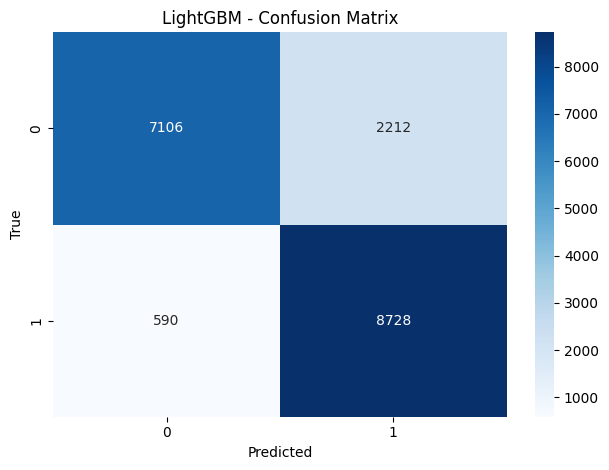


MLP (Neural Network) - Cross-Validation Results:
Cross-Validation Accuracy: Mean = 0.8037, Std = 0.0067
Train Accuracy: 0.8535
Log Loss: 0.4248
ROC AUC: 0.8806
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      9318
           1       0.79      0.86      0.82      9318

    accuracy                           0.82     18636
   macro avg       0.82      0.82      0.81     18636
weighted avg       0.82      0.82      0.81     18636



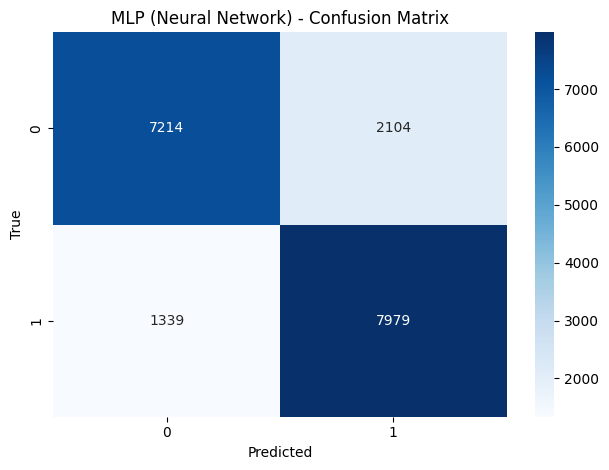


Model Comparison:
| Model                |   Mean CV Accuracy |   Std CV Accuracy |   Train Accuracy |   Test Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |   Log Loss |
|:---------------------|-------------------:|------------------:|-----------------:|----------------:|------------:|---------:|-----------:|----------:|-----------:|
| CatBoost             |           0.86307  |        0.00170544 |         0.894033 |        0.868856 |    0.817535 | 0.949667 |   0.878662 |  0.911276 |   0.339513 |
| XGBoost              |           0.856631 |        0.0019236  |         0.90506  |        0.860056 |    0.816032 | 0.929706 |   0.869168 |  0.91102  |   0.339426 |
| Random Forest        |           0.852124 |        0.00304882 |         1        |        0.860968 |    0.830305 | 0.907384 |   0.867135 |  0.917199 |   0.395849 |
| LightGBM             |           0.846355 |        0.00270933 |         0.860924 |        0.849646 |    0.797806 | 0.936682 |   0.861684 |  0.895093 

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, log_loss
)
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. Calculate proper class weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()  # For XGBoost

# Define models
models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
    "CatBoost":CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_seed=42),
    "LightGBM": LGBMClassifier(class_weight='balanced'),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Evaluate models
metrics = []

for name, model in models.items():
    # Perform cross-validation to evaluate the model on the training data
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation

    # Collect metrics for cross-validation
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Train the model on the entire training set
    model.fit(X_train_scaled, y_train)

    # Make predictions on the train and test sets
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Collect other metrics
    train_acc = accuracy_score(y_train, y_pred_train)  # Train accuracy
    test_acc = accuracy_score(y_test, y_pred_test)    # Test accuracy
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else np.nan
    ll = log_loss(y_test, y_proba_test) if y_proba_test is not None else np.nan

    # Print the model report and relevant metrics
    print(f"\n{name} - Cross-Validation Results:")
    print(f"Cross-Validation Accuracy: Mean = {mean_cv_score:.4f}, Std = {std_cv_score:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Log Loss: {ll:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred_test))

    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Collect metrics for the final results
    metrics.append({
        "Model": name,
        "Mean CV Accuracy": mean_cv_score,
        "Std CV Accuracy": std_cv_score,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc,
        "Log Loss": ll
    })

# Results DataFrame
results_df = pd.DataFrame(metrics).sort_values(by='F1 Score', ascending=False)
print("\nModel Comparison:")
print(results_df.to_markdown(index=False))

**ROC curve comparison**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


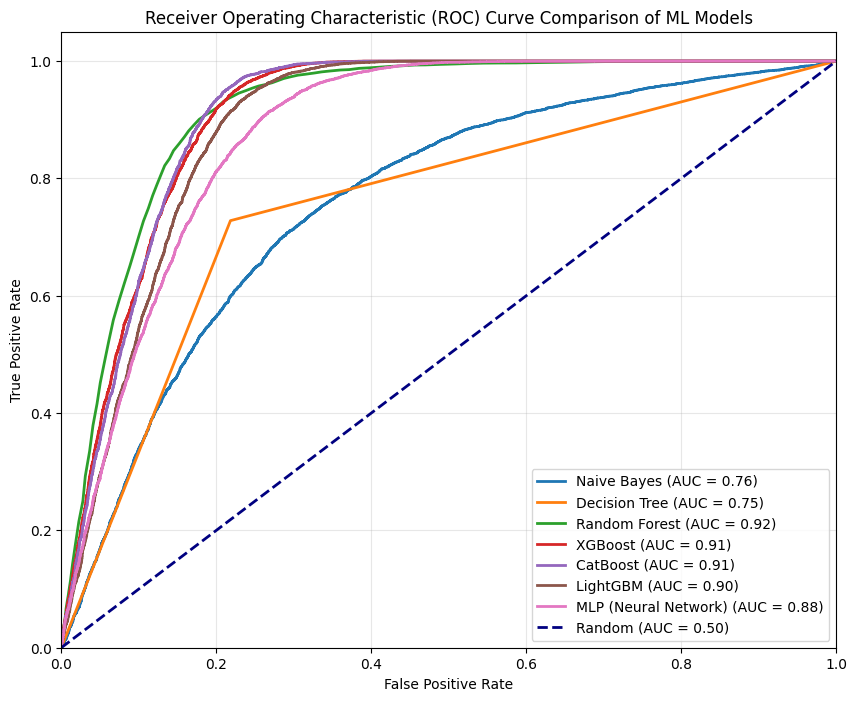

In [30]:
# roc curve comparison of the above model
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc # Import auc function explicitly

# ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Plot ROC curves for models that support predict_proba
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        model_auc_score = auc(fpr, tpr) # Renamed the variable to model_auc_score
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {model_auc_score:.2f})') # Use the new variable name

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison of ML Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

**Class 1 (Attack) Metrics Comparison Across ML Models**

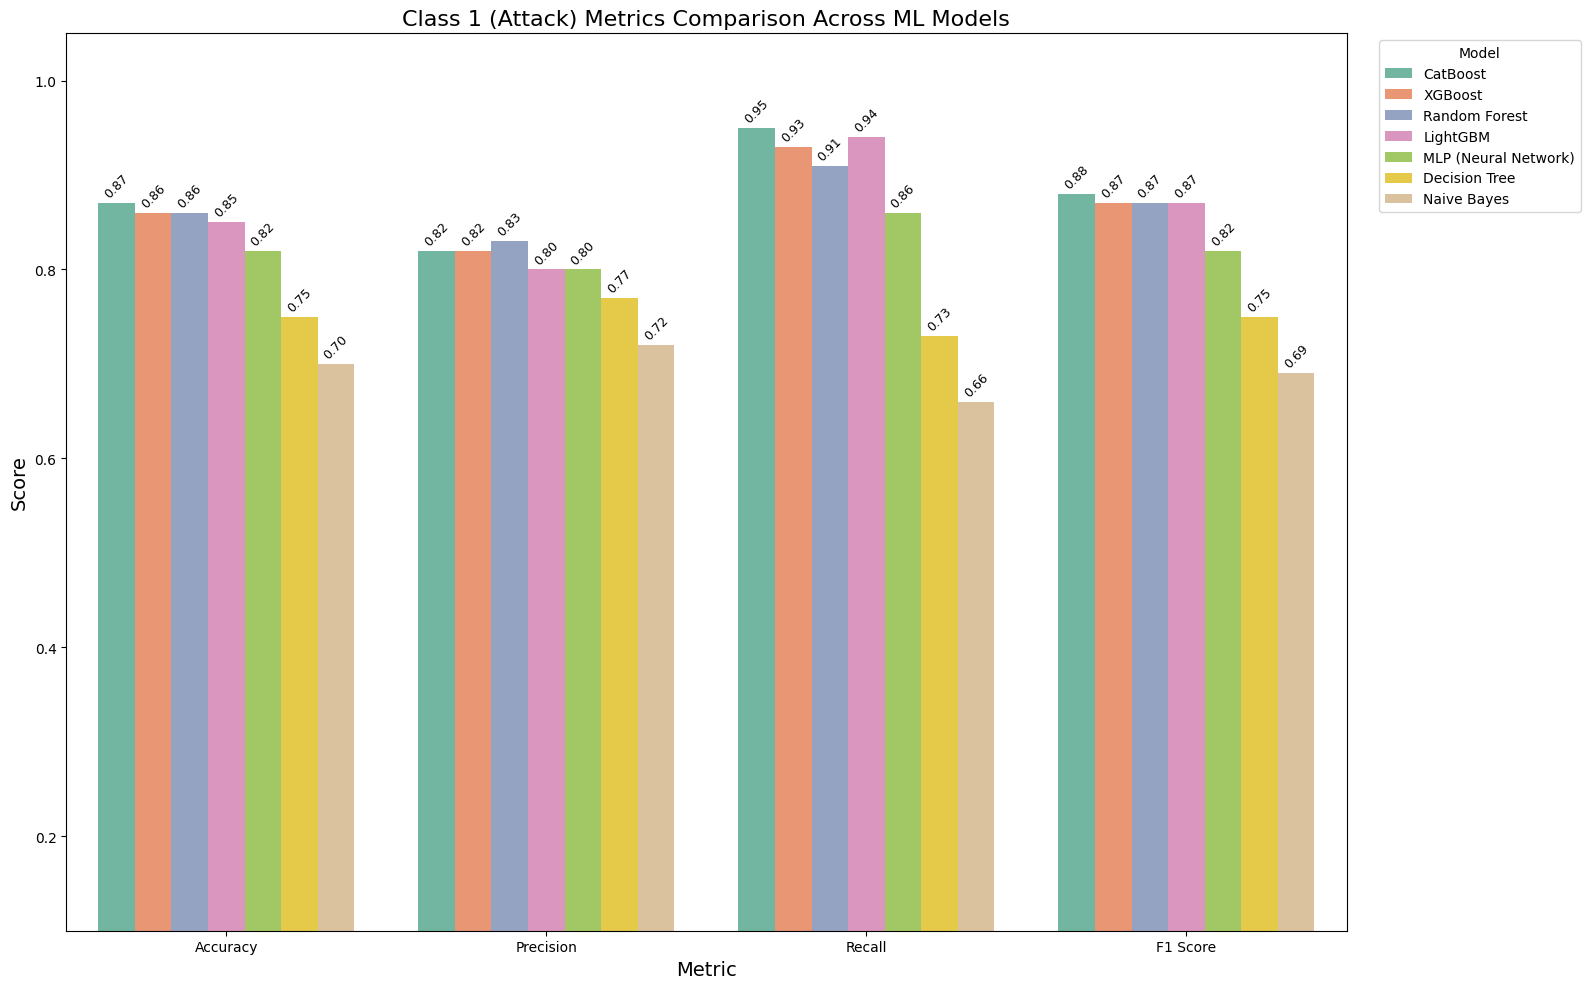

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated model metrics from your summary (only class 1)
metrics = [
    {"Model": "CatBoost",         "Accuracy": 0.87, "Precision": 0.82, "Recall": 0.95, "F1 Score": 0.88},
    {"Model": "XGBoost",          "Accuracy": 0.86, "Precision": 0.82, "Recall": 0.93, "F1 Score": 0.87},
    {"Model": "Random Forest",    "Accuracy": 0.86, "Precision": 0.83, "Recall": 0.91, "F1 Score": 0.87},
    {"Model": "LightGBM",         "Accuracy": 0.85, "Precision": 0.80, "Recall": 0.94, "F1 Score": 0.87},
    {"Model": "MLP (Neural Network)", "Accuracy": 0.82, "Precision": 0.80, "Recall": 0.86, "F1 Score": 0.82},
    {"Model": "Decision Tree",    "Accuracy": 0.75, "Precision": 0.77, "Recall": 0.73, "F1 Score": 0.75},
    {"Model": "Naive Bayes",      "Accuracy": 0.70, "Precision": 0.72, "Recall": 0.66, "F1 Score": 0.69},
]

# Convert to DataFrame
df = pd.DataFrame(metrics)

# Melt for seaborn
df_melted = df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1 Score"],
                    var_name="Metric", value_name="Score")

# Plotting
plt.figure(figsize=(16, 10))
ax = sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette="Set2")

# Add value labels with slight rotation
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2, fontsize=9, rotation=45)

# Styling
plt.title('Class 1 (Attack) Metrics Comparison Across ML Models', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0.1, 1.05)
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Log Loss Comparison Across ML Models**

/tmp/ipython-input-84902044.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Model", x="Log Loss", data=ml_log_losses, palette="viridis")


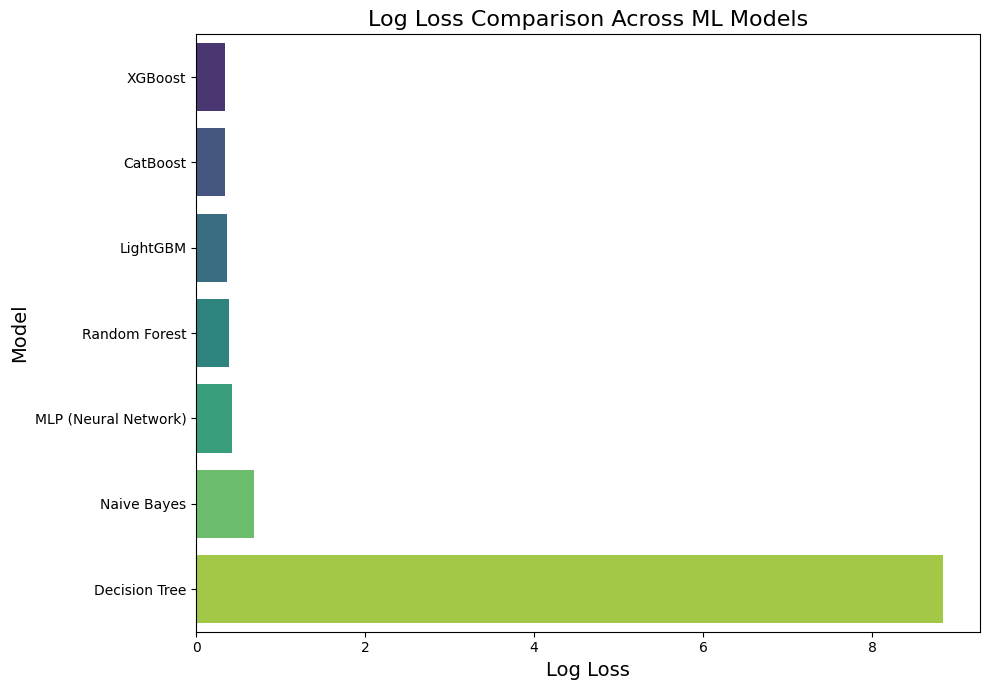

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract Log Loss from results_df
ml_log_losses = results_df[['Model', 'Log Loss']].dropna()

# Sort by Log Loss
ml_log_losses = ml_log_losses.sort_values(by="Log Loss", ascending=True)

# Plotting
plt.figure(figsize=(10, 7))
sns.barplot(y="Model", x="Log Loss", data=ml_log_losses, palette="viridis")

# Styling
plt.title("Log Loss Comparison Across ML Models", fontsize=16)
plt.xlabel("Log Loss", fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.tight_layout()
plt.show()


** Post detection anomalies clustering for catboost**


Cluster Performance Analysis (PREDICTED ATTACK only):
   Cluster  Mean_Probability  STD_Probability  Sample_Count  \
0        0          0.775775         0.113831          7264   
1        1          0.786644         0.111147          3560   

   Misclassification_Rate  
0                0.186949  
1                0.173315  

⚠️ Suspicious Cluster: 0 (Lowest Mean Attack Probability)


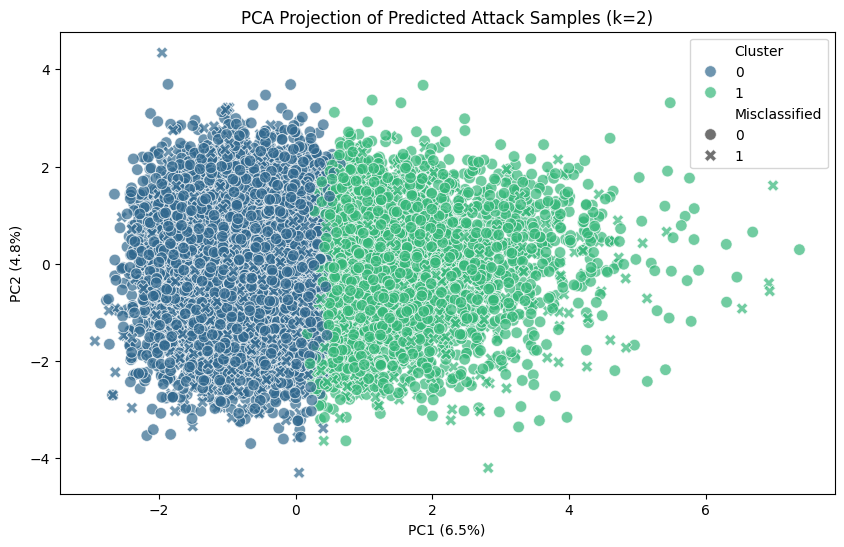

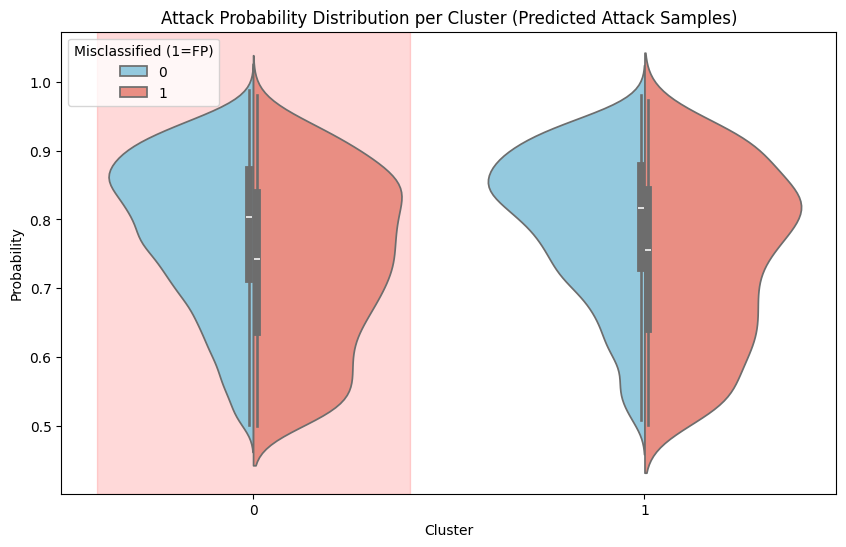


 Top 10 features per cluster based on average value:

Cluster 0 top features:
Attack_Probability     0.775775
Attack_Severity        0.220591
Destination_IP         0.181917
System_Patch_Status    0.180130
Protocol_Type          0.168211
Source_IP              0.159003
CPU_Utilization        0.155157
Botnet_Family          0.089235
Malware_Type           0.084426
Attack_Vector          0.077529
Name: 0, dtype: float64

Cluster 1 top features:
Anomaly_Severity_Index    1.206176
Anomaly_Score             1.089355
Attack_Probability        0.786644
IDS_Alert_Count           0.662861
Protocol_Type             0.221808
Destination_IP            0.193747
Attack_Severity           0.192546
Total_Backward_Packets    0.134905
System_Patch_Status       0.126427
Source_IP                 0.108430
Name: 1, dtype: float64


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ==============================================
# 1. Filter Only Predicted Attacks
# ==============================================
# Get predictions and probabilities from the CatBoost model

catb_model = models["CatBoost"]

y_pred = catb_model.predict(X_test_scaled)
y_proba = catb_model.predict_proba(X_test_scaled)

# Create a mask for predicted attack samples (Label 1)
predicted_attack_mask = (y_pred == 1)

# Filter the test data, true labels, predicted probabilities for only predicted attack samples
X_attack_predicted = X_test_scaled[predicted_attack_mask]
y_attack_true = y_test[predicted_attack_mask]
y_attack_proba = y_proba[predicted_attack_mask, 1]

# Misclassification flag (1 = misclassified FP, 0 = correct TP) for the predicted attack samples
# Compare true labels (y_attack_true) with the predicted labels (which are all 1 in this filtered set)
misclassified = (y_attack_true != 1).astype(int)


# ==============================================
# 2. Clustering
# ==============================================
# Combine features and predicted probabilities for clustering
X_combined = np.c_[X_attack_predicted, y_attack_proba]

# Scale the combined data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)


# Perform K-Means clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# ==============================================
# 3. PCA for visualization
# ==============================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Probability': y_attack_proba,
    'Misclassified': misclassified
})

# ==============================================
# 4. Cluster stats
# ==============================================
cluster_stats = viz_df.groupby("Cluster").agg(
    Mean_Probability=("Probability", "mean"),
    STD_Probability=("Probability", "std"),
    Sample_Count=("Probability", "count"),
    Misclassification_Rate=("Misclassified", "mean")
).reset_index()

print("\nCluster Performance Analysis (PREDICTED ATTACK only):")
print(cluster_stats)

# Identify suspicious cluster (lowest mean probability)
suspect_cluster = cluster_stats.loc[
    cluster_stats["Mean_Probability"].idxmin(), "Cluster"
]
print(f"\n⚠️ Suspicious Cluster: {suspect_cluster} (Lowest Mean Attack Probability)")

# ==============================================
# 5. PCA scatter plot
# ==============================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=viz_df, x="PC1", y="PC2",
    hue="Cluster", style="Misclassified",
    palette="viridis", alpha=0.7, s=70
)
plt.title(f"PCA Projection of Predicted Attack Samples (k={k})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")


# ==============================================
# 6. Violin plot of attack probabilities
# ==============================================
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=viz_df, x="Cluster", y="Probability",
    hue="Misclassified", split=True,
    palette={0: "skyblue", 1: "salmon"}
)
plt.title("Attack Probability Distribution per Cluster (Predicted Attack Samples)")

# Highlight suspicious cluster band
suspect_x_pos = list(sorted(viz_df["Cluster"].unique())).index(suspect_cluster)
ax.axvspan(suspect_x_pos - 0.4, suspect_x_pos + 0.4,
           color='red', alpha=0.15, zorder=0)


plt.legend(title="Misclassified (1=FP)")
plt.show()

# ==============================================
# 7. Identify Top Features per Cluster
# ==============================================
# Reconstruct DataFrame for original features + probability for the predicted attack samples
feature_names = list(X_test.columns) + ['Attack_Probability']
df_features = pd.DataFrame(X_combined, columns=feature_names)
df_features['Cluster'] = clusters

# Calculate feature means per cluster
feature_means = df_features.groupby('Cluster').mean().T

# Show top 10 features per cluster
print("\n Top 10 features per cluster based on average value:")
for cluster_id in feature_means.columns:
    print(f"\nCluster {cluster_id} top features:")
    print(feature_means[cluster_id].sort_values(ascending=False).head(10))


Cluster Performance Analysis (PREDICTED ATTACK only):
   Cluster  Mean_Probability  STD_Probability  Sample_Count  \
0        0          0.775775         0.113831          7264   
1        1          0.786644         0.111147          3560   

   Misclassification_Rate  
0                0.186949  
1                0.173315  

⚠️ Suspicious Cluster: 0 (Lowest Mean Attack Probability)


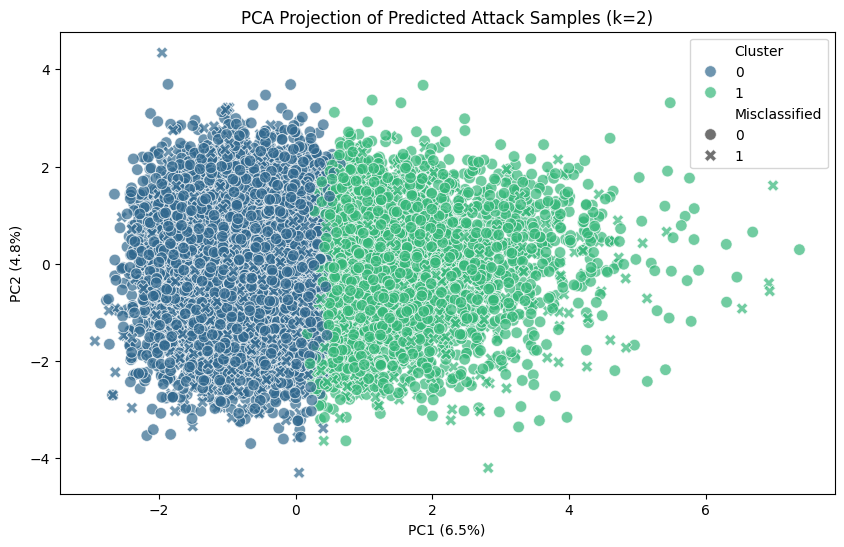

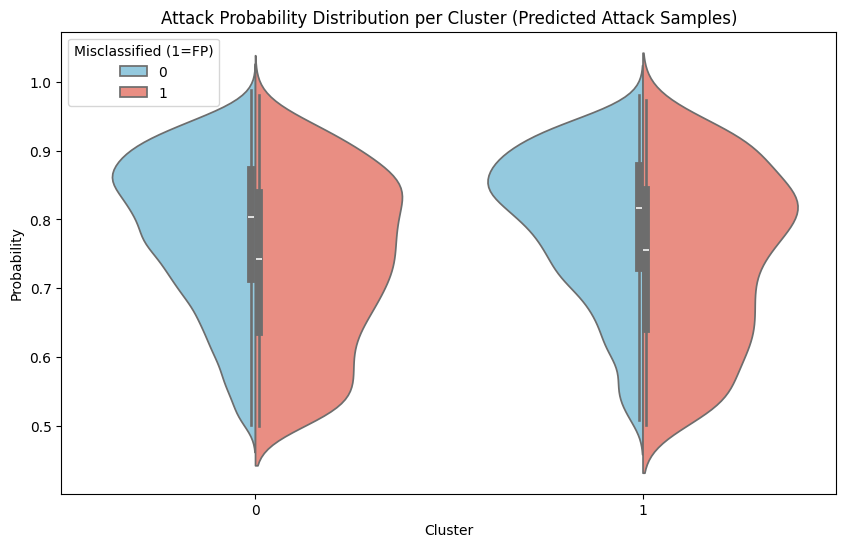


 Top 10 features per cluster based on average value:

Cluster 0 top features:
Attack_Probability     0.775775
Attack_Severity        0.220591
Destination_IP         0.181917
System_Patch_Status    0.180130
Protocol_Type          0.168211
Source_IP              0.159003
CPU_Utilization        0.155157
Botnet_Family          0.089235
Malware_Type           0.084426
Attack_Vector          0.077529
Name: 0, dtype: float64

Cluster 1 top features:
Anomaly_Severity_Index    1.206176
Anomaly_Score             1.089355
Attack_Probability        0.786644
IDS_Alert_Count           0.662861
Protocol_Type             0.221808
Destination_IP            0.193747
Attack_Severity           0.192546
Total_Backward_Packets    0.134905
System_Patch_Status       0.126427
Source_IP                 0.108430
Name: 1, dtype: float64


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ==============================================
# 1. Filter Only Predicted Attacks
# ==============================================
# Get predictions and probabilities from the CatBoost model

catb_model = models["CatBoost"]

y_pred = catb_model.predict(X_test_scaled)
y_proba = catb_model.predict_proba(X_test_scaled)

# Create a mask for predicted attack samples (Label 1)
predicted_attack_mask = (y_pred == 1)

# Filter the test data, true labels, predicted probabilities for only predicted attack samples
X_attack_predicted = X_test_scaled[predicted_attack_mask]
y_attack_true = y_test[predicted_attack_mask]
y_attack_proba = y_proba[predicted_attack_mask, 1]

# Misclassification flag (1 = misclassified FP, 0 = correct TP) for the predicted attack samples
# Compare true labels (y_attack_true) with the predicted labels (which are all 1 in this filtered set)
misclassified = (y_attack_true != 1).astype(int)


# ==============================================
# 2. Clustering
# ==============================================
# Combine features and predicted probabilities for clustering
X_combined = np.c_[X_attack_predicted, y_attack_proba]

# Scale the combined data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)


# Perform K-Means clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# ==============================================
# 3. PCA for visualization
# ==============================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Probability': y_attack_proba,
    'Misclassified': misclassified
})

# ==============================================
# 4. Cluster stats
# ==============================================
cluster_stats = viz_df.groupby("Cluster").agg(
    Mean_Probability=("Probability", "mean"),
    STD_Probability=("Probability", "std"),
    Sample_Count=("Probability", "count"),
    Misclassification_Rate=("Misclassified", "mean")
).reset_index()

print("\nCluster Performance Analysis (PREDICTED ATTACK only):")
print(cluster_stats)

# Identify suspicious cluster (lowest mean probability)
suspect_cluster = cluster_stats.loc[
    cluster_stats["Mean_Probability"].idxmin(), "Cluster"
]
print(f"\n⚠️ Suspicious Cluster: {suspect_cluster} (Lowest Mean Attack Probability)")

# ==============================================
# 5. PCA scatter plot
# ==============================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=viz_df, x="PC1", y="PC2",
    hue="Cluster", style="Misclassified",
    palette="viridis", alpha=0.7, s=70
)
plt.title(f"PCA Projection of Predicted Attack Samples (k={k})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")


# ==============================================
# 6. Violin plot of attack probabilities
# ==============================================
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=viz_df, x="Cluster", y="Probability",
    hue="Misclassified", split=True,
    palette={0: "skyblue", 1: "salmon"}
)
plt.title("Attack Probability Distribution per Cluster (Predicted Attack Samples)")

# # Highlight suspicious cluster band
# suspect_x_pos = list(sorted(viz_df["Cluster"].unique())).index(suspect_cluster)
# ax.axvspan(suspect_x_pos - 0.4, suspect_x_pos + 0.4,
#            color='red', alpha=0.15, zorder=0)


plt.legend(title="Misclassified (1=FP)")
plt.show()

# ==============================================
# 7. Identify Top Features per Cluster
# ==============================================
# Reconstruct DataFrame for original features + probability for the predicted attack samples
feature_names = list(X_test.columns) + ['Attack_Probability']
df_features = pd.DataFrame(X_combined, columns=feature_names)
df_features['Cluster'] = clusters

# Calculate feature means per cluster
feature_means = df_features.groupby('Cluster').mean().T

# Show top 10 features per cluster
print("\n Top 10 features per cluster based on average value:")
for cluster_id in feature_means.columns:
    print(f"\nCluster {cluster_id} top features:")
    print(feature_means[cluster_id].sort_values(ascending=False).head(10))

**Explainable Ai(Shap) for Best ML model(Catboost)**

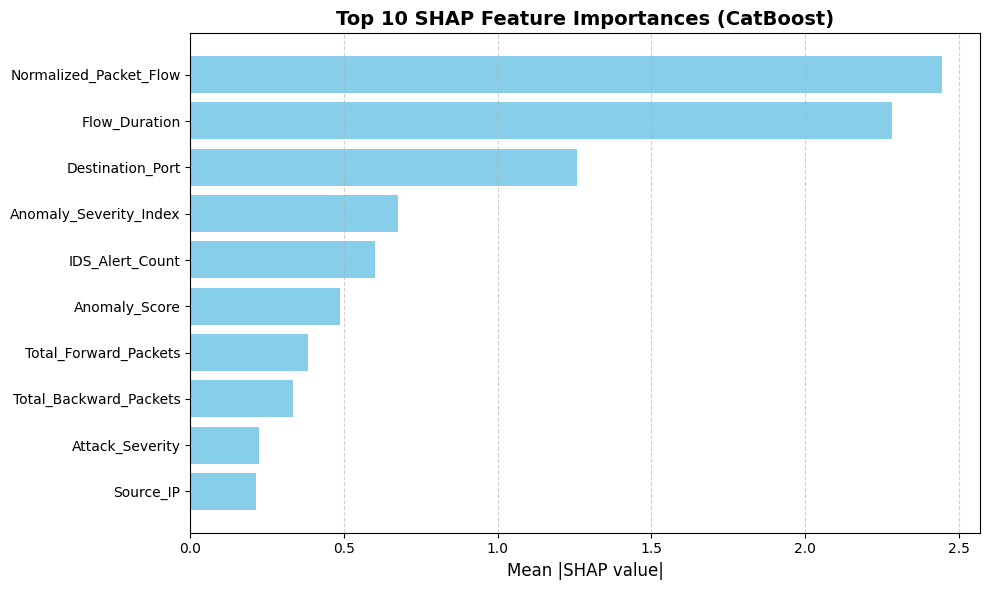

In [35]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# Train CatBoost model
catboost_model = CatBoostClassifier(verbose=0, auto_class_weights="Balanced", random_seed=42)
catboost_model.fit(X_train_scaled, y_train)

# Compute SHAP values
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test_scaled)

# Calculate mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values).mean(axis=0)
feature_names = X_test.columns

# Create a DataFrame for sorting
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': shap_importance
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
top_n = 10
top_features = shap_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='skyblue')
plt.xlabel("Mean |SHAP value|", fontsize=12)
plt.title("Top 10 SHAP Feature Importances (CatBoost)", fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





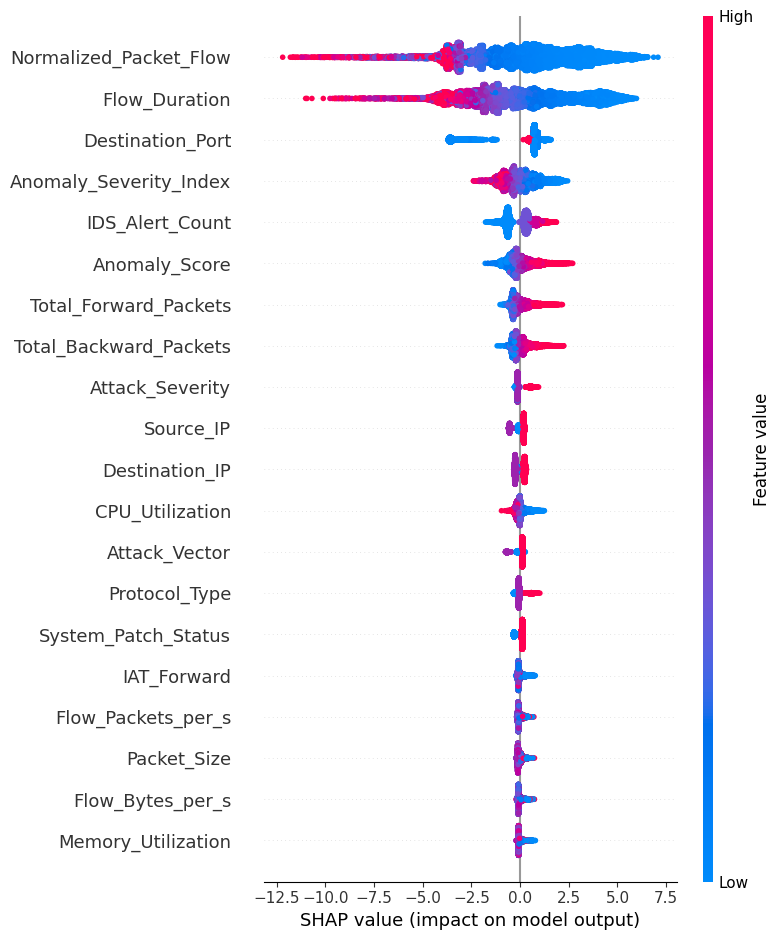

In [36]:
# --- SHAP Summary Plot ---
shap.summary_plot(shap_values, X_test, title="SHAP Summary Plot (CatBoost)")


Explaining prediction for test sample 0:



Explaining prediction for test sample 1:



Explaining prediction for test sample 2:


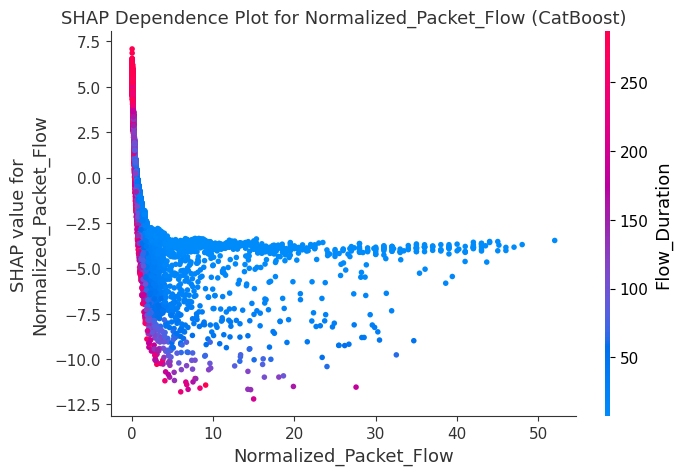

In [37]:
# Force Plot (Individual Prediction): Explains a single prediction.

shap.initjs() # Initialize JavaScript for interactive plots
try:
    # Try displaying interactively for a few samples
    for i in range(min(3, X_test.shape[0])): # Show for up to 5 samples
        print(f"\nExplaining prediction for test sample {i}:")
        display(shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], matplotlib=False))
except Exception as e:
    print(f"Interactive force plot failed: {e}. Displaying static plot if possible (requires matplotlib=True).")
    # If interactive fails, you can try static for one example:
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True, show=True)


# Dependence Plot: Shows the effect of a single feature across the whole dataset.

top_feature = X_test.columns[np.argsort(np.abs(shap_values).mean(0))[-1]]

shap.dependence_plot(top_feature, shap_values, X_test, title=f"SHAP Dependence Plot for {top_feature} (CatBoost)")
plt.show()


**Applying GNN models**

**Prepare data for gnn models**

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import to_undirected

In [39]:

# 1. Load data
df = pd.read_csv('/content/drive/MyDrive/Cybersecurity_Dataset/CTDAPD_Balanced_Dataset.csv')
X = df.drop(columns=["Label"])
y = df["Label"].values
node_indices = np.arange(len(y))

# 2. Split: Train 70%, Val 15%, Test 15%
train_idx, temp_idx = train_test_split(node_indices, test_size=0.30, stratify=y, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, stratify=y[temp_idx], random_state=42)

# 3. Scale features based on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X.iloc[train_idx])
X_val_scaled = scaler.transform(X.iloc[val_idx])
X_test_scaled = scaler.transform(X.iloc[test_idx])

X_scaled = np.zeros_like(X, dtype=np.float32)
X_scaled[train_idx] = X_train_scaled
X_scaled[val_idx] = X_val_scaled
X_scaled[test_idx] = X_test_scaled

x = torch.tensor(X_scaled, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.long)

# 4. Create boolean masks
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# 5. Create graph with symmetric KNN edges
knn_graph = kneighbors_graph(X_scaled, n_neighbors=3, include_self=False)
row, col = knn_graph.nonzero()
edge_index = torch.tensor(np.vstack((row, col)), dtype=torch.long)
edge_index = to_undirected(edge_index, num_nodes=X_scaled.shape[0])

# 6. PyG Data object
data = Data(x=x, edge_index=edge_index, y=y_tensor)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# Print data split info
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}")
print("Train class distribution:", y[train_idx].tolist().count(1), "/", y[train_idx].tolist().count(0))
print("Val class distribution:", y[val_idx].tolist().count(1), "/", y[val_idx].tolist().count(0))
print("Test class distribution:", y[test_idx].tolist().count(1), "/", y[test_idx].tolist().count(0))

Nodes: 93178, Edges: 436166
Train class distribution: 32612 / 32612
Val class distribution: 6989 / 6988
Test class distribution: 6988 / 6989


**Graph construction for gnn models from training data**

/tmp/ipython-input-1102887464.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", len(unique_vecs))


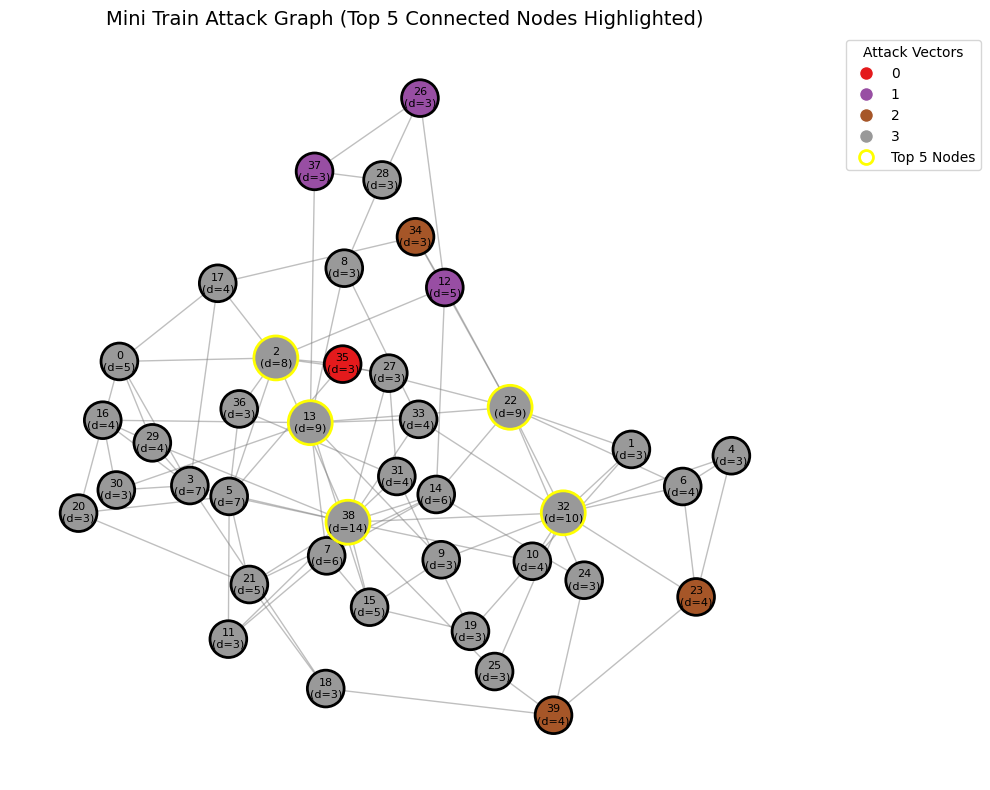

In [41]:
import networkx as nx

# -----------------------------
# 1. Take a small sample from training data
# -----------------------------
sample_size = 40  # number of nodes to visualize

# Training data subset
X_train_small = X_scaled[train_idx]
y_train_small = y[train_idx]
attack_vectors_train = df["Attack_Vector"].values[train_idx]

# Filter attack nodes and sample
attack_nodes = np.where(y_train_small == 1)[0][:sample_size]
X_sample = X_train_small[attack_nodes]
attack_vectors_sample = attack_vectors_train[attack_nodes]

# -----------------------------
# 2. Scale features (optional, already scaled)
# -----------------------------
# X_sample_scaled = StandardScaler().fit_transform(X_sample)  # already scaled in X_scaled

# -----------------------------
# 3. Create k-NN graph
# -----------------------------
k = 3
knn_graph = kneighbors_graph(X_sample, n_neighbors=k, include_self=False)
row, col = knn_graph.nonzero()
edges = list(zip(row, col))

G = nx.Graph()
G.add_nodes_from(range(len(X_sample)))
G.add_edges_from(edges)

# -----------------------------
# 4. Layout
# -----------------------------
pos = nx.spring_layout(G, seed=42, k=0.5)

# -----------------------------
# 5. Node colors and top nodes
# -----------------------------
unique_vecs = np.unique(attack_vectors_sample)
cmap = plt.cm.get_cmap("Set1", len(unique_vecs))
vec_to_color = {vec: cmap(i) for i, vec in enumerate(unique_vecs)}
node_colors = [vec_to_color[vec] for vec in attack_vectors_sample]

top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]
top_node_ids = [node for node, _ in top_nodes]
node_sizes = [1000 if i in top_node_ids else 700 for i in range(len(X_sample))]
node_borders = ['yellow' if i in top_node_ids else 'black' for i in range(len(X_sample))]

# -----------------------------
# 6. Draw
# -----------------------------
plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=node_sizes,
                       edgecolors=node_borders,
                       linewidths=2)
labels = {i: f"{i}\n(d={G.degree[i]})" for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

# Legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=vec,
                             markerfacecolor=vec_to_color[vec], markersize=10)
                  for vec in unique_vecs]
highlight_patch = plt.Line2D([0], [0], marker='o', color='w', label='Top 5 Nodes',
                             markerfacecolor='none', markeredgecolor='yellow', markeredgewidth=2, markersize=10)
legend_handles.append(highlight_patch)

plt.legend(handles=legend_handles, title='Attack Vectors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Mini Train Attack Graph (Top 5 Connected Nodes Highlighted)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


**GraphSage model training-val-test result**

In [44]:

# 7. GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 8. Training setup with early stopping on validation
model = GraphSAGE(data.num_node_features, hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()

best_val_acc = 0.0
patience = 10
counter = 0

# List to store training history
training_history = []

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    train_logits = out[data.train_mask]
    train_labels = data.y[data.train_mask]
    train_loss = loss_fn(train_logits, train_labels)
    train_loss.backward()
    optimizer.step()

    train_preds = train_logits.argmax(dim=1).cpu()
    train_acc = accuracy_score(train_labels.cpu(), train_preds)

    # Validation
    model.eval()
    with torch.no_grad():
        val_logits = out[data.val_mask]
        val_labels = data.y[data.val_mask]
        val_loss = loss_fn(val_logits, val_labels)
        val_preds = val_logits.argmax(dim=1).cpu()
        val_acc = accuracy_score(val_labels.cpu(), val_preds)

    # Store metrics
    training_history.append({
        'epoch': epoch,
        'train_loss': train_loss.item(),
        'train_acc': train_acc,
        'val_loss': val_loss.item(),
        'val_acc': val_acc
    })


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}. Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
            break

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")

# 9. Final Evaluation on Test Set
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    test_logits = out[data.test_mask]
    test_labels = data.y[data.test_mask]
    test_preds = test_logits.argmax(dim=1).cpu()
    test_probs = torch.exp(test_logits)[:, 1].cpu() # Calculate probabilities for log loss


test_acc = accuracy_score(test_labels.cpu(), test_preds)
graphsage_logloss = log_loss(test_labels.cpu(), test_probs)


print(f"\nLog Loss for GraphSAGE: {graphsage_logloss:.4f}")
print(f"\n Final Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels.cpu(), test_preds, target_names=["Normal", "Attack"]))
print("Confusion Matrix:")
print(confusion_matrix(test_labels.cpu(), test_preds))

Epoch 001 | Train Loss: 0.7443 | Train Acc: 0.4863 | Val Loss: 0.7458 | Val Acc: 0.4801
Epoch 002 | Train Loss: 0.6884 | Train Acc: 0.5508 | Val Loss: 0.6895 | Val Acc: 0.5532
Epoch 003 | Train Loss: 0.6407 | Train Acc: 0.6299 | Val Loss: 0.6402 | Val Acc: 0.6320
Epoch 004 | Train Loss: 0.6127 | Train Acc: 0.6627 | Val Loss: 0.6109 | Val Acc: 0.6674
Epoch 005 | Train Loss: 0.6104 | Train Acc: 0.6655 | Val Loss: 0.6079 | Val Acc: 0.6685
Epoch 006 | Train Loss: 0.6056 | Train Acc: 0.6712 | Val Loss: 0.6031 | Val Acc: 0.6720
Epoch 007 | Train Loss: 0.5962 | Train Acc: 0.6804 | Val Loss: 0.5940 | Val Acc: 0.6799
Epoch 008 | Train Loss: 0.5910 | Train Acc: 0.6872 | Val Loss: 0.5889 | Val Acc: 0.6875
Epoch 009 | Train Loss: 0.5890 | Train Acc: 0.6899 | Val Loss: 0.5871 | Val Acc: 0.6877
Epoch 010 | Train Loss: 0.5843 | Train Acc: 0.6939 | Val Loss: 0.5826 | Val Acc: 0.6890
Epoch 011 | Train Loss: 0.5766 | Train Acc: 0.6990 | Val Loss: 0.5753 | Val Acc: 0.6936
Epoch 012 | Train Loss: 0.5700 |

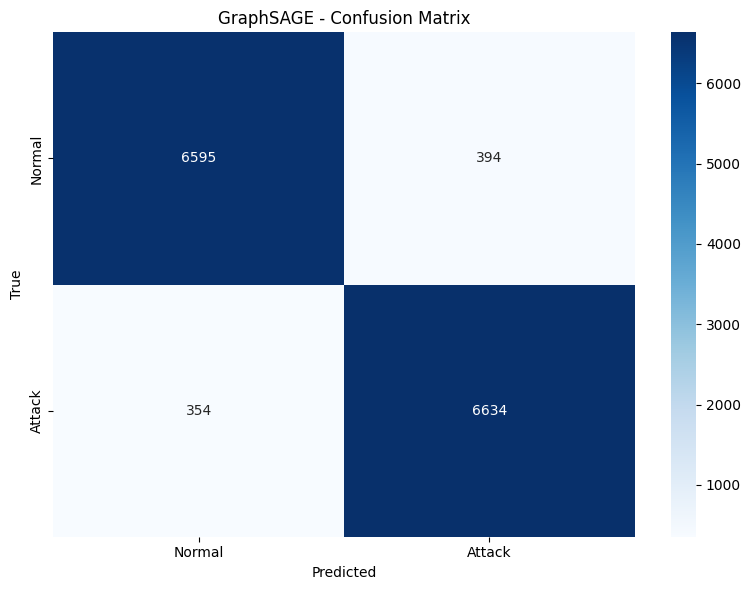

In [45]:
# Generate and plot the confusion matrix for GraphSAGE
cm_graphsage = confusion_matrix(test_labels.cpu(), test_preds.cpu())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_graphsage, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title('GraphSAGE - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

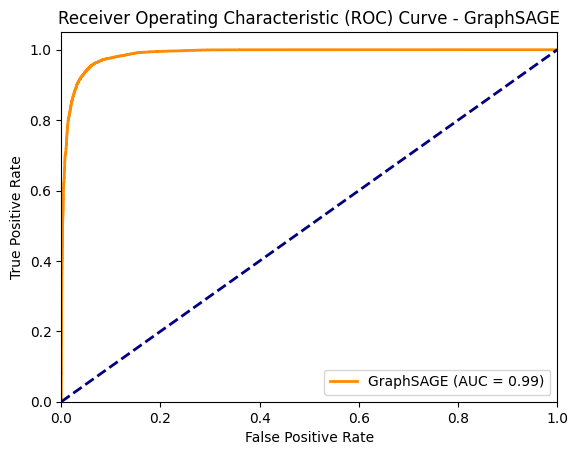


ROC AUC for GraphSAGE: 0.9874


In [46]:
#roc curve of graphsage

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class (class 1)
y_prob_graphsage = test_probs.numpy()
y_true_graphsage = test_labels.cpu().numpy()

# Calculate ROC curve and AUC
fpr_graphsage, tpr_graphsage, thresholds_graphsage = roc_curve(y_true_graphsage, y_prob_graphsage)
roc_auc_graphsage = auc(fpr_graphsage, tpr_graphsage)

# Plot ROC curve
plt.figure()
plt.plot(fpr_graphsage, tpr_graphsage, color='darkorange', lw=2, label='GraphSAGE (AUC = %0.2f)' % roc_auc_graphsage)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - GraphSAGE')
plt.legend(loc="lower right")
plt.show()

print(f"\nROC AUC for GraphSAGE: {roc_auc_graphsage:.4f}")


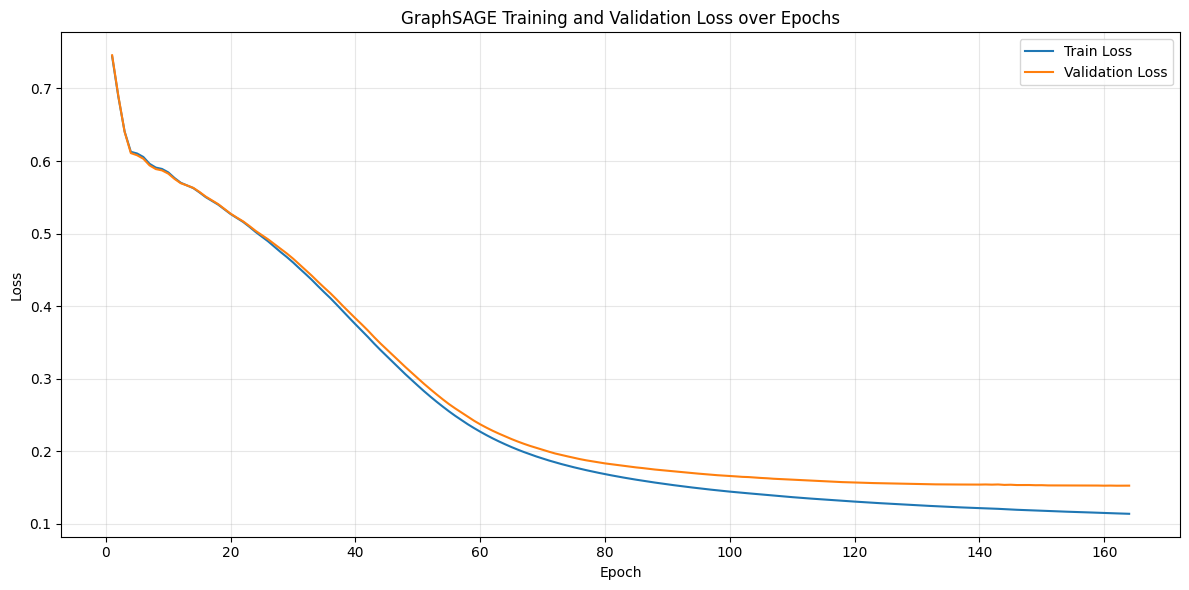

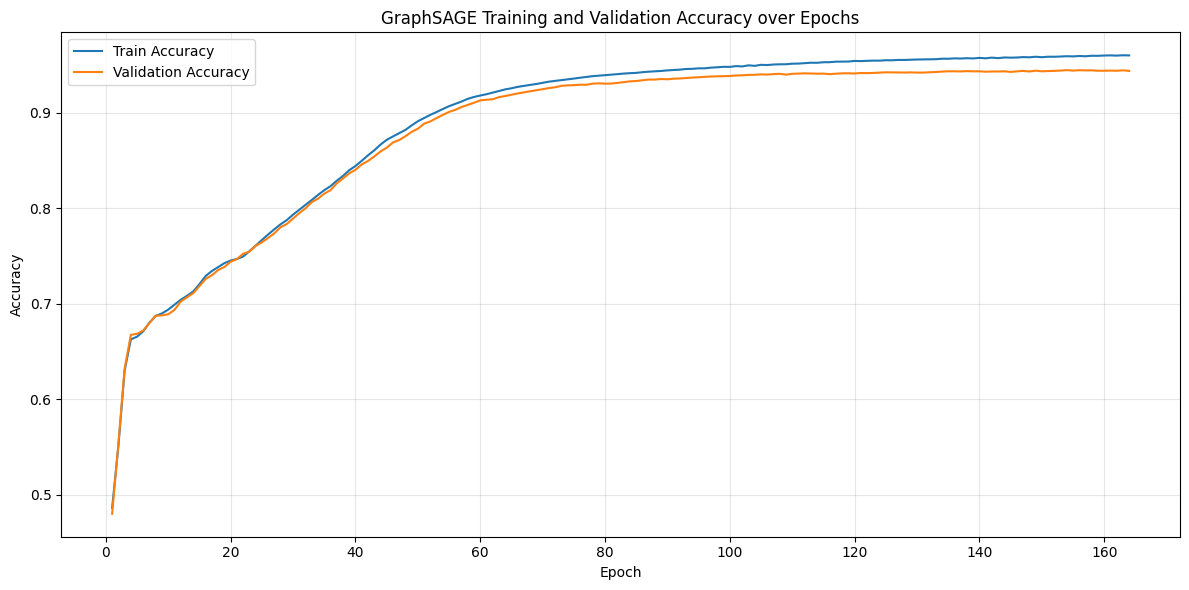

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert training history to DataFrame
results_df_gnn = pd.DataFrame(training_history)

# Plotting Loss curves
plt.figure(figsize=(12, 6))
plt.plot(results_df_gnn['epoch'], results_df_gnn['train_loss'], label='Train Loss')
plt.plot(results_df_gnn['epoch'], results_df_gnn['val_loss'], label='Validation Loss')
plt.title('GraphSAGE Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting Accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(results_df_gnn['epoch'], results_df_gnn['train_acc'], label='Train Accuracy')
plt.plot(results_df_gnn['epoch'], results_df_gnn['val_acc'], label='Validation Accuracy')
plt.title('GraphSAGE Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Global GraphSAGE Feature Importance (Permutation-based)**

Explaining nodes: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]
/tmp/ipython-input-1686910378.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="Importance", y="Feature_Name", palette="magma")



 Global Feature Importance (Structure-aware):
- Anomaly_Severity_Index: ΔLoss = 0.2013
- IAT_Backward: ΔLoss = 0.1282
- Flow_Duration: ΔLoss = 0.1268
- Source_Port: ΔLoss = 0.1218
- Total_Forward_Packets: ΔLoss = 0.0969
- Packet_Length_Mean_Forward: ΔLoss = 0.0815
- IAT_Forward: ΔLoss = 0.0701
- Memory_Utilization: ΔLoss = 0.0298
- IDS_Alert_Count: ΔLoss = 0.0274
- Anomaly_Score: ΔLoss = 0.0234
- CPU_Utilization: ΔLoss = 0.0226
- Normalized_Packet_Flow: ΔLoss = 0.0211
- Destination_IP: ΔLoss = 0.0118
- System_Patch_Status: ΔLoss = 0.0111
- Destination_Port: ΔLoss = 0.0094
- Total_Backward_Packets: ΔLoss = 0.0030
- Attack_Vector: ΔLoss = 0.0010
- Botnet_Family: ΔLoss = 0.0000
- Malware_Type: ΔLoss = 0.0000
- Flow_Bytes_per_s: ΔLoss = -0.0001


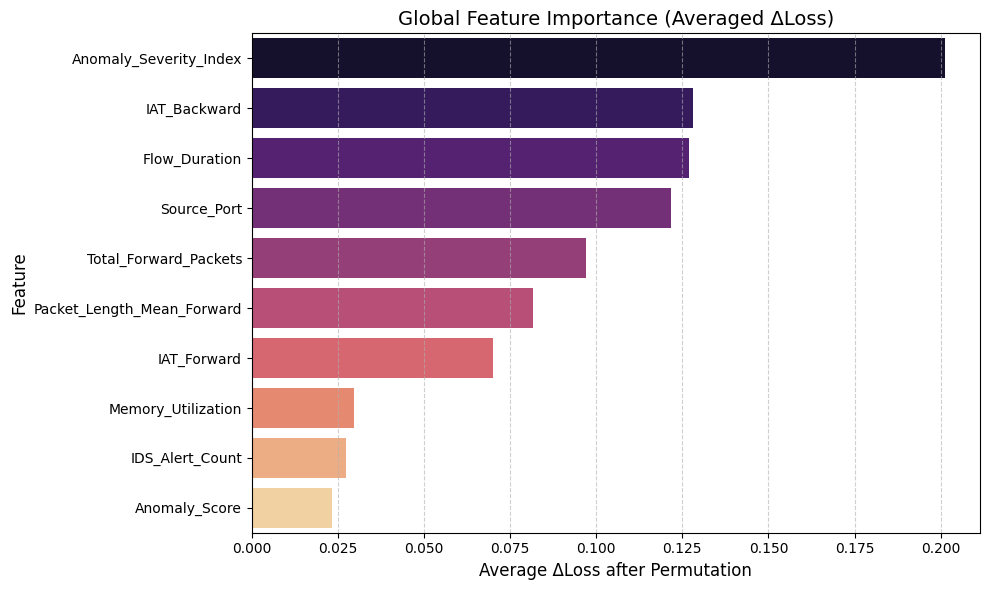

In [48]:
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
import numpy as np
import torch
from tqdm import tqdm

def global_graphsage_feature_importance(
    model, data, loss_fn, device, feature_names,
    num_nodes=100, num_permutations=5
):
    model.eval()
    num_features = data.x.size(1)
    x_cpu = data.x.clone().cpu()
    edge_index = data.edge_index.to(device)
    y = data.y.to(device)

    # Get candidate test nodes
    test_nodes = data.test_mask.nonzero(as_tuple=True)[0].cpu().tolist()
    np.random.shuffle(test_nodes)
    nodes_to_explain = test_nodes[:num_nodes]

    global_importance = {i: [] for i in range(num_features)}

    for node_idx in tqdm(nodes_to_explain, desc="Explaining nodes"):
        with torch.no_grad():
            original_output = model(data.x.to(device), edge_index)
            original_loss = loss_fn(
                original_output[node_idx].unsqueeze(0),
                y[node_idx].unsqueeze(0)
            ).item()

        # Get 1-hop subgraph (neighbors)
        subset, _, _, _ = k_hop_subgraph(node_idx, 1, data.edge_index, relabel_nodes=False)
        neighbor_nodes = subset.tolist()

        for feature_idx in range(num_features):
            loss_diffs = []

            for _ in range(num_permutations):
                x_perturbed = x_cpu.clone()

                # Permute feature values among neighbor nodes
                shuffled_vals = x_perturbed[neighbor_nodes, feature_idx][torch.randperm(len(neighbor_nodes))]
                x_perturbed[neighbor_nodes, feature_idx] = shuffled_vals

                # New data object for inference
                perturbed_data = Data(
                    x=x_perturbed.to(device),
                    edge_index=edge_index,
                    y=y
                )

                with torch.no_grad():
                    output_perturbed = model(perturbed_data.x, perturbed_data.edge_index)
                    perturbed_loss = loss_fn(
                        output_perturbed[node_idx].unsqueeze(0),
                        y[node_idx].unsqueeze(0)
                    ).item()

                loss_diffs.append(perturbed_loss - original_loss)

            # Store average impact
            avg_impact = np.mean(loss_diffs)
            global_importance[feature_idx].append(avg_impact)

    # Average over all nodes
    avg_feature_importance = {
        i: np.mean(global_importance[i]) for i in global_importance
    }

    # Sort and format
    sorted_importance = sorted(avg_feature_importance.items(), key=lambda x: x[1], reverse=True)

    # Print top 15 features
    print("\n Global Feature Importance (Structure-aware):")
    for idx, score in sorted_importance[:20]:
        print(f"- {feature_names[idx]}: ΔLoss = {score:.4f}")

    return sorted_importance

sorted_global_importance = global_graphsage_feature_importance(
    model=model,
    data=data,
    loss_fn=loss_fn,
    device=device,
    feature_names=X.columns.tolist(),  # Your DataFrame column names
    num_nodes=10,                      # Number of test nodes to sample
    num_permutations=5                 # Controls speed vs. accuracy
)


# --- Visualization of Global Feature Importance  ---

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare DataFrame of top-k global features
top_k = 10
imp_df = pd.DataFrame(sorted_global_importance[:top_k], columns=["Feature_Index", "Importance"])
imp_df["Feature_Name"] = imp_df["Feature_Index"].apply(lambda x: feature_names[x])  # use your passed feature_names

# Sort again (optional, just for neat plotting)
imp_df = imp_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df, x="Importance", y="Feature_Name", palette="magma")
plt.title("Global Feature Importance (Averaged ΔLoss)", fontsize=14)
plt.xlabel("Average ΔLoss after Permutation", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Post detection anomalies clustering for graphsage**


Cluster Performance Analysis (PREDICTED ATTACK only):
   Cluster  Mean_Probability  STD_Probability  Sample_Count  \
0        0          0.934071         0.115219          4735   
1        1          0.951019         0.096658          2293   

   Misclassification_Rate  
0                0.061880  
1                0.044047  

⚠️ Suspicious Cluster: 0 (Lowest Mean Attack Probability)


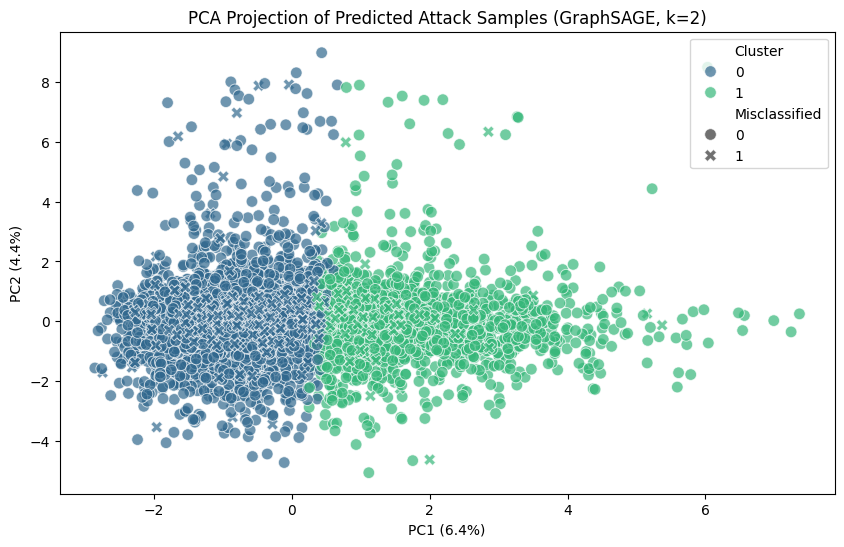

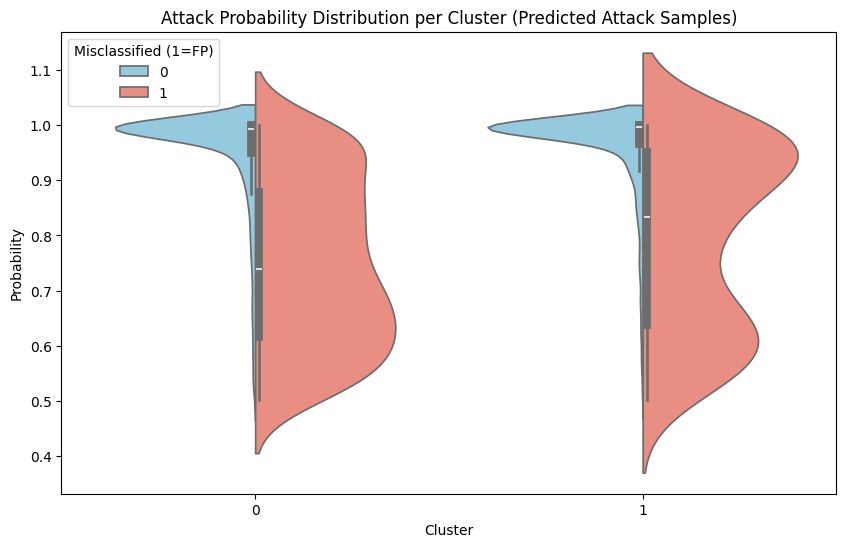


Top 10 features per cluster based on average value:

Cluster 0 top features:
Attack_Probability     0.934071
Attack_Severity        0.214442
Destination_IP         0.174462
Protocol_Type          0.174169
System_Patch_Status    0.159424
Source_IP              0.145072
CPU_Utilization        0.142937
Botnet_Family          0.098414
Malware_Type           0.094148
Attack_Vector          0.069968
Name: 0, dtype: float32

Cluster 1 top features:
Anomaly_Severity_Index    1.170476
Anomaly_Score             1.081268
Attack_Probability        0.951019
IDS_Alert_Count           0.661148
Protocol_Type             0.229497
Destination_IP            0.190144
Attack_Severity           0.173774
Total_Backward_Packets    0.136003
System_Patch_Status       0.134222
Attack_Vector             0.085630
Name: 1, dtype: float32


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# ==============================================
# 1. Define GraphSAGE Model
# ==============================================
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# ==============================================
# 2. Load Trained Model
# ==============================================
model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=64, out_channels=2).to(device)
model.load_state_dict(best_model_state)  # ensure this exists from your training step
model.eval()

# ==============================================
# 3. Get Predictions and Probabilities
# ==============================================
with torch.no_grad():
    out_logits = model(data.x.to(device), data.edge_index.to(device))
    test_logits = out_logits[data.test_mask]  # only test nodes
    y_pred = test_logits.argmax(dim=1).cpu().numpy()
    y_proba = torch.exp(test_logits).cpu().numpy()  # convert log-softmax to probabilities

# ==============================================
# 4. Prepare Test Data
# ==============================================
X_test_scaled = data.x[data.test_mask].cpu().numpy()
y_test = data.y[data.test_mask].cpu().numpy()

# Filter only predicted attacks (label=1)
predicted_attack_mask = (y_pred == 1)
X_attack_predicted = X_test_scaled[predicted_attack_mask]
y_attack_true = y_test[predicted_attack_mask]
y_attack_proba = y_proba[predicted_attack_mask, 1]  # probability of attack

# Misclassification flag (1=FP, 0=TP)
misclassified = (y_attack_true != 1).astype(int)

# Combine features + attack probability
X_combined = np.c_[X_attack_predicted, y_attack_proba]

# Scale data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# ==============================================
# 5. K-Means Clustering
# ==============================================
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# ==============================================
# 6. PCA for 2D Visualization
# ==============================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Probability': y_attack_proba,
    'Misclassified': misclassified
})

# ==============================================
# 7. Cluster Stats
# ==============================================
cluster_stats = viz_df.groupby("Cluster").agg(
    Mean_Probability=("Probability", "mean"),
    STD_Probability=("Probability", "std"),
    Sample_Count=("Probability", "count"),
    Misclassification_Rate=("Misclassified", "mean")
).reset_index()

print("\nCluster Performance Analysis (PREDICTED ATTACK only):")
print(cluster_stats)

# Identify suspicious cluster
suspect_cluster = cluster_stats.loc[
    cluster_stats["Mean_Probability"].idxmin(), "Cluster"
]
print(f"\n⚠️ Suspicious Cluster: {suspect_cluster} (Lowest Mean Attack Probability)")

# ==============================================
# 8. PCA Scatter Plot
# ==============================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=viz_df, x="PC1", y="PC2",
    hue="Cluster", style="Misclassified",
    palette="viridis", alpha=0.7, s=70
)
plt.title(f"PCA Projection of Predicted Attack Samples (GraphSAGE, k={k})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.show()

# ==============================================
# 9. Violin Plot of Attack Probabilities
# ==============================================
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=viz_df, x="Cluster", y="Probability",
    hue="Misclassified", split=True,
    palette={0: "skyblue", 1: "salmon"}
)
plt.title("Attack Probability Distribution per Cluster (Predicted Attack Samples)")
plt.legend(title="Misclassified (1=FP)")
plt.show()

# ==============================================
# 10. Top Features per Cluster
# ==============================================
# feature_names = [f'Feature_{i}' for i in range(X_test_scaled.shape[1])] + ['Attack_Probability']
# df_features = pd.DataFrame(X_combined, columns=feature_names)
# df_features['Cluster'] = clusters

# feature_means = df_features.groupby('Cluster').mean().T

# print("\nTop 10 features per cluster based on average value:")
# for cluster_id in feature_means.columns:
#     print(f"\nCluster {cluster_id} top features:")
#     print(feature_means[cluster_id].sort_values(ascending=False).head(10))

# Used original feature names from dataset
# Assuming X_test is a DataFrame with proper column names
feature_names = list(X_test.columns) + ['Attack_Probability']

df_features = pd.DataFrame(X_combined, columns=feature_names)
df_features['Cluster'] = clusters

feature_means = df_features.groupby('Cluster').mean().T

print("\nTop 10 features per cluster based on average value:")
for cluster_id in feature_means.columns:
    print(f"\nCluster {cluster_id} top features:")
    print(feature_means[cluster_id].sort_values(ascending=False).head(10))




Cluster Performance Analysis (PREDICTED ATTACK only):
   Cluster  Mean_Probability  STD_Probability  Sample_Count  \
0        0          0.934071         0.115219          4735   
1        1          0.951019         0.096658          2293   

   Misclassification_Rate  
0                0.061880  
1                0.044047  

⚠️ Suspicious Cluster: 0 (Lowest Mean Attack Probability)


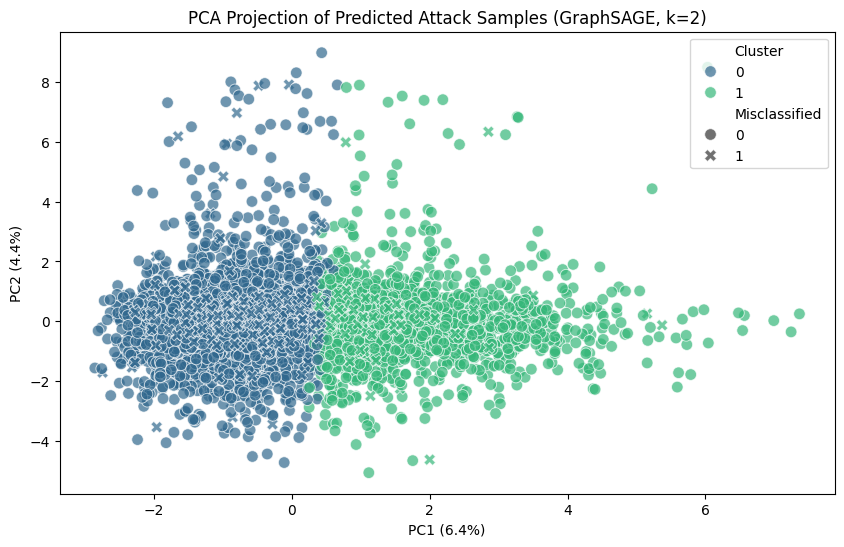

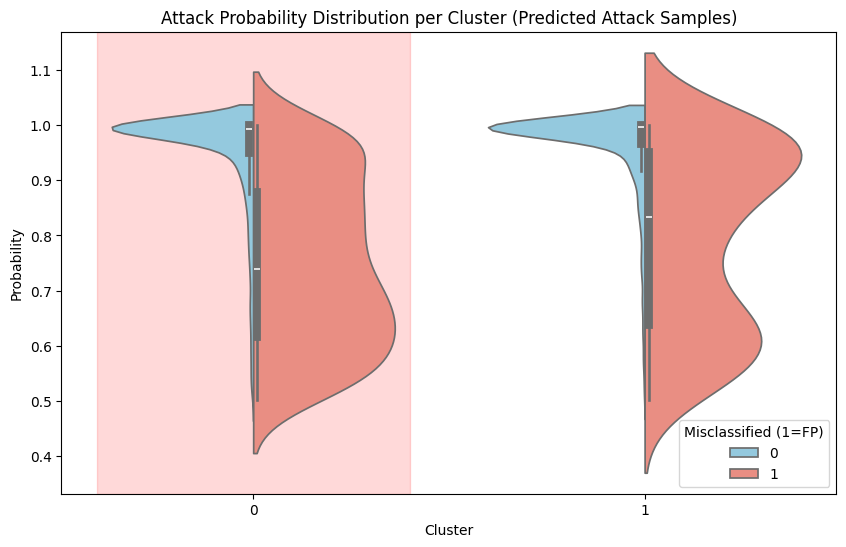


Top 10 features per cluster based on average value:

Cluster 0 top features:
Attack_Probability     0.934071
Attack_Severity        0.214442
Destination_IP         0.174462
Protocol_Type          0.174169
System_Patch_Status    0.159424
Source_IP              0.145072
CPU_Utilization        0.142937
Botnet_Family          0.098414
Malware_Type           0.094148
Attack_Vector          0.069968
Name: 0, dtype: float32

Cluster 1 top features:
Anomaly_Severity_Index    1.170476
Anomaly_Score             1.081268
Attack_Probability        0.951019
IDS_Alert_Count           0.661148
Protocol_Type             0.229497
Destination_IP            0.190144
Attack_Severity           0.173774
Total_Backward_Packets    0.136003
System_Patch_Status       0.134222
Attack_Vector             0.085630
Name: 1, dtype: float32


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# ==============================================
# 1. Define GraphSAGE Model
# ==============================================
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# ==============================================
# 2. Load Trained Model
# ==============================================
model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=64, out_channels=2).to(device)
model.load_state_dict(best_model_state)  # ensure this exists from your training step
model.eval()

# ==============================================
# 3. Get Predictions and Probabilities
# ==============================================
with torch.no_grad():
    out_logits = model(data.x.to(device), data.edge_index.to(device))
    test_logits = out_logits[data.test_mask]  # only test nodes
    y_pred = test_logits.argmax(dim=1).cpu().numpy()
    y_proba = torch.exp(test_logits).cpu().numpy()  # convert log-softmax to probabilities

# ==============================================
# 4. Prepare Test Data
# ==============================================
X_test_scaled = data.x[data.test_mask].cpu().numpy()
y_test = data.y[data.test_mask].cpu().numpy()

# Filter only predicted attacks (label=1)
predicted_attack_mask = (y_pred == 1)
X_attack_predicted = X_test_scaled[predicted_attack_mask]
y_attack_true = y_test[predicted_attack_mask]
y_attack_proba = y_proba[predicted_attack_mask, 1]  # probability of attack

# Misclassification flag (1=FP, 0=TP)
misclassified = (y_attack_true != 1).astype(int)

# Combine features + attack probability
X_combined = np.c_[X_attack_predicted, y_attack_proba]

# Scale data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# ==============================================
# 5. K-Means Clustering
# ==============================================
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# ==============================================
# 6. PCA for 2D Visualization
# ==============================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Probability': y_attack_proba,
    'Misclassified': misclassified
})

# ==============================================
# 7. Cluster Stats
# ==============================================
cluster_stats = viz_df.groupby("Cluster").agg(
    Mean_Probability=("Probability", "mean"),
    STD_Probability=("Probability", "std"),
    Sample_Count=("Probability", "count"),
    Misclassification_Rate=("Misclassified", "mean")
).reset_index()

print("\nCluster Performance Analysis (PREDICTED ATTACK only):")
print(cluster_stats)

# Identify suspicious cluster
suspect_cluster = cluster_stats.loc[
    cluster_stats["Mean_Probability"].idxmin(), "Cluster"
]
print(f"\n⚠️ Suspicious Cluster: {suspect_cluster} (Lowest Mean Attack Probability)")

# ==============================================
# 8. PCA Scatter Plot
# ==============================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=viz_df, x="PC1", y="PC2",
    hue="Cluster", style="Misclassified",
    palette="viridis", alpha=0.7, s=70
)
plt.title(f"PCA Projection of Predicted Attack Samples (GraphSAGE, k={k})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.show()

# ==============================================
# 9. Violin Plot of Attack Probabilities
# ==============================================
plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    data=viz_df, x="Cluster", y="Probability",
    hue="Misclassified", split=True,
    palette={0: "skyblue", 1: "salmon"}
)
plt.title("Attack Probability Distribution per Cluster (Predicted Attack Samples)")

# Highlight suspicious cluster
suspect_x_pos = list(sorted(viz_df["Cluster"].unique())).index(suspect_cluster)
ax.axvspan(suspect_x_pos - 0.4, suspect_x_pos + 0.4,
           color='red', alpha=0.15, zorder=0)

plt.legend(title="Misclassified (1=FP)")
plt.show()


# Used original feature names from dataset
# Assuming X_test is a DataFrame with proper column names
feature_names = list(X_test.columns) + ['Attack_Probability']

df_features = pd.DataFrame(X_combined, columns=feature_names)
df_features['Cluster'] = clusters

feature_means = df_features.groupby('Cluster').mean().T

print("\nTop 10 features per cluster based on average value:")
for cluster_id in feature_means.columns:
    print(f"\nCluster {cluster_id} top features:")
    print(feature_means[cluster_id].sort_values(ascending=False).head(10))



**GCN**




Epoch 001 | Train Loss: 0.7186 | Train Acc: 0.5165 | Val Loss: 0.7123 | Val Acc: 0.5196
Epoch 002 | Train Loss: 0.7105 | Train Acc: 0.5661 | Val Loss: 0.6874 | Val Acc: 0.5659
Epoch 003 | Train Loss: 0.6867 | Train Acc: 0.6173 | Val Loss: 0.6643 | Val Acc: 0.6206
Epoch 004 | Train Loss: 0.6646 | Train Acc: 0.5869 | Val Loss: 0.6539 | Val Acc: 0.5905
Epoch 005 | Train Loss: 0.6550 | Train Acc: 0.5879 | Val Loss: 0.6458 | Val Acc: 0.5927
Epoch 006 | Train Loss: 0.6477 | Train Acc: 0.6200 | Val Loss: 0.6310 | Val Acc: 0.6217
Epoch 007 | Train Loss: 0.6337 | Train Acc: 0.6524 | Val Loss: 0.6130 | Val Acc: 0.6572
Epoch 008 | Train Loss: 0.6164 | Train Acc: 0.6691 | Val Loss: 0.6010 | Val Acc: 0.6720
Epoch 009 | Train Loss: 0.6054 | Train Acc: 0.6722 | Val Loss: 0.5980 | Val Acc: 0.6767
Epoch 010 | Train Loss: 0.6034 | Train Acc: 0.6750 | Val Loss: 0.5981 | Val Acc: 0.6789
Epoch 011 | Train Loss: 0.6041 | Train Acc: 0.6776 | Val Loss: 0.5976 | Val Acc: 0.6807
Epoch 012 | Train Loss: 0.6033 |

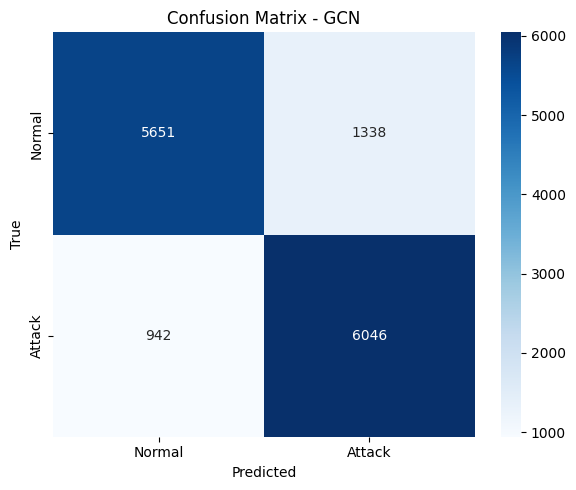

In [67]:


# 4. Define GCN Model
class GCNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.out(x)

# 5. Training
model = GCNNet(input_dim=X.shape[1], hidden_dim=64, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
counter = 0
patience = 10

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

        train_pred = out[data.train_mask].argmax(dim=1)
        val_pred = out[data.val_mask].argmax(dim=1)

        train_acc = accuracy_score(data.y[data.train_mask].cpu(), train_pred.cpu())
        val_acc = accuracy_score(data.y[data.val_mask].cpu(), val_pred.cpu())

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}. Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
            break

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# 6. Evaluation on test set
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    final_out = model(data.x, data.edge_index)
    probs = F.softmax(final_out, dim=1)
    preds = probs.argmax(dim=1)

    test_preds = preds[data.test_mask]
    test_probs = probs[data.test_mask, 1].cpu().numpy()
    test_labels = data.y[data.test_mask].cpu().numpy()

# Classification Report
print("\nGCN Classification Report:\n")
print(classification_report(test_labels, test_preds.cpu(), target_names=["Normal", "Attack"]))

gcn_test_acc = accuracy_score(test_labels, test_preds.cpu())
print(f"\n Final Test Accuracy: {gcn_test_acc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds.cpu()))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds.cpu())
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title('Confusion Matrix - GCN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()



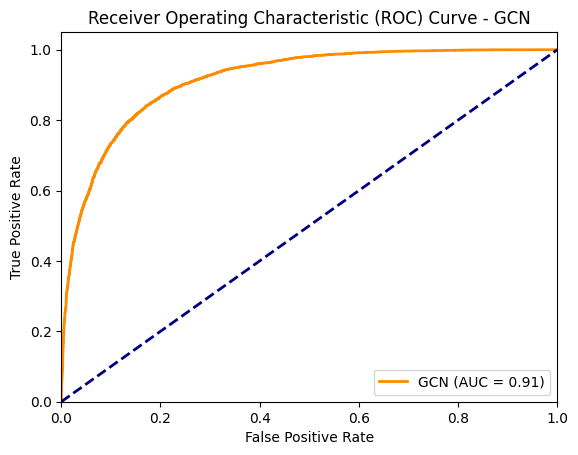


ROC AUC for GCN: 0.9141


In [70]:
# roc curve for gcn

# Get the predicted probabilities for the positive class (class 1) for GCN
y_prob_gcn = test_probs
y_true_gcn = test_labels

# Calculate ROC curve and AUC for GCN
fpr_gcn, tpr_gcn, thresholds_gcn = roc_curve(y_true_gcn, y_prob_gcn)
roc_auc_gcn = auc(fpr_gcn, tpr_gcn)

# Plot ROC curve
plt.figure()
plt.plot(fpr_gcn, tpr_gcn, color='darkorange', lw=2, label='GCN (AUC = %0.2f)' % roc_auc_gcn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - GCN')
plt.legend(loc="lower right")
plt.show()

print(f"\nROC AUC for GCN: {roc_auc_gcn:.4f}")

In [72]:
 #Log Loss & Result Saving
gcn_logloss = log_loss(test_labels, test_probs)
print(f"\n\U0001F50D GCN Log Loss: {gcn_logloss:.4f}")


🔍 GCN Log Loss: 0.3835


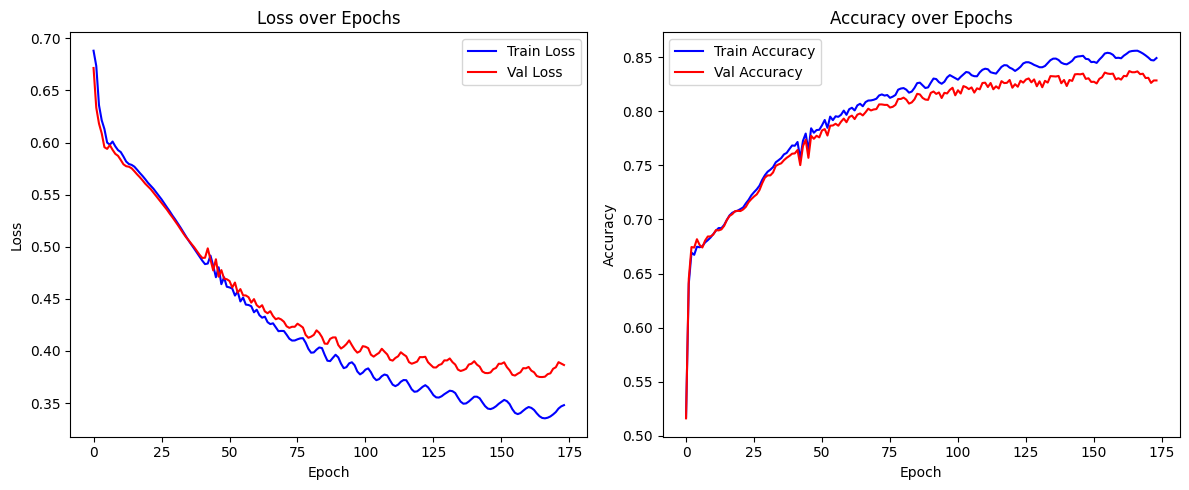

In [71]:
# Train vs Val Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Val Loss", color="red")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="blue")
plt.plot(val_accuracies, label="Val Accuracy", color="red")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

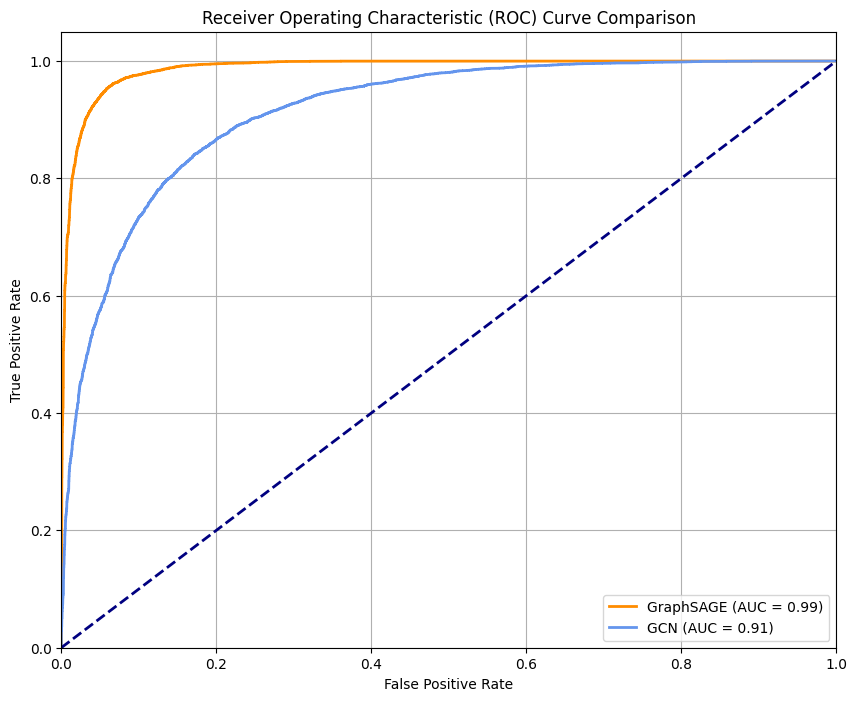

In [73]:
# generate the graph comparison of graphsage and gcn model roc curve

# Plot ROC curve comparison
plt.figure(figsize=(10, 8))
plt.plot(fpr_graphsage, tpr_graphsage, color='darkorange', lw=2, label='GraphSAGE (AUC = %0.2f)' % roc_auc_graphsage)
plt.plot(fpr_gcn, tpr_gcn, color='cornflowerblue', lw=2, label='GCN (AUC = %0.2f)' % roc_auc_gcn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

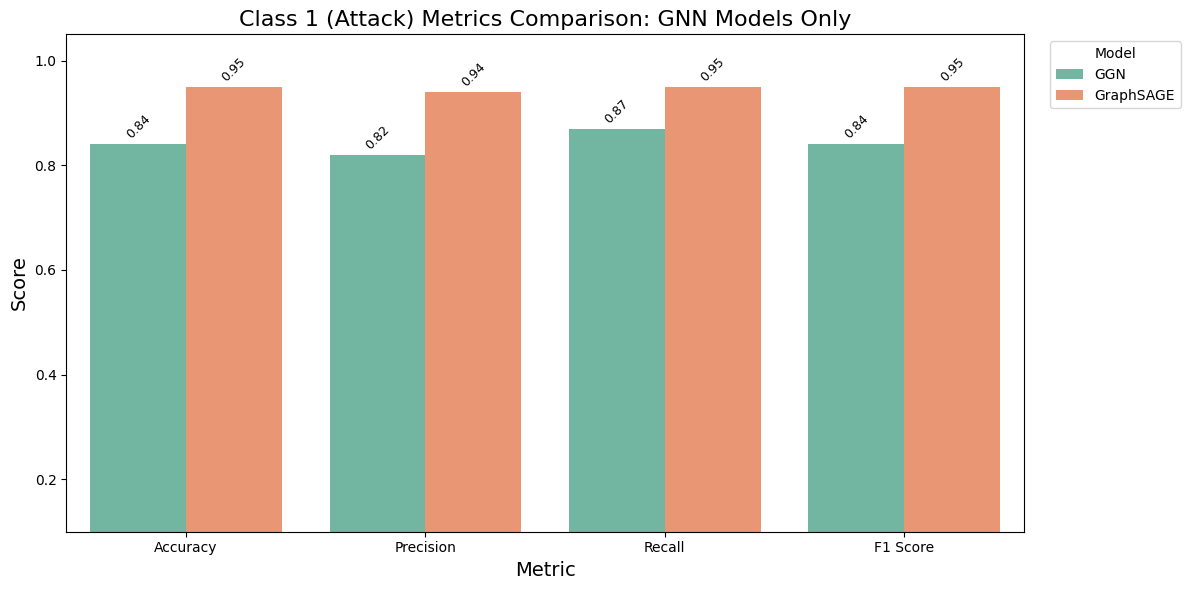

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GNN model metrics (only for class "Attack")
metrics = [
    {"Model": "GGN", "Accuracy": 0.84, "Precision": 0.82, "Recall": 0.87, "F1 Score": 0.84},
    {"Model": "GraphSAGE", "Accuracy": 0.95, "Precision": 0.94, "Recall": 0.95, "F1 Score": 0.95}
]

# Convert to DataFrame
df = pd.DataFrame(metrics)

# Melt for seaborn
df_melted = df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1 Score"],
                    var_name="Metric", value_name="Score")

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette="Set2")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2, fontsize=9, rotation=45)

# Styling
plt.title('Class 1 (Attack) Metrics Comparison: GNN Models Only', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0.1, 1.05)
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Knowledge Graph with Threat Intelligence**

1111

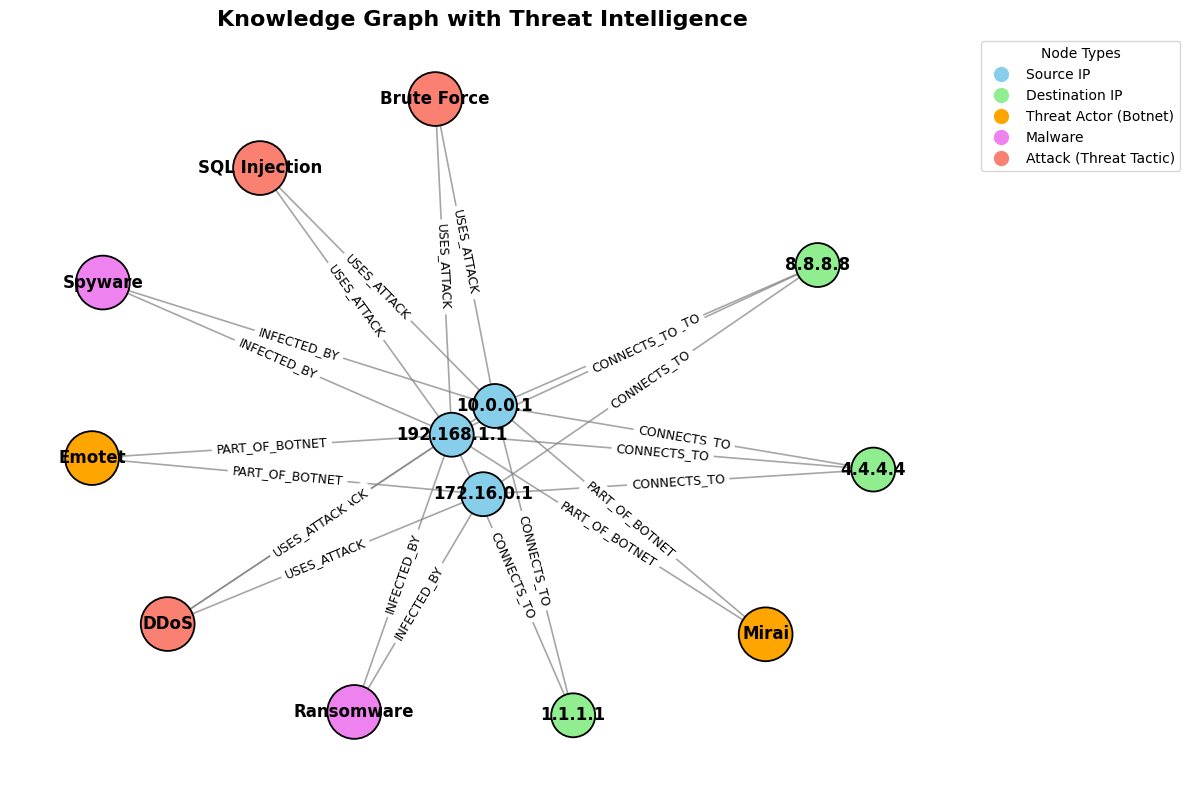

In [91]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Cybersecurity_Dataset/CTDAPD Dataset.csv')

# Sample subset (adjust size as needed)
subset_df = df[(df["Malware_Type"].notna()) | (df["Botnet_Family"].notna()) | (df["Attack_Vector"].notna())].head(50)

# Create the graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in subset_df.iterrows():
    src = row['Source_IP']
    dst = row['Destination_IP']

    G.add_node(src, type='Internal_Device')
    G.add_node(dst, type='External_Service')
    G.add_edge(src, dst, relationship='CONNECTS_TO')

    if pd.notna(row['Malware_Type']):
        G.add_node(row['Malware_Type'], type='Malware')
        G.add_edge(src, row['Malware_Type'], relationship='INFECTED_BY')

    if pd.notna(row['Botnet_Family']):
        G.add_node(row['Botnet_Family'], type='Threat_Actor')
        G.add_edge(src, row['Botnet_Family'], relationship='PART_OF_BOTNET')

    if pd.notna(row['Attack_Vector']):
        G.add_node(row['Attack_Vector'], type='Threat_Tactic')
        G.add_edge(src, row['Attack_Vector'], relationship='USES_ATTACK')

# Generate layout with more spacing
# k controls repulsion (larger = more space), iterations improve stability
pos = nx.spring_layout(G, k=1.6, iterations=150, seed=42)

# Node color and size maps
node_colors_map = {
    'Internal_Device': 'skyblue',
    'External_Service': 'lightgreen',
    'Threat_Actor': 'orange',
    'Malware': 'violet',
    'Threat_Tactic': 'salmon'
}
node_size_map = {
    'Internal_Device': 1000,
    'External_Service': 1000,
    'Threat_Actor': 1500,
    'Malware': 1500,
    'Threat_Tactic': 1500
}

# Assign colors and sizes
colors = [node_colors_map.get(G.nodes[n].get('type', ''), 'gray') for n in G.nodes()]
sizes = [node_size_map.get(G.nodes[n].get('type', ''), 600) for n in G.nodes()]

# Plotting
plt.figure(figsize=(12, 8))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, edgecolors='black', linewidths=1.3)
nx.draw_networkx_edges(G, pos, width=1.2, edge_color='gray', alpha=0.7)

# Draw labels for threat nodes only
label_types = ['Internal_Device', 'External_Service', 'Malware', 'Threat_Actor', 'Threat_Tactic']
labels = {n: n for n in G.nodes() if G.nodes[n].get('type') in label_types}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold')

# Draw edge labels
edge_labels = {(u, v): d['relationship'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Source IP', markerfacecolor='skyblue', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Destination IP', markerfacecolor='lightgreen', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Threat Actor (Botnet)', markerfacecolor='orange', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Malware', markerfacecolor='violet', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Attack (Threat Tactic)', markerfacecolor='salmon', markersize=12),
]
plt.legend(handles=legend_elements, title="Node Types", loc='upper left', bbox_to_anchor=(1.02, 1))

# Final touches
plt.title("Knowledge Graph with Threat Intelligence", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()



22222

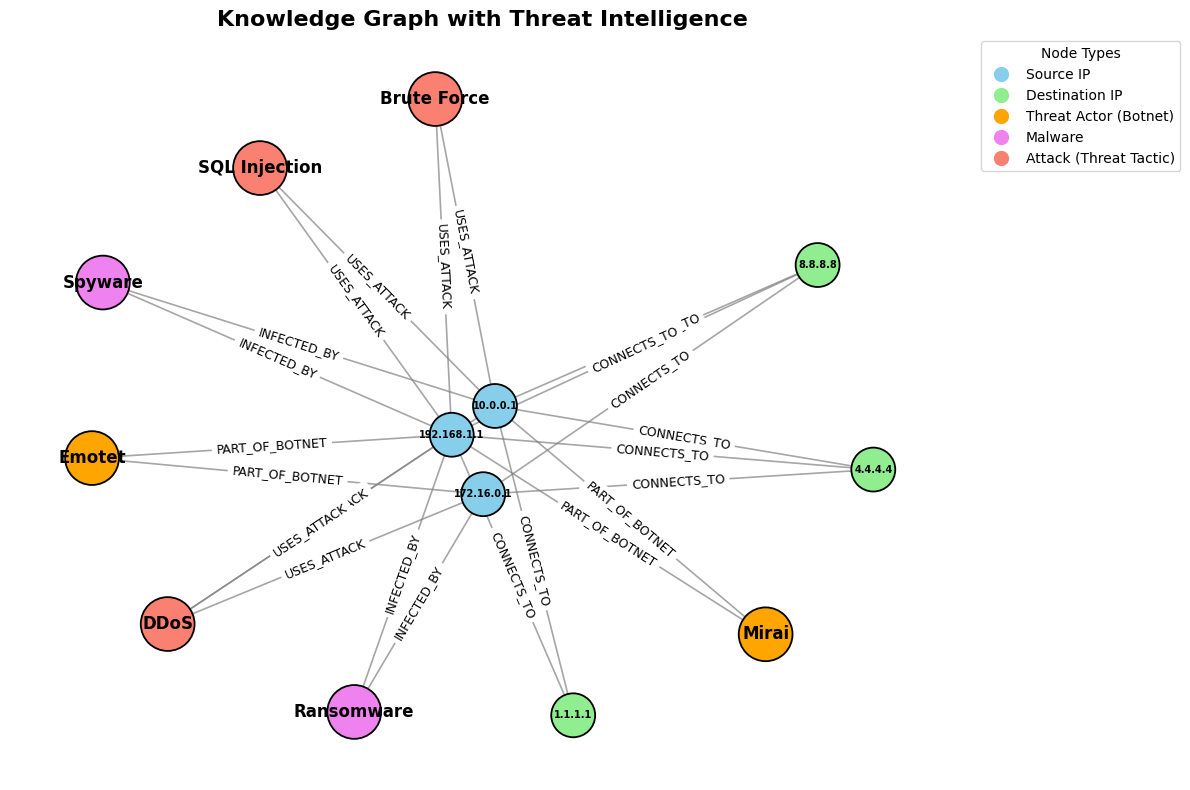

In [95]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Cybersecurity_Dataset/CTDAPD Dataset.csv')

# Sample subset (adjust size as needed)
subset_df = df[(df["Malware_Type"].notna()) | (df["Botnet_Family"].notna()) | (df["Attack_Vector"].notna())].head(50)

# Create the graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in subset_df.iterrows():
    src = row['Source_IP']
    dst = row['Destination_IP']

    G.add_node(src, type='Internal_Device')
    G.add_node(dst, type='External_Service')
    G.add_edge(src, dst, relationship='CONNECTS_TO')

    if pd.notna(row['Malware_Type']):
        G.add_node(row['Malware_Type'], type='Malware')
        G.add_edge(src, row['Malware_Type'], relationship='INFECTED_BY')

    if pd.notna(row['Botnet_Family']):
        G.add_node(row['Botnet_Family'], type='Threat_Actor')
        G.add_edge(src, row['Botnet_Family'], relationship='PART_OF_BOTNET')

    if pd.notna(row['Attack_Vector']):
        G.add_node(row['Attack_Vector'], type='Threat_Tactic')
        G.add_edge(src, row['Attack_Vector'], relationship='USES_ATTACK')

# Generate layout with more spacing
# k controls repulsion (larger = more space), iterations improve stability
pos = nx.spring_layout(G, k=1.6, iterations=150, seed=42)

# Node color and size maps
node_colors_map = {
    'Internal_Device': 'skyblue',
    'External_Service': 'lightgreen',
    'Threat_Actor': 'orange',
    'Malware': 'violet',
    'Threat_Tactic': 'salmon'
}
node_size_map = {
    'Internal_Device': 1000,
    'External_Service': 1000,
    'Threat_Actor': 1500,
    'Malware': 1500,
    'Threat_Tactic': 1500
}

# Assign colors and sizes
colors = [node_colors_map.get(G.nodes[n].get('type', ''), 'gray') for n in G.nodes()]
sizes = [node_size_map.get(G.nodes[n].get('type', ''), 600) for n in G.nodes()]

# Plotting
plt.figure(figsize=(12, 8))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, edgecolors='black', linewidths=1.3)
nx.draw_networkx_edges(G, pos, width=1.2, edge_color='gray', alpha=0.7)


# Separate label dictionaries by type
small_label_types = ['Internal_Device', 'External_Service']
large_label_types = ['Malware', 'Threat_Actor', 'Threat_Tactic']

small_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') in small_label_types}
large_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') in large_label_types}

# Draw small labels for IPs (centered)
nx.draw_networkx_labels(G, pos, small_labels, font_size=7, font_weight='bold', verticalalignment='center')

# Draw larger labels for threat nodes (also centered)
nx.draw_networkx_labels(G, pos, large_labels, font_size=12, font_weight='bold', verticalalignment='center')




# Draw edge labels
edge_labels = {(u, v): d['relationship'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Source IP', markerfacecolor='skyblue', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Destination IP', markerfacecolor='lightgreen', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Threat Actor (Botnet)', markerfacecolor='orange', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Malware', markerfacecolor='violet', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Attack (Threat Tactic)', markerfacecolor='salmon', markersize=12),
]
plt.legend(handles=legend_elements, title="Node Types", loc='upper left', bbox_to_anchor=(1.02, 1))

# Final touches
plt.title("Knowledge Graph with Threat Intelligence", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()



33333


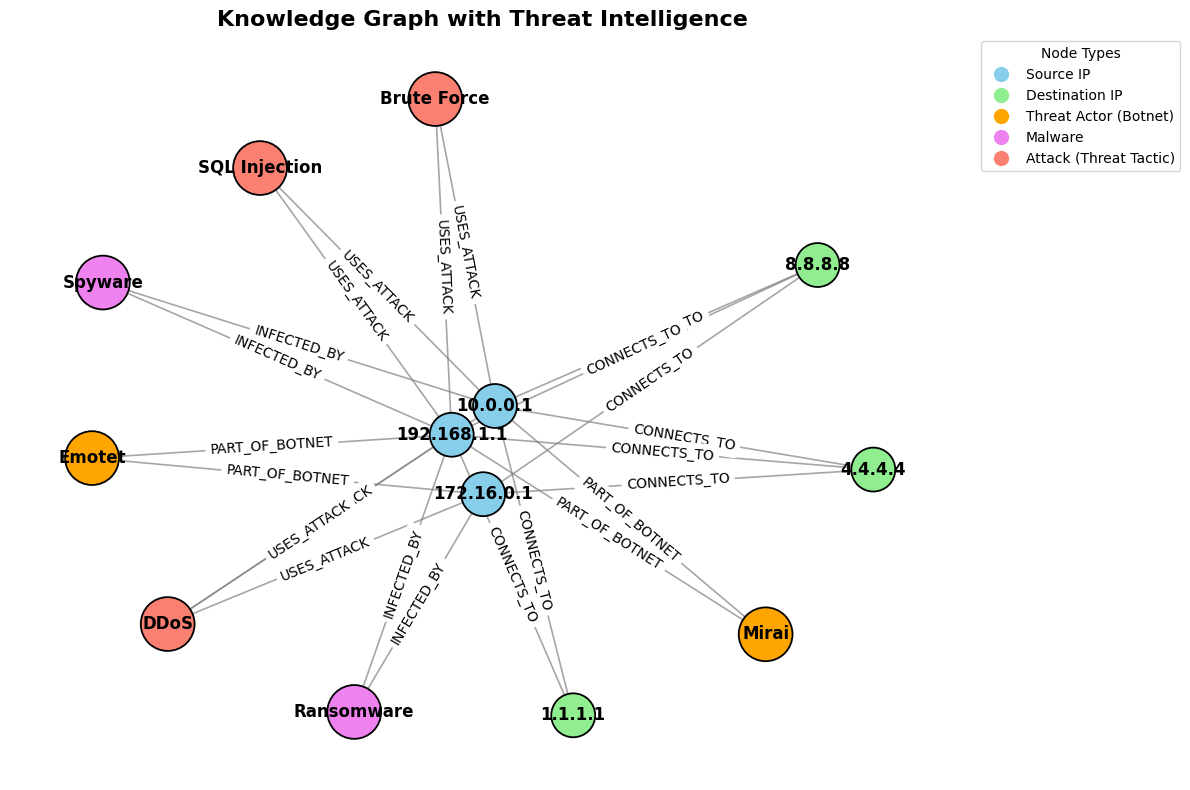

In [88]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Cybersecurity_Dataset/CTDAPD Dataset.csv')

# Sample subset (adjust size as needed)
subset_df = df[(df["Malware_Type"].notna()) | (df["Botnet_Family"].notna()) | (df["Attack_Vector"].notna())].head(50)

# Create the graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in subset_df.iterrows():
    src = row['Source_IP']
    dst = row['Destination_IP']

    G.add_node(src, type='Internal_Device')
    G.add_node(dst, type='External_Service')
    G.add_edge(src, dst, relationship='CONNECTS_TO')

    if pd.notna(row['Malware_Type']):
        G.add_node(row['Malware_Type'], type='Malware')
        G.add_edge(src, row['Malware_Type'], relationship='INFECTED_BY')

    if pd.notna(row['Botnet_Family']):
        G.add_node(row['Botnet_Family'], type='Threat_Actor')
        G.add_edge(src, row['Botnet_Family'], relationship='PART_OF_BOTNET')

    if pd.notna(row['Attack_Vector']):
        G.add_node(row['Attack_Vector'], type='Threat_Tactic')
        G.add_edge(src, row['Attack_Vector'], relationship='USES_ATTACK')

# Generate layout with more spacing
# k controls repulsion (larger = more space), iterations improve stability
pos = nx.spring_layout(G, k=1.6, iterations=150, seed=42)

# Node color and size maps
node_colors_map = {
    'Internal_Device': 'skyblue',
    'External_Service': 'lightgreen',
    'Threat_Actor': 'orange',
    'Malware': 'violet',
    'Threat_Tactic': 'salmon'
}
node_size_map = {
    'Internal_Device': 1000,
    'External_Service': 1000,
    'Threat_Actor': 1500,
    'Malware': 1500,
    'Threat_Tactic': 1500
}

# Assign colors and sizes
colors = [node_colors_map.get(G.nodes[n].get('type', ''), 'gray') for n in G.nodes()]
sizes = [node_size_map.get(G.nodes[n].get('type', ''), 600) for n in G.nodes()]

# Plotting
plt.figure(figsize=(12, 8))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, edgecolors='black', linewidths=1.3)
nx.draw_networkx_edges(G, pos, width=1.2, edge_color='gray', alpha=0.7)

# Draw labels for threat nodes only
label_types = ['Internal_Device', 'External_Service', 'Malware', 'Threat_Actor', 'Threat_Tactic']
labels = {n: n for n in G.nodes() if G.nodes[n].get('type') in label_types}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold')

# Draw edge labels
edge_labels = {(u, v): d['relationship'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Source IP', markerfacecolor='skyblue', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Destination IP', markerfacecolor='lightgreen', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Threat Actor (Botnet)', markerfacecolor='orange', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Malware', markerfacecolor='violet', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Attack (Threat Tactic)', markerfacecolor='salmon', markersize=12),
]
plt.legend(handles=legend_elements, title="Node Types", loc='upper left', bbox_to_anchor=(1.02, 1))

# Final touches
plt.title("Knowledge Graph with Threat Intelligence", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()



4444 main


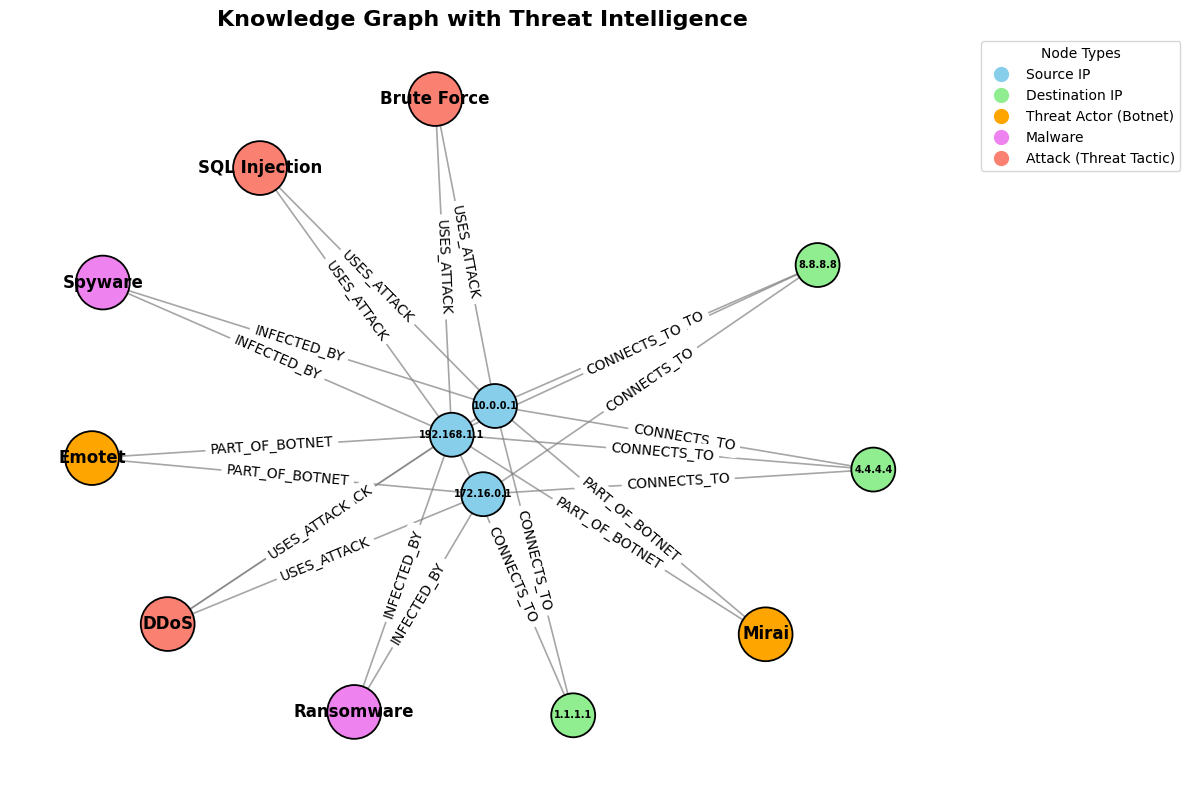

In [97]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Cybersecurity_Dataset/CTDAPD Dataset.csv')

# Sample subset (adjust size as needed)
subset_df = df[(df["Malware_Type"].notna()) | (df["Botnet_Family"].notna()) | (df["Attack_Vector"].notna())].head(50)

# Create the graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in subset_df.iterrows():
    src = row['Source_IP']
    dst = row['Destination_IP']

    G.add_node(src, type='Internal_Device')
    G.add_node(dst, type='External_Service')
    G.add_edge(src, dst, relationship='CONNECTS_TO')

    if pd.notna(row['Malware_Type']):
        G.add_node(row['Malware_Type'], type='Malware')
        G.add_edge(src, row['Malware_Type'], relationship='INFECTED_BY')

    if pd.notna(row['Botnet_Family']):
        G.add_node(row['Botnet_Family'], type='Threat_Actor')
        G.add_edge(src, row['Botnet_Family'], relationship='PART_OF_BOTNET')

    if pd.notna(row['Attack_Vector']):
        G.add_node(row['Attack_Vector'], type='Threat_Tactic')
        G.add_edge(src, row['Attack_Vector'], relationship='USES_ATTACK')

# Generate layout with more spacing
# k controls repulsion (larger = more space), iterations improve stability
pos = nx.spring_layout(G, k=1.6, iterations=150, seed=42)

# Node color and size maps
node_colors_map = {
    'Internal_Device': 'skyblue',
    'External_Service': 'lightgreen',
    'Threat_Actor': 'orange',
    'Malware': 'violet',
    'Threat_Tactic': 'salmon'
}
node_size_map = {
    'Internal_Device': 1000,
    'External_Service': 1000,
    'Threat_Actor': 1500,
    'Malware': 1500,
    'Threat_Tactic': 1500
}

# Assign colors and sizes
colors = [node_colors_map.get(G.nodes[n].get('type', ''), 'gray') for n in G.nodes()]
sizes = [node_size_map.get(G.nodes[n].get('type', ''), 600) for n in G.nodes()]

# Plotting
plt.figure(figsize=(12, 8))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, edgecolors='black', linewidths=1.3)
nx.draw_networkx_edges(G, pos, width=1.2, edge_color='gray', alpha=0.7)


# Separate label dictionaries by type
small_label_types = ['Internal_Device', 'External_Service']
large_label_types = ['Malware', 'Threat_Actor', 'Threat_Tactic']

small_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') in small_label_types}
large_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') in large_label_types}

# Draw small labels for IPs (centered)
nx.draw_networkx_labels(G, pos, small_labels, font_size=7, font_weight='bold', verticalalignment='center')

# Draw larger labels for threat nodes (also centered)
nx.draw_networkx_labels(G, pos, large_labels, font_size=12, font_weight='bold', verticalalignment='center')


# Draw edge labels
edge_labels = {(u, v): d['relationship'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Source IP', markerfacecolor='skyblue', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Destination IP', markerfacecolor='lightgreen', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Threat Actor (Botnet)', markerfacecolor='orange', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Malware', markerfacecolor='violet', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Attack (Threat Tactic)', markerfacecolor='salmon', markersize=12),
]
plt.legend(handles=legend_elements, title="Node Types", loc='upper left', bbox_to_anchor=(1.02, 1))

# Final touches
plt.title("Knowledge Graph with Threat Intelligence", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

